## Terminal category development based on latest PFAS inventory

Prepared by: Grace Patlewicz <br>
Created on: 6th November 2023 <br>
This notebook documents the categorisation process starting with the PFAS landscape comprising all substances meeting the OPPT definition and all TSCA degradation products meeting the same OPPT definition. Analysis here captures the primary-secondary categorisation and subsequent categorisation steps leading to the derivation of terminal categories.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'

In [5]:
df = pd.read_excel(raw_dir+'final_new_inv_df_061123.xlsx', index_col = [0])

Inventory comprises 15,415 substances of which 2959 are degradation products originating from the TSCA inventory substances.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15415 entries, 0 to 3034
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DSSTox_Substance_Id       15415 non-null  object 
 1   DSSTox_QC-Level           12456 non-null  object 
 2   Substance_Name            12456 non-null  object 
 3   Substance_CASRN           12456 non-null  object 
 4   Substance_Type            12456 non-null  object 
 5   Structure_SMILES          15415 non-null  object 
 6   Structure_InChI           12456 non-null  object 
 7   Structure_InChIKey        12456 non-null  object 
 8   Structure_Formula         12456 non-null  object 
 9   Structure_MolWt           12456 non-null  float64
 10  Structure_SMILES_2D-QSAR  8618 non-null   object 
 11  Canonical_QSARr           12203 non-null  object 
 12  TSCA_STATUS               15415 non-null  object 
 13  chain_length              15413 non-null  float64
 14  OECD_Ca

15093 substances with OPERA predictions.

In [9]:
import sys

In [10]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [11]:
from model_functions import *

In [12]:
universe_df = df.copy()

In [36]:
universe_df.rename(columns = {'OECD_Cats': 'category', 'Structure_SMILES': 'smiles', 'DSSTox_Substance_Id': 'dtxsid'}, inplace = True)

In [37]:
universe_df.category.value_counts(dropna = False)

Other aliphatics                 8418
Side-chain aromatics             3794
unclassified                      787
Fluorotelomer PFAA precursors     578
PFAAs                             554
Silicon PFASs                     480
Non-PFAA perfluoroalkyls          272
FASA based PFAA precursors        204
PFAS derivatives                  149
PFAA precursors                   145
Not PFAS                           32
Unable to open ring(s)              2
Name: category, dtype: int64

In [39]:
not_pfas = universe_df[universe_df['category'] == 'Not PFAS']['dtxsid'].tolist()

In [40]:
not_pfas_si = ['DTXSID80631816',
 'DTXSID30787690',
 'DTXSID5059872',
 'DTXSID50448610',
 'DTXSID90962360',
 'MDXUBZVGGFCHAJ-UHFFFAOYSA-N',
 'VSNBTYFDZLAVJV-UHFFFAOYSA-N',
 'YDNBEWGOZYRIPY-UHFFFAOYSA-N']

In [41]:
not_pfas2 = [e for e in not_pfas if e not in not_pfas_si]

In [42]:
universe_df[universe_df['category'] == 'Not PFAS']

dtxsid  DSSTox_QC-Level  \
1                  DTXSID60883371      DSSTox_High   
9                  DTXSID30861929      DSSTox_High   
21                 DTXSID50620131       Public_Low   
26                DTXSID701019263    Public_Medium   
38                 DTXSID00947103      DSSTox_High   
44                DTXSID901023193       DSSTox_Low   
89                 DTXSID50617526       Public_Low   
92                 DTXSID50931113       Public_Low   
96                DTXSID201036997       DSSTox_Low   
109               DTXSID901019269    Public_Medium   
115                DTXSID30971719       Public_Low   
137                DTXSID80631816       Public_Low   
168                DTXSID30420171       DSSTox_Low   
201                DTXSID90791652       Public_Low   
216                DTXSID30544669       Public_Low   
331                DTXSID60846724       Public_Low   
534               DTXSID601345520      DSSTox_High   
574                DTXSID30787690       Public_Low   
700               DTXSID301296637  Public_High_CAS   
808                DTXSID40620746       Public_Low   
915                DTXSID90962360  Public_High_CAS   
1009              DTXSID101194348  Public_High_CAS   
1088               DTXSID60667618       Public_Low   
1203              DTXSID801246651  Public_High_CAS   
1406                DTXSID5059872      DSSTox_High   
5114               DTXSID50448610       DSSTox_Low   
583   FWAQVJAOVDYHAF-UHFFFAOYSA-N              NaN   
1361  MDXUBZVGGFCHAJ-UHFFFAOYSA-N              NaN   
2464  VSNBTYFDZLAVJV-UHFFFAOYSA-N              NaN   
2611  WXGNWUVNYMJENI-UHFFFAOYSA-N              NaN   
2652  XEQSOPGUJKNNRQ-UHFFFAOYSA-N              NaN   
2776  YDNBEWGOZYRIPY-UHFFFAOYSA-N              NaN   

                                         Substance_Name Substance_CASRN  \
1                             1,1,2,2-Tetrafluoroethane        359-35-3   
9                        1-Chloro-1,2,2-trifluoroethane        431-07-2   
21                            1,1,2,4-Tetrafluorobutane     161791-17-9   
26                      3-chloro-1,1,2-trifluoropropane     121612-65-5   
38                         1,1,2,3,3-Pentafluoropropane      24270-66-4   
44               3-(Difluoromethyl)-3-fluoropyrrolidine    1566021-07-5   
89          1,1,2,3-Tetrafluoro-2-(fluoromethyl)propane      65781-27-3   
92                          1,1,2,3,4-Pentafluorobutane     141529-32-0   
96                          1,1,2,4,4-Pentafluorobutane     119450-77-0   
109                 3-Chloro-1,1,2,3-tetrafluoropropane     149447-91-6   
115           1-(Difluoromethoxy)-1,2,2-trifluoroethane      56281-92-6   
137               Trimethyl(1,2,2-trifluoroethyl)silane      55364-35-7   
168                       1-Bromo-1,2,2-trifluoroethane        430-90-0   
201              1,1,2,3,3-Pentafluoro-2-methoxypropane     672295-90-8   
216                        1,1,2,3,4,4-Hexafluorobutane        392-45-0   
331    2-(Difluoromethyl)-2,3,3-trifluoropropanoic acid     917951-60-1   
534                  1-Bromo-1,2,3,3-tetrafluoropropane   NOCAS_1345520   
574        (Dichloromethyl)(1,2,2-trifluoroethyl)silane      55364-47-1   
700              Propanamide, 2,3,3-trifluoro-N-phenyl-      28781-82-0   
808                        1,1,2-Trifluoro-2-iodoethane     116239-01-1   
915    Dichloro(methyl)(1,1,2,2-tetrafluoroethyl)silane        422-69-5   
1009  Benzenemethanamine, N,α-dimethyl-2-(1,2,2-trif...    1780277-75-9   
1088  1-Methyl-4-[(1,1,2-trifluoropropan-2-yl)sulfan...     817562-60-0   
1203     1-Chloro-4-[(1,2,2-trifluoroethyl)thio]benzene     590424-08-1   
1406          Trichloro(1,1,2,2-tetrafluoroethyl)silane        354-83-6   
5114  (1,1,2,2-Tetrafluoro-1,2-ethanediyl)bis[dimeth...      79035-75-9   
583                                                 NaN             NaN   
1361                                                NaN             NaN   
2464                                                NaN             N

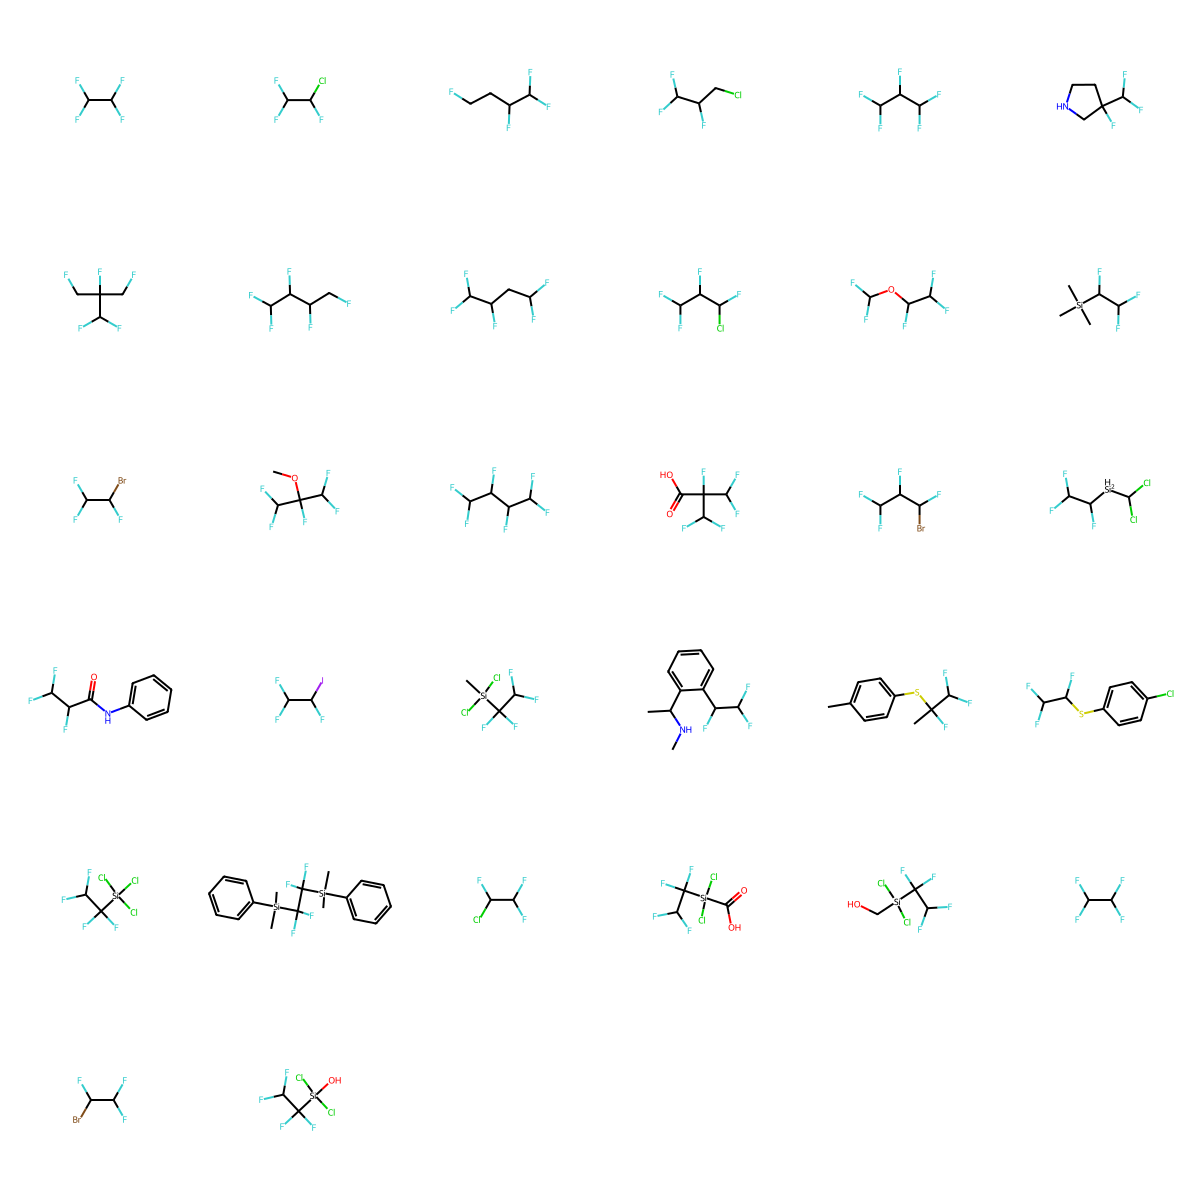

In [24]:
MolsToGridImage([Chem.MolFromSmiles(e) for e in universe_df[universe_df['category'] == 'Not PFAS']['smiles'].tolist()], molsPerRow = 6)

In [49]:
new_index = range(0, len(universe_df))

In [50]:
universe_df = universe_df.set_index(pd.Index(new_index))

In [52]:
for index in universe_df.index:
    if universe_df.loc[index, 'dtxsid' ] in  not_pfas2:
        universe_df.loc[index, 'category'] = 'Other aliphatics'

In [53]:
for index in universe_df.index:
    if universe_df.loc[index, 'dtxsid' ] in  not_pfas_si:
        universe_df.loc[index, 'category'] = 'Silicon PFASs'

In [54]:
universe_df.category.value_counts(dropna = False)

Other aliphatics                 8442
Side-chain aromatics             3794
unclassified                      787
Fluorotelomer PFAA precursors     578
PFAAs                             554
Silicon PFASs                     488
Non-PFAA perfluoroalkyls          272
FASA based PFAA precursors        204
PFAS derivatives                  149
PFAA precursors                   145
Unable to open ring(s)              2
Name: category, dtype: int64

In [55]:
universe_df[universe_df['category'] == 'Unable to open ring(s)']

dtxsid DSSTox_QC-Level  \
3170  DTXSID20519826      Public_Low   
4903  DTXSID00531243      Public_Low   

                                         Substance_Name Substance_CASRN  \
3170               Bis(pentafluoroethyl)thiadiaziridine      87999-39-1   
4903  4,5-Bis(pentafluoroethyl)-1,2,3,4,5-trithiadia...      87985-86-2   

       Substance_Type                                 smiles  \
3170  Single Compound    FC(F)(F)C(F)(F)N1SN1C(F)(F)C(F)(F)F   
4903  Single Compound  FC(F)(F)C(F)(F)N1SSSN1C(F)(F)C(F)(F)F   

                                        Structure_InChI  \
3170  InChI=1S/C4F10N2S/c5-1(6,7)3(11,12)15-16(17-15...   
4903  InChI=1S/C4F10N2S3/c5-1(6,7)3(11,12)15-16(18-1...   

               Structure_InChIKey Structure_Formula  Structure_MolWt  ...  \
3170  IVSMGIULXPTAQV-UHFFFAOYSA-N          C4F10N2S           298.10  ...   
4903  OTHNRDIUUJSYIT-UHFFFAOYSA-N         C4F10N2S3           362.22  ...   

     AD_WS AD_index_WS Conf_index_WS  LogHL_pred   HL_predRange  AD_HL  \
3170   1.0       0.551         0.456       -3.80  [-5.25:-1.43]    0.0   
4903   1.0       0.505         0.407       -3.28  [-5.25:-0.93]    0.0   

      AD_index_HL Conf_index_HL   ID  tsca_match  
3170        0.338         0.334  NaN         NaN  
4903        0.301         0.314  NaN         NaN  

[2 rows x 48 columns]

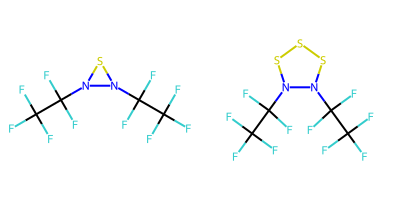

In [57]:
MolsToGridImage([Chem.MolFromSmiles(e) for e in universe_df[universe_df['category'] == 'Unable to open ring(s)']['smiles'].tolist()], molsPerRow = 2)

In [58]:
def subcategory(row):
    if row['chain_length'] >= 7:
        return 'gte7'
    else:
        return 'lt7'

In [59]:
universe_df['subcategory'] = universe_df.apply(lambda row: subcategory(row), axis =1)


In [62]:
universe_df[universe_df['chain_length'].isnull()][['dtxsid', 'smiles','subcategory', 'chain_length']]

dtxsid                                             smiles  \
4999   DTXSID301146476     CC[N](CC)(CC)(CC(F)(F)C(F)F)OS(=O)(=O)C(F)(F)F   
12435   DTXSID20153820  OOOOOOOOOOOOOOOC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...   

      subcategory  chain_length  
4999          lt7           NaN  
12435         lt7           NaN

[10:54:58] Explicit valence for atom # 2 N, 5, is greater than permitted


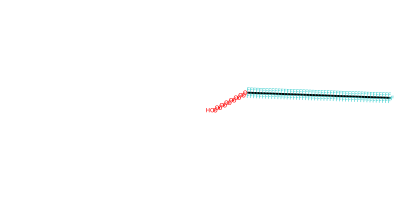

In [63]:
MolsToGridImage([Chem.MolFromSmiles(e) for e in universe_df[universe_df['chain_length'].isnull()]['smiles'].tolist()], molsPerRow = 2)

In [64]:
for index in universe_df.index:
    if universe_df.loc[index, 'dtxsid' ] == 'DTXSID20153820':
        universe_df.loc[index, 'chain_length'] = 47

In [65]:
universe_df['subcategory'] = universe_df.apply(lambda row: subcategory(row), axis =1)

In [66]:
universe_df[universe_df['chain_length'].isnull()][['dtxsid', 'smiles','subcategory', 'chain_length']]

dtxsid                                          smiles  \
4999  DTXSID301146476  CC[N](CC)(CC)(CC(F)(F)C(F)F)OS(=O)(=O)C(F)(F)F   

     subcategory  chain_length  
4999         lt7           NaN

In [67]:
universe_df[universe_df['chain_length']==47][['dtxsid', 'smiles','subcategory', 'chain_length']]

dtxsid                                             smiles  \
12435  DTXSID20153820  OOOOOOOOOOOOOOOC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...   

      subcategory  chain_length  
12435        gte7          47.0

Removing substance which can not be resolved by RDKit

In [69]:
universe_df = universe_df[universe_df['dtxsid'] != 'DTXSID301146476']

PFAS Inventory now contains 15,414 substances of which 2959 are degradates arising from TSCA substances and 15,092 could be address by OPERA

In [70]:
universe_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15414 entries, 0 to 15414
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dtxsid                    15414 non-null  object 
 1   DSSTox_QC-Level           12455 non-null  object 
 2   Substance_Name            12455 non-null  object 
 3   Substance_CASRN           12455 non-null  object 
 4   Substance_Type            12455 non-null  object 
 5   smiles                    15414 non-null  object 
 6   Structure_InChI           12455 non-null  object 
 7   Structure_InChIKey        12455 non-null  object 
 8   Structure_Formula         12455 non-null  object 
 9   Structure_MolWt           12455 non-null  float64
 10  Structure_SMILES_2D-QSAR  8617 non-null   object 
 11  Canonical_QSARr           12202 non-null  object 
 12  TSCA_STATUS               15414 non-null  object 
 13  chain_length              15414 non-null  float64
 14  catego

In [71]:
universe_df.category.value_counts(dropna = False)

Other aliphatics                 8442
Side-chain aromatics             3794
unclassified                      786
Fluorotelomer PFAA precursors     578
PFAAs                             554
Silicon PFASs                     488
Non-PFAA perfluoroalkyls          272
FASA based PFAA precursors        204
PFAS derivatives                  149
PFAA precursors                   145
Unable to open ring(s)              2
Name: category, dtype: int64

In [72]:
universe_df.groupby(['category', 'subcategory']).size().sort_values(ascending = False)

category                       subcategory
Other aliphatics               lt7            6352
Side-chain aromatics           lt7            3222
Other aliphatics               gte7           2090
Side-chain aromatics           gte7            572
unclassified                   lt7             466
PFAAs                          lt7             378
Silicon PFASs                  lt7             377
unclassified                   gte7            320
Fluorotelomer PFAA precursors  gte7            312
                               lt7             266
Non-PFAA perfluoroalkyls       lt7             223
PFAAs                          gte7            176
PFAS derivatives               lt7             149
Silicon PFASs                  gte7            111
FASA based PFAA precursors     gte7            106
                               lt7              98
PFAA precursors                lt7              88
                               gte7             57
Non-PFAA perfluoroalkyls       gte7    

In [73]:
new = universe_df.groupby(['category', 'subcategory']).size().reset_index()
new['percentage'] = new[0].apply(lambda x: x/universe_df.shape[0])
new

category subcategory     0  percentage
0      FASA based PFAA precursors        gte7   106    0.006877
1      FASA based PFAA precursors         lt7    98    0.006358
2   Fluorotelomer PFAA precursors        gte7   312    0.020241
3   Fluorotelomer PFAA precursors         lt7   266    0.017257
4        Non-PFAA perfluoroalkyls        gte7    49    0.003179
5        Non-PFAA perfluoroalkyls         lt7   223    0.014467
6                Other aliphatics        gte7  2090    0.135591
7                Other aliphatics         lt7  6352    0.412093
8                 PFAA precursors        gte7    57    0.003698
9                 PFAA precursors         lt7    88    0.005709
10                          PFAAs        gte7   176    0.011418
11                          PFAAs         lt7   378    0.024523
12               PFAS derivatives         lt7   149    0.009667
13           Side-chain aromatics        gte7   572    0.037109
14           Side-chain aromatics         lt7  3222    0.209031
15                  Silicon PFASs        gte7   111    0.007201
16                  Silicon PFASs         lt7   377    0.024458
17         Unable to open ring(s)         lt7     2    0.000130
18                   unclassified        gte7   320    0.020760
19                   unclassified         lt7   466    0.030232

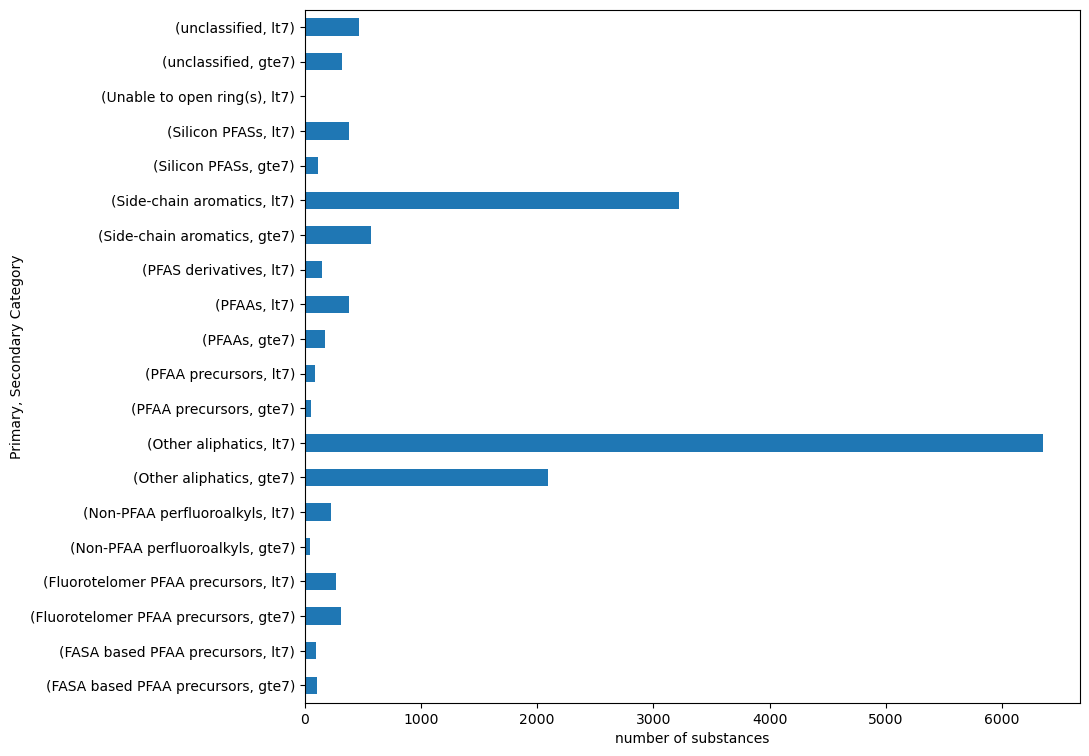

In [75]:
plt.figure(figsize = (10,9))
universe_df.groupby(['category', 'subcategory']).size().plot.barh()
plt.ylabel('Primary, Secondary Category')
plt.xlabel('number of substances')
plt.savefig(figures_dir+'Figure1_061123.png', dpi = 300, bbox_inches='tight');


In [77]:
universe_df[universe_df['smiles'].isnull()]

Empty DataFrame
Columns: [dtxsid, DSSTox_QC-Level, Substance_Name, Substance_CASRN, Substance_Type, smiles, Structure_InChI, Structure_InChIKey, Structure_Formula, Structure_MolWt, Structure_SMILES_2D-QSAR, Canonical_QSARr, TSCA_STATUS, chain_length, category, MolWeight, LogP_pred, LogP_predRange, AD_LogP, AD_index_LogP, Conf_index_LogP, MP_pred, MP_predRange, AD_MP, AD_index_MP, Conf_index_MP, BP_pred, BP_predRange, AD_BP, AD_index_BP, Conf_index_BP, LogVP_pred, VP_predRange, AD_VP, AD_index_VP, Conf_index_VP, LogWS_pred, WS_predRange, AD_WS, AD_index_WS, Conf_index_WS, LogHL_pred, HL_predRange, AD_HL, AD_index_HL, Conf_index_HL, ID, tsca_match, subcategory]
Index: []

[0 rows x 49 columns]

In [78]:
results = {}
for i, group in universe_df.groupby(['category', 'subcategory']):
    try:
        a = mk_fp(group)
    except Exception as error:
        print(error)
    else:
        results[i] = a


[11:42:21] WARNING: not removing hydrogen atom without neighbors


In [79]:
len(list(results.keys()))

20

In [80]:
distances = {}
for k,v in results.items():
    a = distance_matrix(results[k])
    distances[k] = a

In [81]:
universe_df['cluster'] = universe_df[['category', 'subcategory']].apply(tuple, axis = 1)

In [82]:
centres = []
for i,group in universe_df.groupby(['category', 'subcategory']):
    try:
        m = medoid_calc(distances[i])
        centres.append(m)
    except Exception as error:
        print(error)

In [83]:
len(centres)

20

In [84]:
universe_df['cluster_centroid'] = universe_df['dtxsid'].apply(lambda x: 'centroid' if x in (centres) else np.nan)

In [85]:
df2 = universe_df.set_index('dtxsid')

Create dictionary of the distances so we can compute the pairwise distance from the given centroid of each category-subcategory combination

In [86]:
members = {}

for i, group in df2.groupby(['category', 'subcategory']):
    subset = group[['cluster', 'cluster_centroid']]
    #print(subset)
    try: 
        for x, y in subset.iterrows():
            a, b = y
            if b == 'centroid':
                #print(x)
                c = [distances[i][x].index, distances[i][x].values]
                members[x] = c
    except Exception as error:
            print(error)


In [87]:
cluster_members = pd.DataFrame(list(members.items()))

In [88]:
cluster_members.columns = ['centroid', 1]
cluster_members[['analogues','Dist']] = pd.DataFrame(cluster_members[1].tolist(), index= cluster_members.index)
cluster_members.drop([1], axis = 1, inplace = True)
cluster_members2 = cluster_members.apply(pd.Series.explode)

In [89]:
cluster_members2.head(10)

centroid        analogues      Dist
0  DTXSID6071908    DTXSID8071358      0.64
0  DTXSID6071908    DTXSID1071907  0.615385
0  DTXSID6071908  DTXSID001026645  0.660714
0  DTXSID6071908  DTXSID301026644  0.592593
0  DTXSID6071908    DTXSID6071665  0.509804
0  DTXSID6071908    DTXSID1067629      0.64
0  DTXSID6071908  DTXSID801033084  0.408163
0  DTXSID6071908    DTXSID1071662     0.375
0  DTXSID6071908    DTXSID1032646  0.615385
0  DTXSID6071908    DTXSID6071908       0.0

In [90]:
cluster_members2.centroid.nunique()

20

In [91]:
df_1 = universe_df.sort_values(by = ['category', 'subcategory', 'cluster', 'cluster_centroid'], ascending = [True, True,True, False])
df_1['centroid'] = df_1.apply(lambda x: x['dtxsid'] if x['cluster_centroid'] == 'centroid' else np.nan, axis = 1)

In [92]:
df_1['centroid2'] = df_1['centroid'].fillna(method = 'ffill')

In [93]:
mydict = {}
for i, group in df_1.groupby('centroid2'):
    k = [n for n in group['centroid2'] if n != ' '][0]
    v = list(group['dtxsid'])
    mydict[k] = v

In [94]:
dist = []
for i, group in cluster_members2.groupby('centroid'):
    a = cluster_members2[(cluster_members2['centroid'] == i) & (cluster_members2['analogues'].isin(mydict[i]))]
    dist.append(a)

In [95]:
dist_df = pd.concat([e for e in dist])

In [96]:
final_df = pd.merge(df_1, dist_df, left_on = 'dtxsid', right_on = 'analogues', how = 'left')

In [97]:
final_df.head()

dtxsid DSSTox_QC-Level  \
0    DTXSID6071908     DSSTox_High   
1    DTXSID8071358     DSSTox_High   
2    DTXSID1071907     DSSTox_High   
3  DTXSID001026645      DSSTox_Low   
4  DTXSID301026644      DSSTox_Low   

                                      Substance_Name Substance_CASRN  \
0  N-Ethyl-N-((pentadecafluoroheptyl)sulphonyl)gl...      68957-63-1   
1            N-Methyl-perfluoro-1-heptanesulfonamide      68259-14-3   
2        N-Ethylpentadecafluoro-1-heptanesulfonamide      68957-62-0   
3  1,1,2,2,3,3,4,4,5,5,6,6,7,7,7-Pentadecafluoro-...     167398-54-1   
4        (Perfluoroheptyl)(sulfonylamino)acetic acid    1003194-00-0   

    Substance_Type                                             smiles  \
0  Single Compound  CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...   
1  Single Compound  CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...   
2  Single Compound  CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...   
3  Single Compound  OCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...   
4  Single Compound  OC(=O)CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...   

                                     Structure_InChI  \
0  InChI=1S/C11H8F15NO4S/c1-2-27(3-4(28)29)32(30,...   
1  InChI=1S/C8H4F15NO2S/c1-24-27(25,26)8(22,23)6(...   
2  InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...   
3  InChI=1S/C9H6F15NO3S/c10-3(11,4(12,13)6(16,17)...   
4  InChI=1S/C9H4F15NO4S/c10-3(11,4(12,13)6(16,17)...   

            Structure_InChIKey Structure_Formula  Structure_MolWt  ...   ID  \
0  IOQHTIQMCISFKB-UHFFFAOYSA-N      C11H8F15NO4S           535.22  ...  NaN   
1  KDHCALLFPWZTPN-UHFFFAOYSA-N       C8H4F15NO2S           463.16  ...  NaN   
2  WMOMXEHEPXLIAV-UHFFFAOYSA-N       C9H6F15NO2S           477.19  ...  NaN   
3  LJJUSVBJKZXMCP-UHFFFAOYSA-N       C9H6F15NO3S           493.19  ...  NaN   
4  LAAXCIZXZCKWFF-UHFFFAOYSA-N       C9H4F15NO4S           507.17  ...  NaN   

  tsca_match subcategory                             cluster cluster_centroid  \
0        NaN        gte7  (FASA based PFAA precursors, gte7)         centroid   
1        NaN        gte7  (FASA based PFAA precursors, gte7)              NaN   
2        NaN        gte7  (FASA based PFAA precursors, gte7)              NaN   
3        NaN        gte7  (FASA based PFAA precursors, gte7)              NaN   
4        NaN        gte7  (FASA based PFAA precursors, gte7)              NaN   

      centroid_x      centroid2     centroid_y        analogues      Dist  
0  DTXSID6071908  DTXSID6071908  DTXSID6071908    DTXSID6071908       0.0  
1            NaN  DTXSID6071908  DTXSID6071908    DTXSID8071358      0.64  
2            NaN  DTXSID6071908  DTXSID6071908    DTXSID1071907  0.615385  
3            NaN  DTXSID6071908  DTXSID6071908  DTXSID001026645  0.660714  
4            NaN  DTXSID6071908  DTXSID6071908  DTXSID301026644  0.592593  

[5 rows x 56 columns]

In [99]:
writer = pd.ExcelWriter(interim_dir+'secondary_categorisations_new_universe_061123.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

final_df.to_excel(writer)

writer.close()


Deriving an objective threshold to decide when a category-subcategory needs to be clustered to its next generation of subclusters

In [100]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import inconsistent

In [101]:
from itertools import permutations, combinations

In [102]:
perm = combinations(list(distances.keys()), 2)

In [103]:
perm_combs = []
for i in list(perm):
    perm_combs.append(i)

In [104]:
perm_combs = list(set(perm_combs))

In [105]:
len(perm_combs)

190

In [106]:
perm_combs2 = [(a,b) for a, b in perm_combs if a[0] != b[0]]
len(perm_combs2)

181

In [107]:
results_dict = {}
for i in perm_combs2:
    x, y = i
    a = pd.concat([results[x], results[y]])
    results_dict[i] = a

In [108]:
distance_dict = {}
for k, v in results_dict.items():
    distance_dict[k] = pd.DataFrame(squareform(pdist(results_dict[k], 'Jaccard')), columns = results_dict[k].index, index =results_dict[k].index)

In [109]:
df_dict = {}
for k,v in distance_dict.items():
    x, y = k
    df = distance_dict[k]
    for i in df.index:
        for c in df.columns:
            if i in results[x].index and c in results[x].index:
                df.loc[i,c] = np.nan
            if i in results[y].index and c in results[y].index:
                df.loc[i,c] = np.nan
    df_dict[k] = df


In [110]:
summaries_bt = []
for k,v in df_dict.items():
      summaries_bt.append(plug_in_stack(df_dict[k], label = k))


In [111]:
len(summaries_bt)

181

In [112]:
len(df_dict)

181

In [113]:
summaries = []
for k,v in distances.items():
    if len(v)  >1:
        summaries.append(plug_in(distances[k], label = k))

/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:1711: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


In [114]:
import pickle
pickle.dump( summaries, open(interim_dir+ "within_cat_chl7_061123.pkl", "wb" ) )
pickle.dump( summaries_bt, open(interim_dir+ "between_cat_chl7_061123.pkl", "wb" ) )


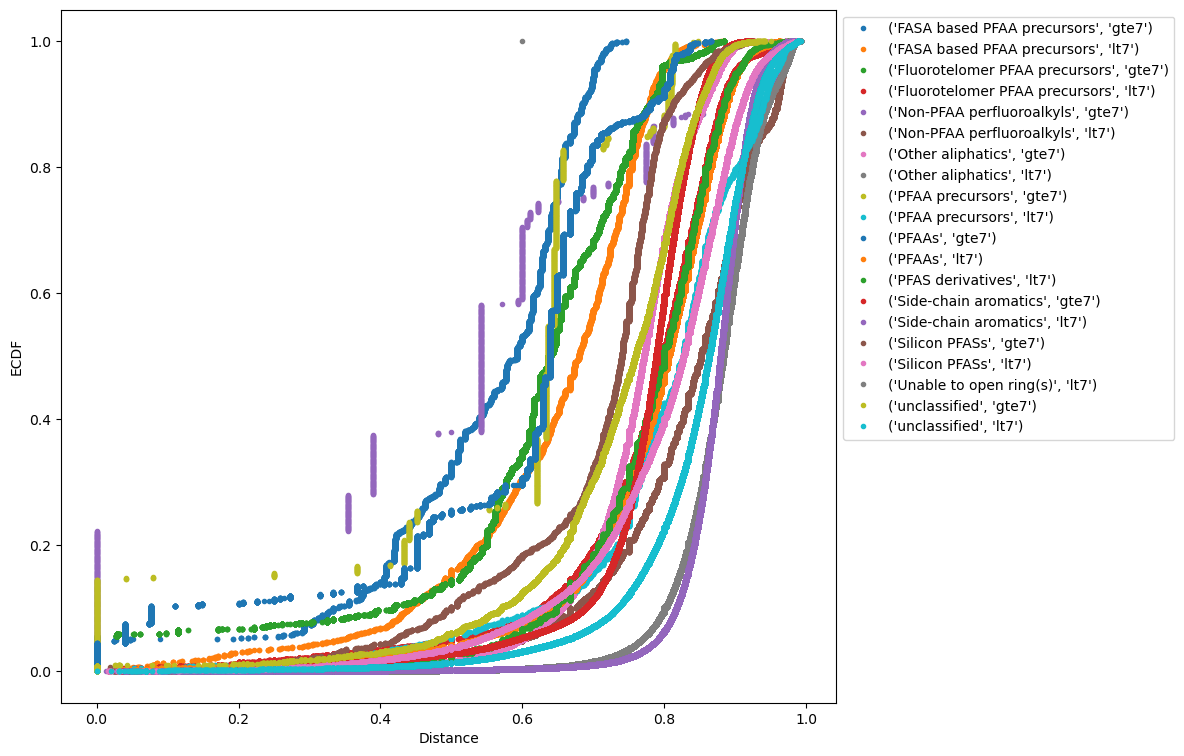

In [115]:
fig, ax = plt.subplots(figsize = (10,9))
for i in range(len(summaries)):
    ax.set_xlabel('Distance')
    ax.set_ylabel('ECDF')
    #ax.set_title('ECDFs of within Category-Subcategory combinations')
    ax.plot(summaries[i]['ecdfx'],summaries[i]['ecdfy'], marker = '.', linestyle = 'none', label = summaries[i]['label'])
    ax.legend(bbox_to_anchor=(1, 1))
    #ax.annotate(" ", xy = (0.65,0.8), xytext = (0.5, 0.8), arrowprops = dict(arrowstyle = '->', lw = 2, color = 'black'))
    #ax.annotate(" ", xy = (1,0.2), xytext = (0.85, 0.2), arrowprops = dict(arrowstyle = '<-', lw = 2, color = 'black'))
fig.savefig(figures_dir+'FigureS1_061123.png', dpi = 300, bbox_inches='tight')

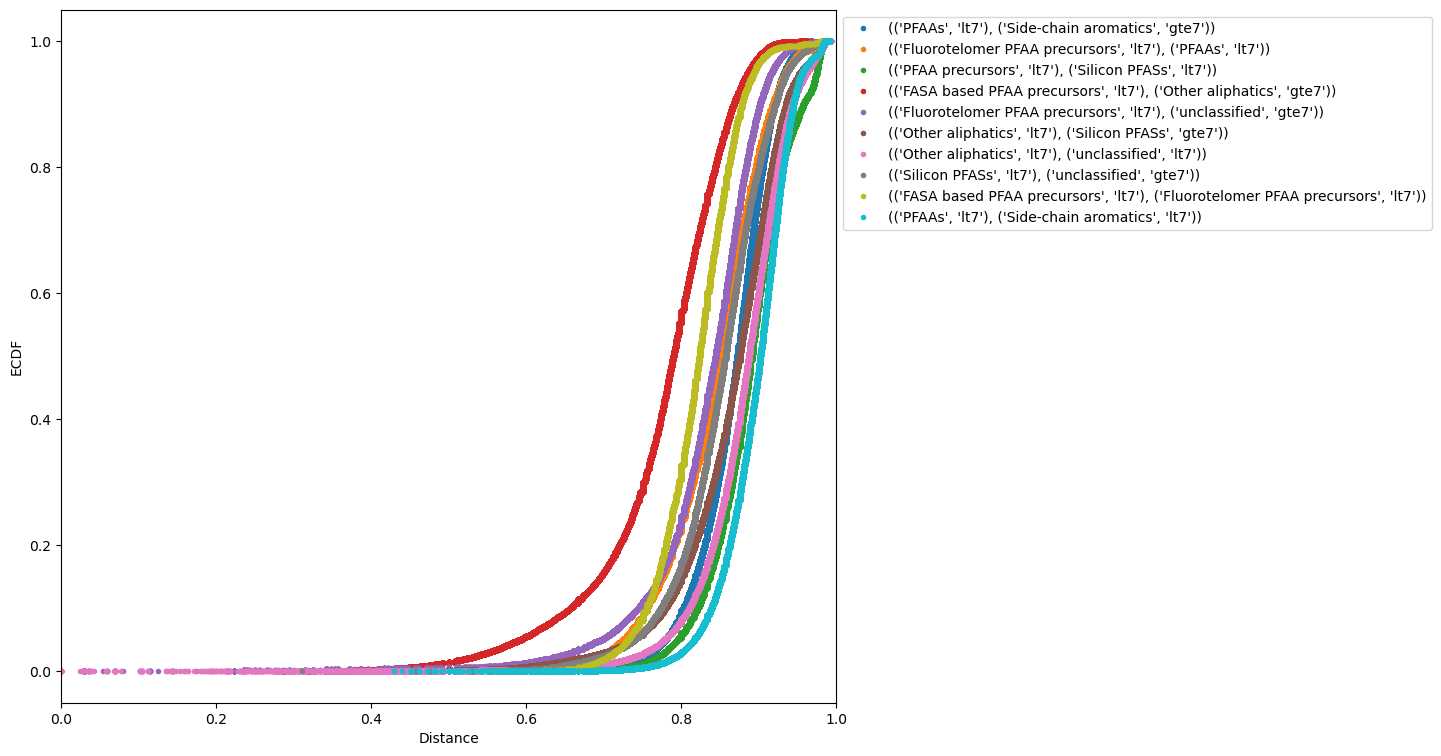

In [116]:
fig, ax = plt.subplots(figsize = (10,9))
for i in range(len(summaries_bt))[0:10]:
    ax.set_xlabel('Distance')
    ax.set_ylabel('ECDF')
    #ax.set_title('ECDFs of selected between Category-Subcategory combinations')
    ax.plot(summaries_bt[i]['ecdfx'],summaries_bt[i]['ecdfy'], marker = '.', linestyle = 'none', label = summaries_bt[i]['label']);
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlim([0,1])
fig.savefig(figures_dir+'FigureS2_061123.png', dpi = 300, bbox_inches='tight')

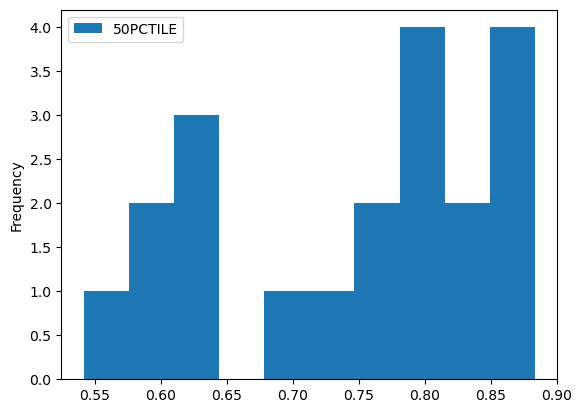

In [117]:
dist_thresholds = []
for i in range(0, len(summaries)):
    a, b  = summaries[i]['label'], summaries[i]['50PCTILE']
    dist_thresholds.append([a,b])


dist_thresholds = pd.DataFrame(dist_thresholds, columns = ['label', '50PCTILE'])

dist_thresholds.plot(kind = 'hist', bins = 10);


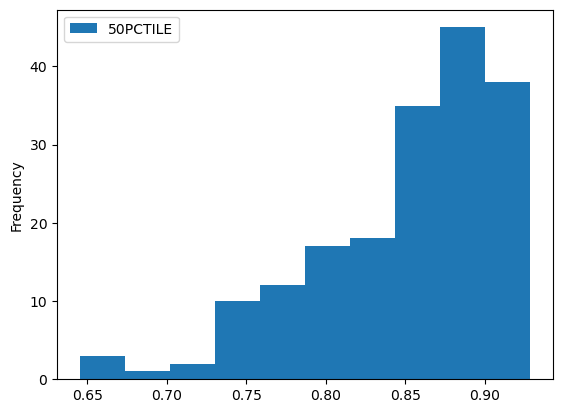

In [118]:
distb_thresholds = []
for i in range(0, len(summaries_bt)):
    a, b  = summaries_bt[i]['label'], summaries_bt[i]['50PCTILE']
    distb_thresholds.append([a,b])


distb_thresholds = pd.DataFrame(distb_thresholds, columns = ['label', '50PCTILE'])

distb_thresholds.plot(kind = 'hist', bins = 10);

In [119]:
defined_threshold = round(np.percentile(distb_thresholds['50PCTILE'],5),2)

In [120]:
defined_threshold

0.75

In [121]:
_thresholds = []
for i in range(0, len(summaries)):
    a, b  = summaries[i]['label'], summaries[i]['50PCTILE']
    _thresholds.append([a,b])


_thresholds = pd.DataFrame(_thresholds, columns = ['label', '50PCTILE'])

In [122]:
above_threshold = _thresholds[_thresholds['50PCTILE'] >=defined_threshold]['label'].to_list()

In [123]:
len(above_threshold)

12

In [124]:
_thresholds[_thresholds['50PCTILE'] >=defined_threshold]

label  50PCTILE
3   (Fluorotelomer PFAA precursors, lt7)  0.800000
5        (Non-PFAA perfluoroalkyls, lt7)  0.851852
6               (Other aliphatics, gte7)  0.771429
7                (Other aliphatics, lt7)  0.883333
9                 (PFAA precursors, lt7)  0.826087
11                          (PFAAs, lt7)  0.806452
12               (PFAS derivatives, lt7)  0.800000
13          (Side-chain aromatics, gte7)  0.788732
14           (Side-chain aromatics, lt7)  0.879310
16                  (Silicon PFASs, lt7)  0.827160
18                  (unclassified, gte7)  0.759259
19                   (unclassified, lt7)  0.863636

In [125]:
_thresholds[_thresholds['50PCTILE'] >=defined_threshold].shape

(12, 2)

/tmp/ipykernel_1920478/2050803770.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distb_thresholds['50PCTILE'], kde = True, label = 'between')
/tmp/ipykernel_1920478/2050803770.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dist_thresholds['50PCTILE'], kde = True, label = 'within')


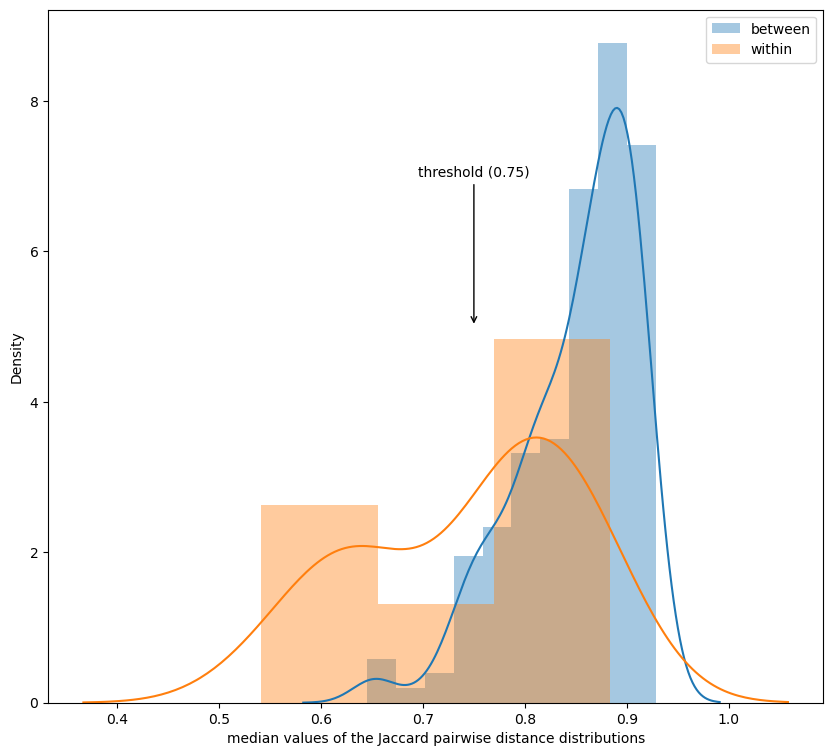

In [126]:
fig, ax = plt.subplots(figsize = (10,9))
sns.distplot(distb_thresholds['50PCTILE'], kde = True, label = 'between')
sns.distplot(dist_thresholds['50PCTILE'], kde = True, label = 'within')
#ax.set_title('Distributions of within and between cat-subcat distances')
#ax.text(0.78, 5, defined_threshold)
ax.annotate('threshold (0.75)', xy = (0.75,5), xytext = (0.75,7), horizontalalignment = 'center', arrowprops = dict(arrowstyle = '->', lw = 1))
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('median values of the Jaccard pairwise distance distributions')
fig.savefig(figures_dir+'Figure2_061123.png', dpi = 300, bbox_inches='tight')

Take the categories_subcategories that exceed the threshold and calculate their first generation clusters using hierarchical clustering

In [129]:
for i in range(len(summaries)):
    if summaries[i]['label'] in above_threshold:
        print(i, summaries[i]['label'])

3 ('Fluorotelomer PFAA precursors', 'lt7')
5 ('Non-PFAA perfluoroalkyls', 'lt7')
6 ('Other aliphatics', 'gte7')
7 ('Other aliphatics', 'lt7')
9 ('PFAA precursors', 'lt7')
11 ('PFAAs', 'lt7')
12 ('PFAS derivatives', 'lt7')
13 ('Side-chain aromatics', 'gte7')
14 ('Side-chain aromatics', 'lt7')
16 ('Silicon PFASs', 'lt7')
18 ('unclassified', 'gte7')
19 ('unclassified', 'lt7')


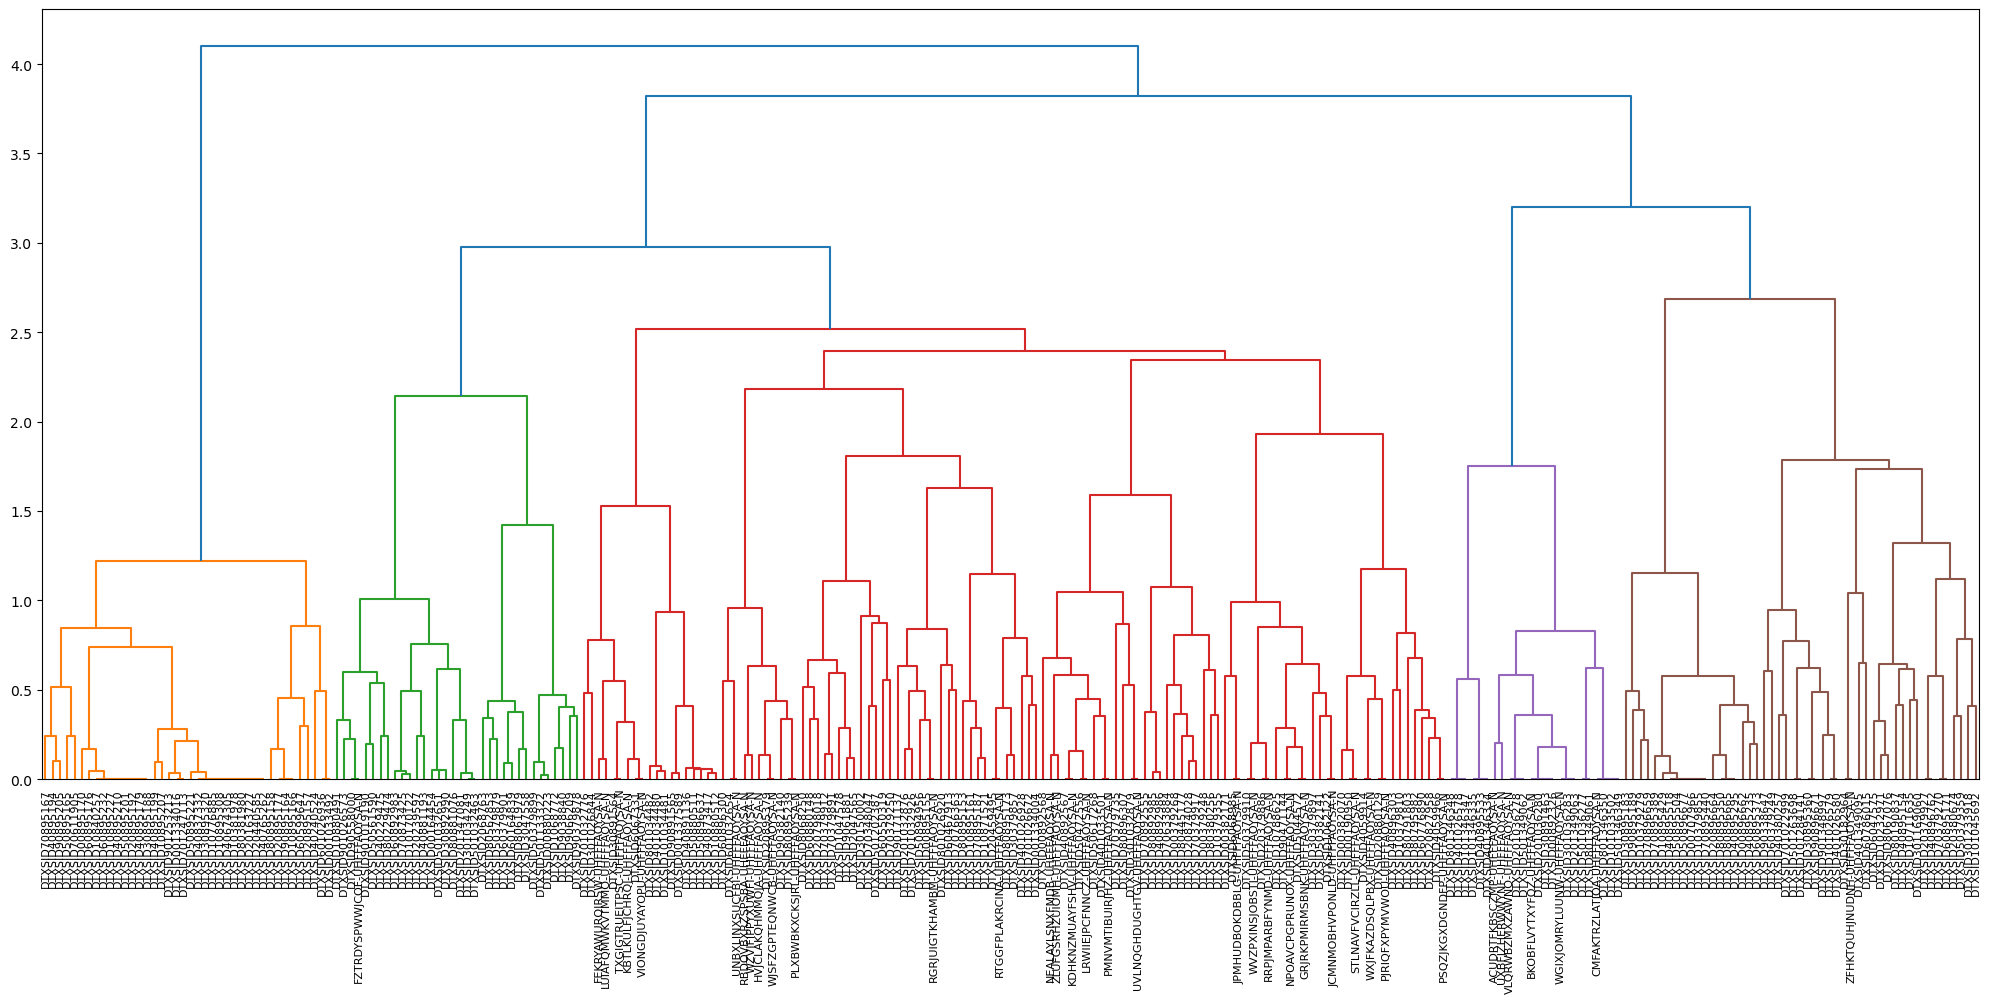

In [130]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries[3]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('Fluorotelomer PFAA precursors', 'lt7')].index# font size for the x axis labels
)
plt.show()


In [131]:
max_d = 3
clusters_dist = fcluster(summaries[3]['Z'], max_d, criterion='maxclust')
clusters_dist
dist_clusters = pd.DataFrame(list(zip(results[('Fluorotelomer PFAA precursors', 'lt7')].index, clusters_dist)), columns = ['dtxsid', 'cluster_d'])
dist_clusters['category'] = 'Fluorotelomer PFAA precursors'
dist_clusters['subcategory'] = 'lt7'
dist_clusters = dist_clusters[['dtxsid', 'cluster_d',  'category','subcategory']]


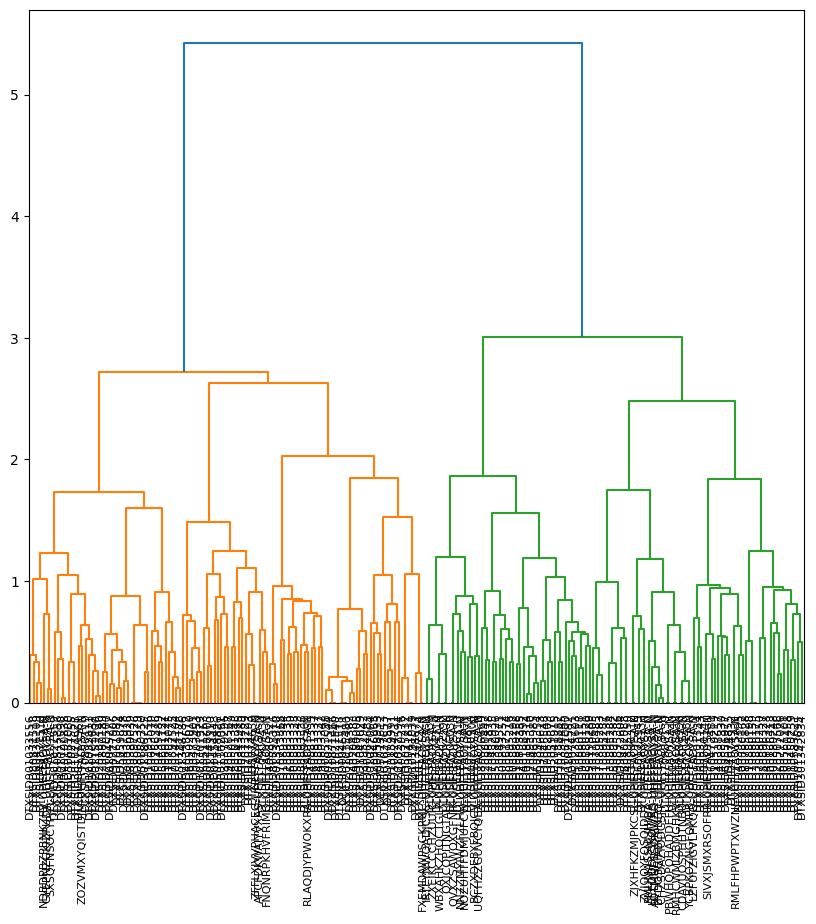

In [132]:
plt.figure(figsize=(10, 9))
dendrogram(
    summaries[5]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('Non-PFAA perfluoroalkyls', 'lt7')].index# font size for the x axis labels
)
plt.show()


In [133]:
max_d = 2
clusters_dist1 = fcluster(summaries[5]['Z'], max_d, criterion='maxclust')
clusters_dist1
dist_clusters1 = pd.DataFrame(list(zip(results[('Non-PFAA perfluoroalkyls', 'lt7')].index, clusters_dist1)), columns = ['dtxsid', 'cluster_d'])
dist_clusters1['category'] = 'Non-PFAA perfluoroalkyls'
dist_clusters1['subcategory'] = 'lt7'
dist_clusters1 = dist_clusters1[['dtxsid', 'cluster_d',  'category','subcategory']]

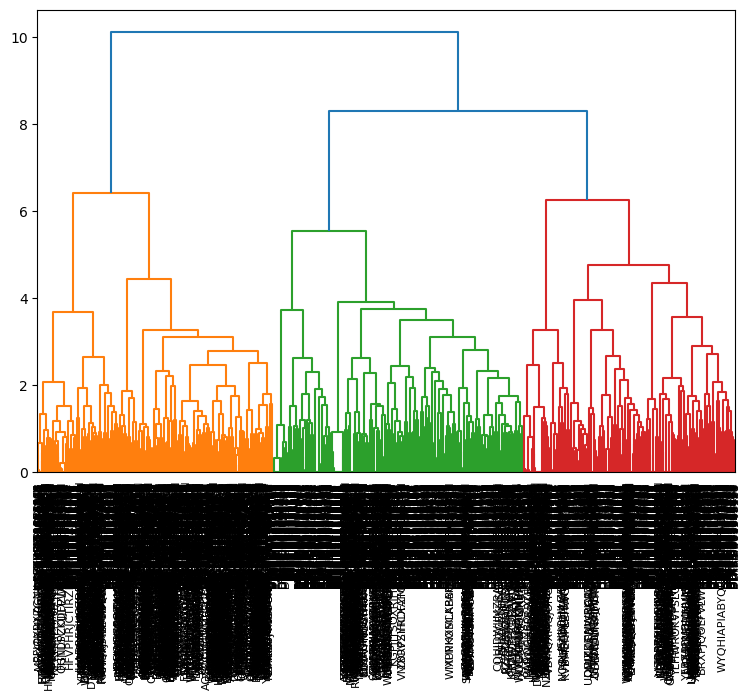

In [134]:
plt.figure(figsize=(9, 6))
dendrogram(
    summaries[6]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('Other aliphatics', 'gte7') ].index# font size for the x axis labels
)
plt.show()

In [135]:
max_d = 3
clusters_dist2 = fcluster(summaries[6]['Z'], max_d, criterion='maxclust')
clusters_dist2
dist_clusters2 = pd.DataFrame(list(zip(results[('Other aliphatics', 'gte7') ].index, clusters_dist2)), columns = ['dtxsid', 'cluster_d'])
dist_clusters2['category'] = 'Other aliphatics'
dist_clusters2['subcategory'] = 'gte7'
dist_clusters2 = dist_clusters2[['dtxsid', 'cluster_d',  'category','subcategory']]



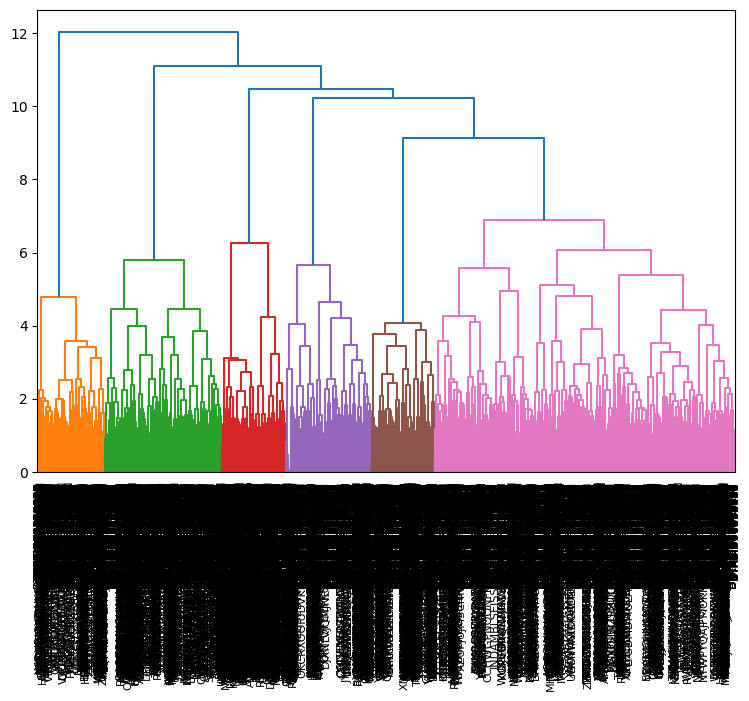

In [136]:
plt.figure(figsize=(9, 6))
dendrogram(
    summaries[7]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('Other aliphatics', 'lt7')].index# font size for the x axis labels
)
plt.show()

In [137]:
max_d = 3
clusters_dist3 = fcluster(summaries[7]['Z'], max_d, criterion='maxclust')
clusters_dist3
dist_clusters3 = pd.DataFrame(list(zip(results[('Other aliphatics', 'lt7')].index, clusters_dist3)), columns = ['dtxsid', 'cluster_d'])
dist_clusters3['category'] = 'Other aliphatics'
dist_clusters3['subcategory'] = 'lt7'
dist_clusters3 = dist_clusters3[['dtxsid', 'cluster_d',  'category','subcategory']]


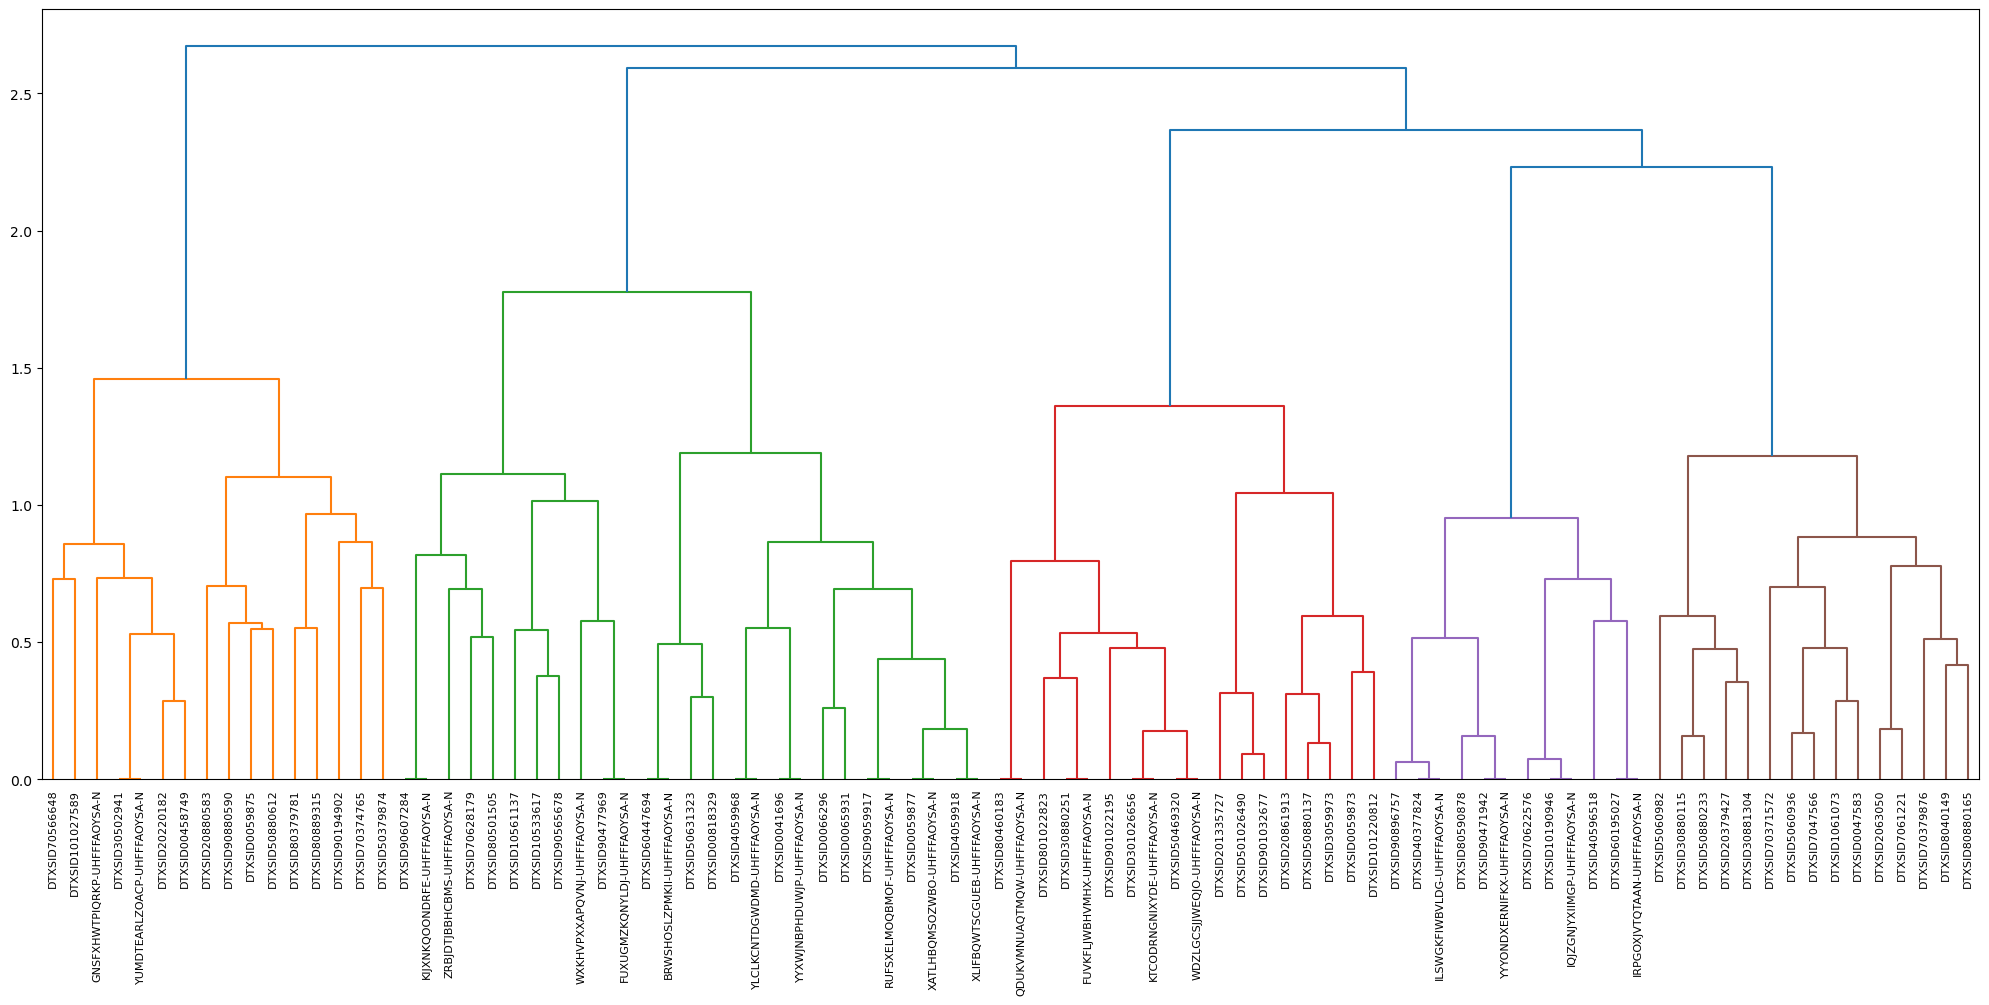

In [138]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries[9]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('PFAA precursors', 'lt7')].index# font size for the x axis labels
)
plt.show()

In [139]:
max_d = 3
clusters_dist4 = fcluster(summaries[9]['Z'], max_d, criterion='maxclust')
clusters_dist4
dist_clusters4 = pd.DataFrame(list(zip(results[('PFAA precursors', 'lt7')].index, clusters_dist4)), columns = ['dtxsid', 'cluster_d'])
dist_clusters4['category'] = 'PFAA precursors'
dist_clusters4['subcategory'] = 'lt7'
dist_clusters4 = dist_clusters4[['dtxsid', 'cluster_d',  'category','subcategory']]

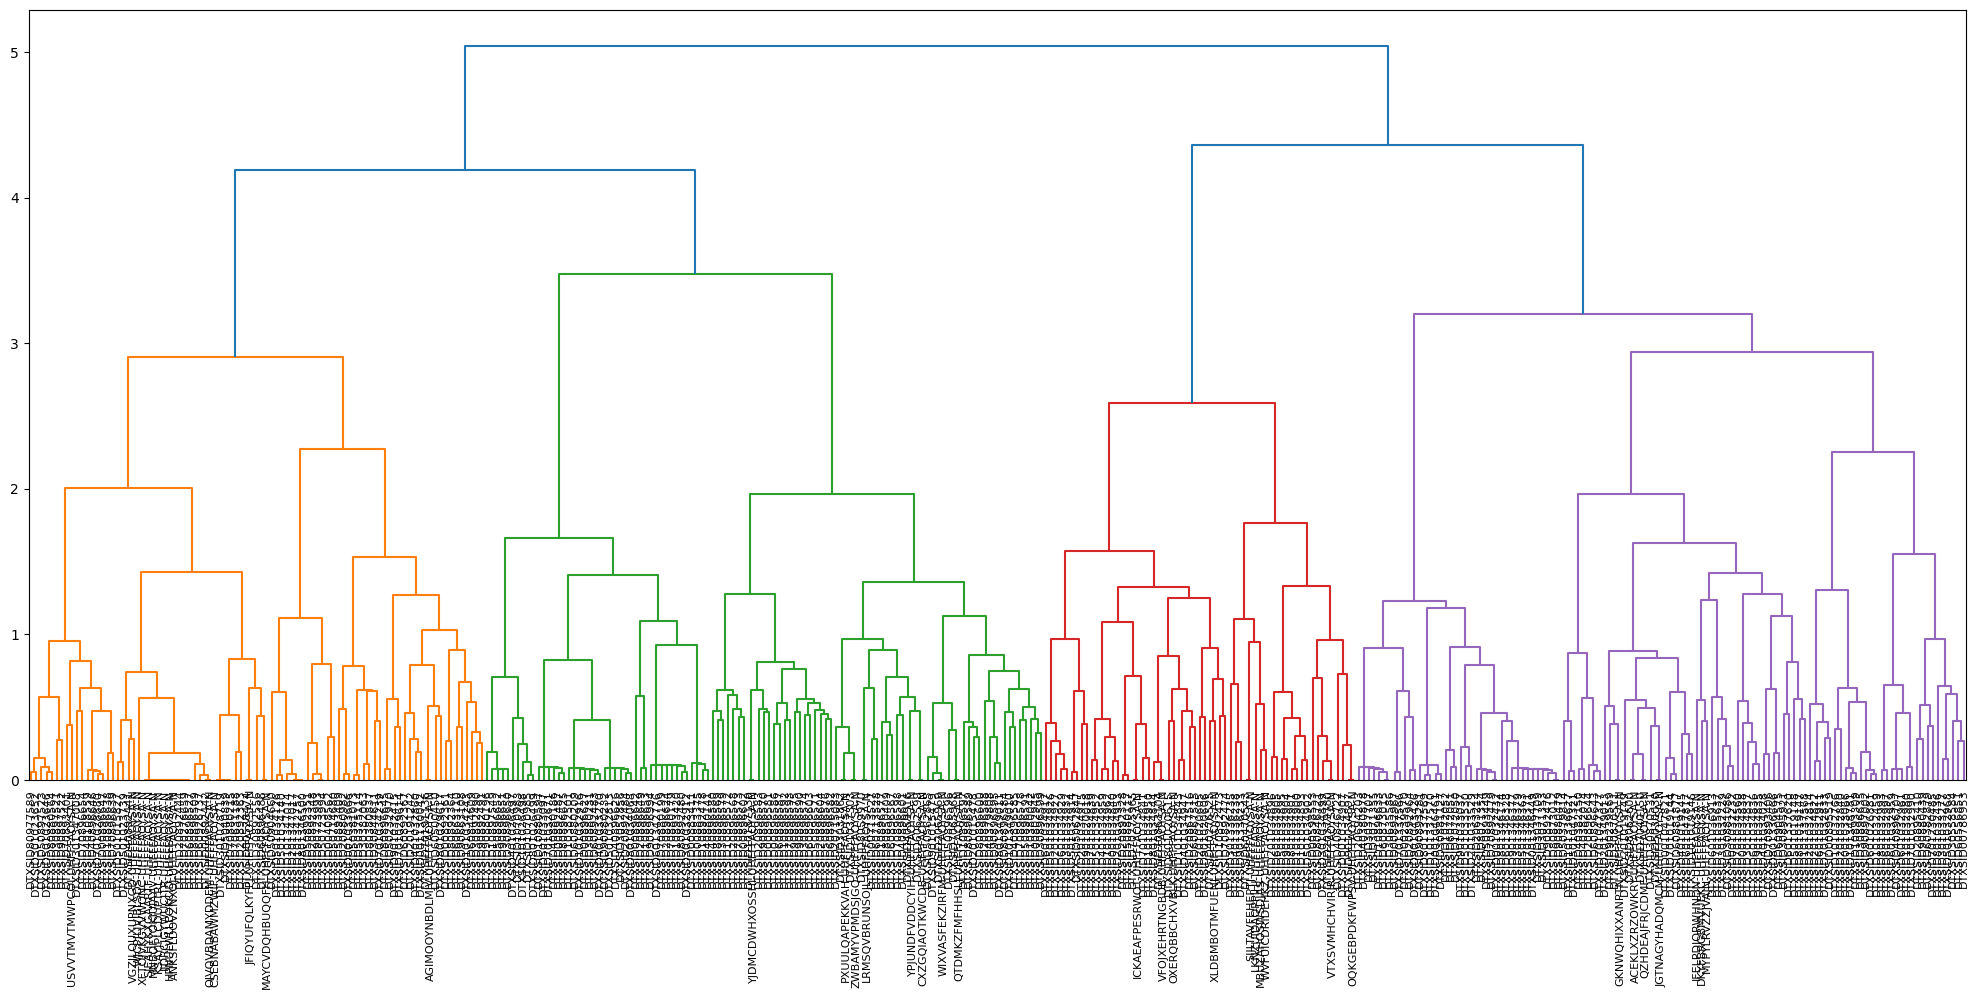

In [140]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries[11]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('PFAAs', 'lt7')].index# font size for the x axis labels
)
plt.show()

In [141]:
max_d = 4
clusters_dist5 = fcluster(summaries[11]['Z'], max_d, criterion='maxclust')
clusters_dist5
dist_clusters5 = pd.DataFrame(list(zip(results[('PFAAs', 'lt7')].index, clusters_dist5)), columns = ['dtxsid', 'cluster_d'])
dist_clusters5['category'] = 'PFAAs'
dist_clusters5['subcategory'] = 'lt7'
dist_clusters5 = dist_clusters5[['dtxsid', 'cluster_d',  'category','subcategory']]

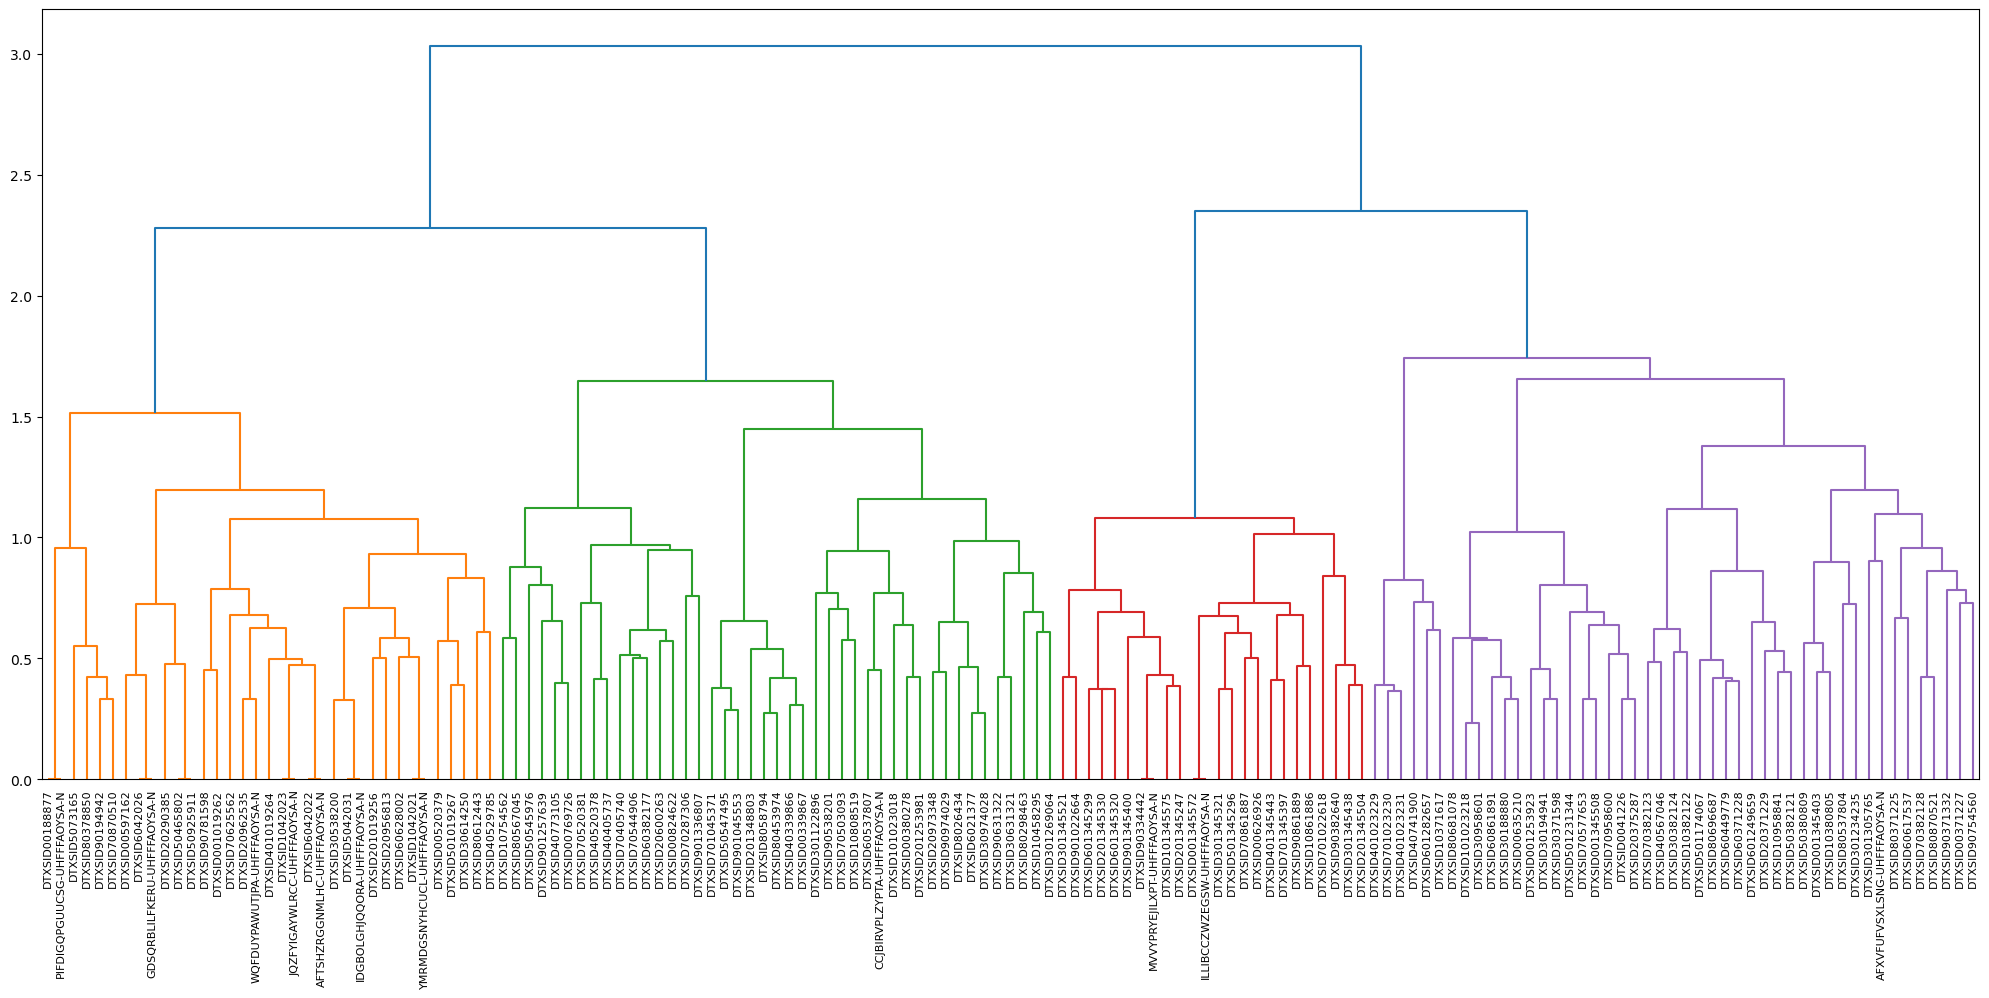

In [142]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries[12]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('PFAS derivatives', 'lt7')].index# font size for the x axis labels
)
plt.show()

In [143]:
max_d = 4
clusters_dist6 = fcluster(summaries[12]['Z'], max_d, criterion='maxclust')
clusters_dist6
dist_clusters6 = pd.DataFrame(list(zip(results[('PFAS derivatives', 'lt7')].index, clusters_dist6)), columns = ['dtxsid', 'cluster_d'])
dist_clusters6['category'] = 'PFAS derivatives'
dist_clusters6['subcategory'] = 'lt7'
dist_clusters6 = dist_clusters6[['dtxsid', 'cluster_d',  'category','subcategory']]

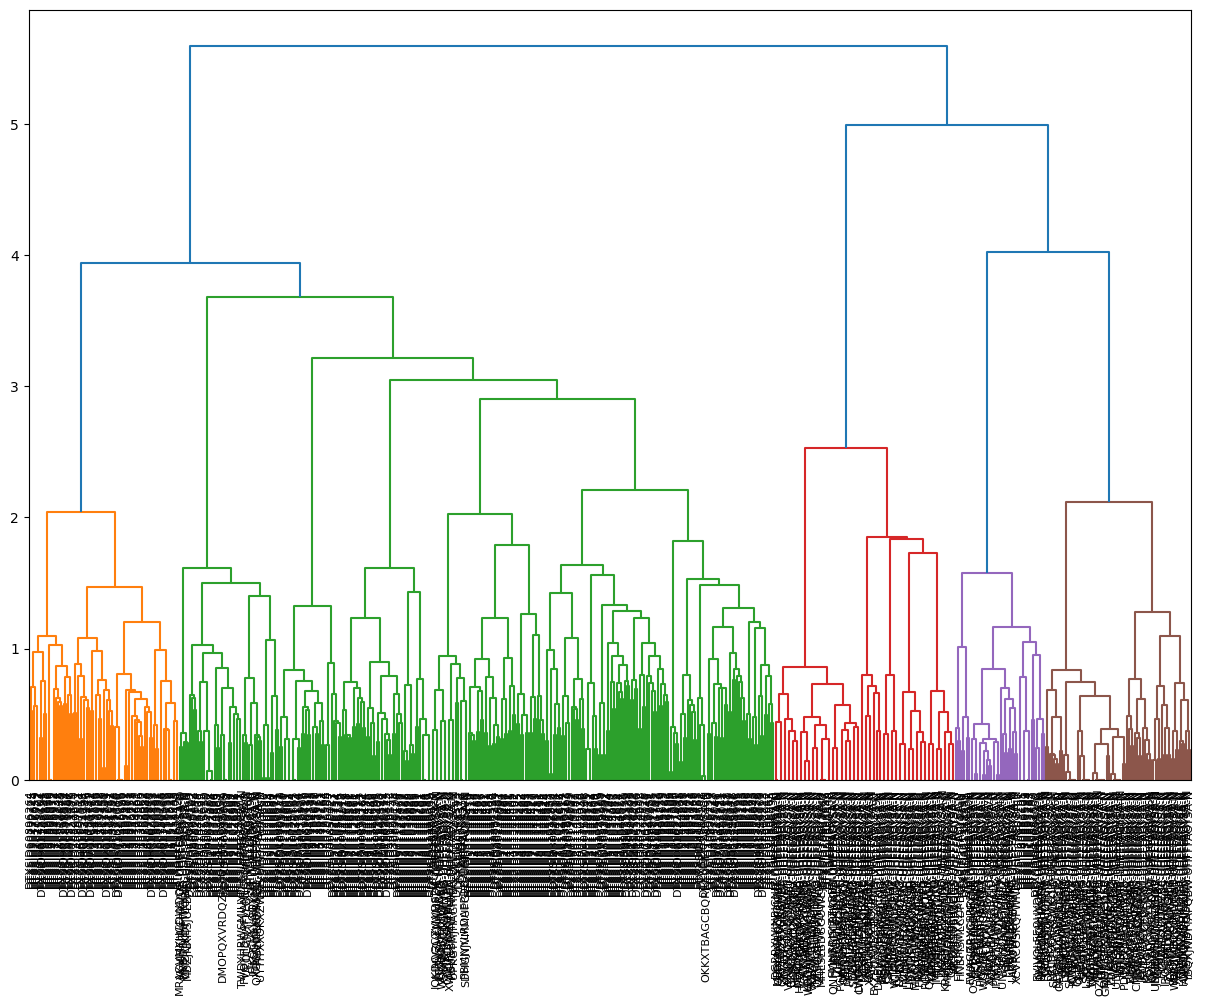

In [144]:
plt.figure(figsize=(15, 10))
dendrogram(
    summaries[13]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('Side-chain aromatics', 'gte7')].index# font size for the x axis labels
)
plt.show()

In [145]:
max_d = 3
clusters_dist7 = fcluster(summaries[13]['Z'], max_d, criterion='maxclust')
clusters_dist7
dist_clusters7 = pd.DataFrame(list(zip(results[('Side-chain aromatics', 'gte7')].index, clusters_dist7)), columns = ['dtxsid', 'cluster_d'])
dist_clusters7['category'] = 'Side-chain aromatics'
dist_clusters7['subcategory'] = 'gte7'
dist_clusters7 = dist_clusters7[['dtxsid', 'cluster_d',  'category','subcategory']]


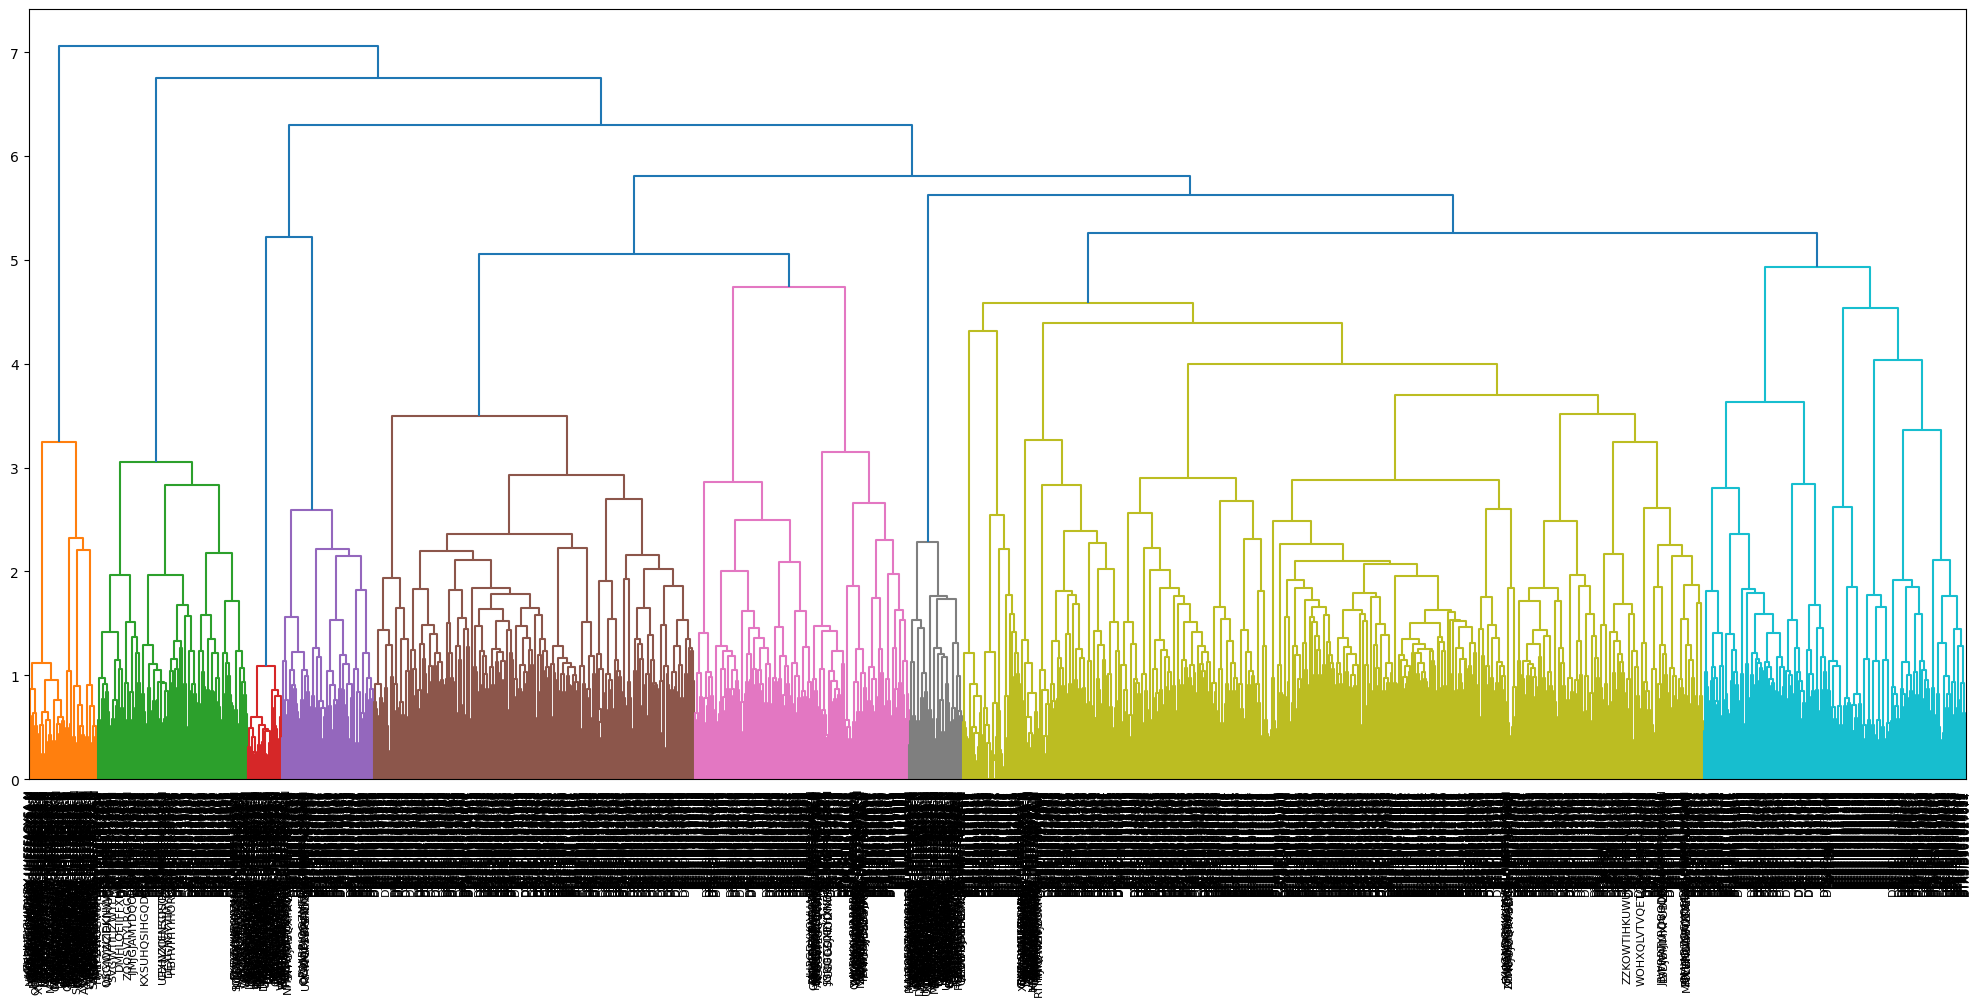

In [146]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries[14]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('Side-chain aromatics', 'lt7')].index# font size for the x axis labels
)
plt.show()

In [147]:
max_d = 3
clusters_dist8 = fcluster(summaries[14]['Z'], max_d, criterion='maxclust')
clusters_dist8
dist_clusters8 = pd.DataFrame(list(zip(results[('Side-chain aromatics', 'lt7')].index, clusters_dist8)), columns = ['dtxsid', 'cluster_d'])
dist_clusters8['category'] = 'Side-chain aromatics'
dist_clusters8['subcategory'] = 'lt7'
dist_clusters8 = dist_clusters8[['dtxsid', 'cluster_d',  'category','subcategory']]

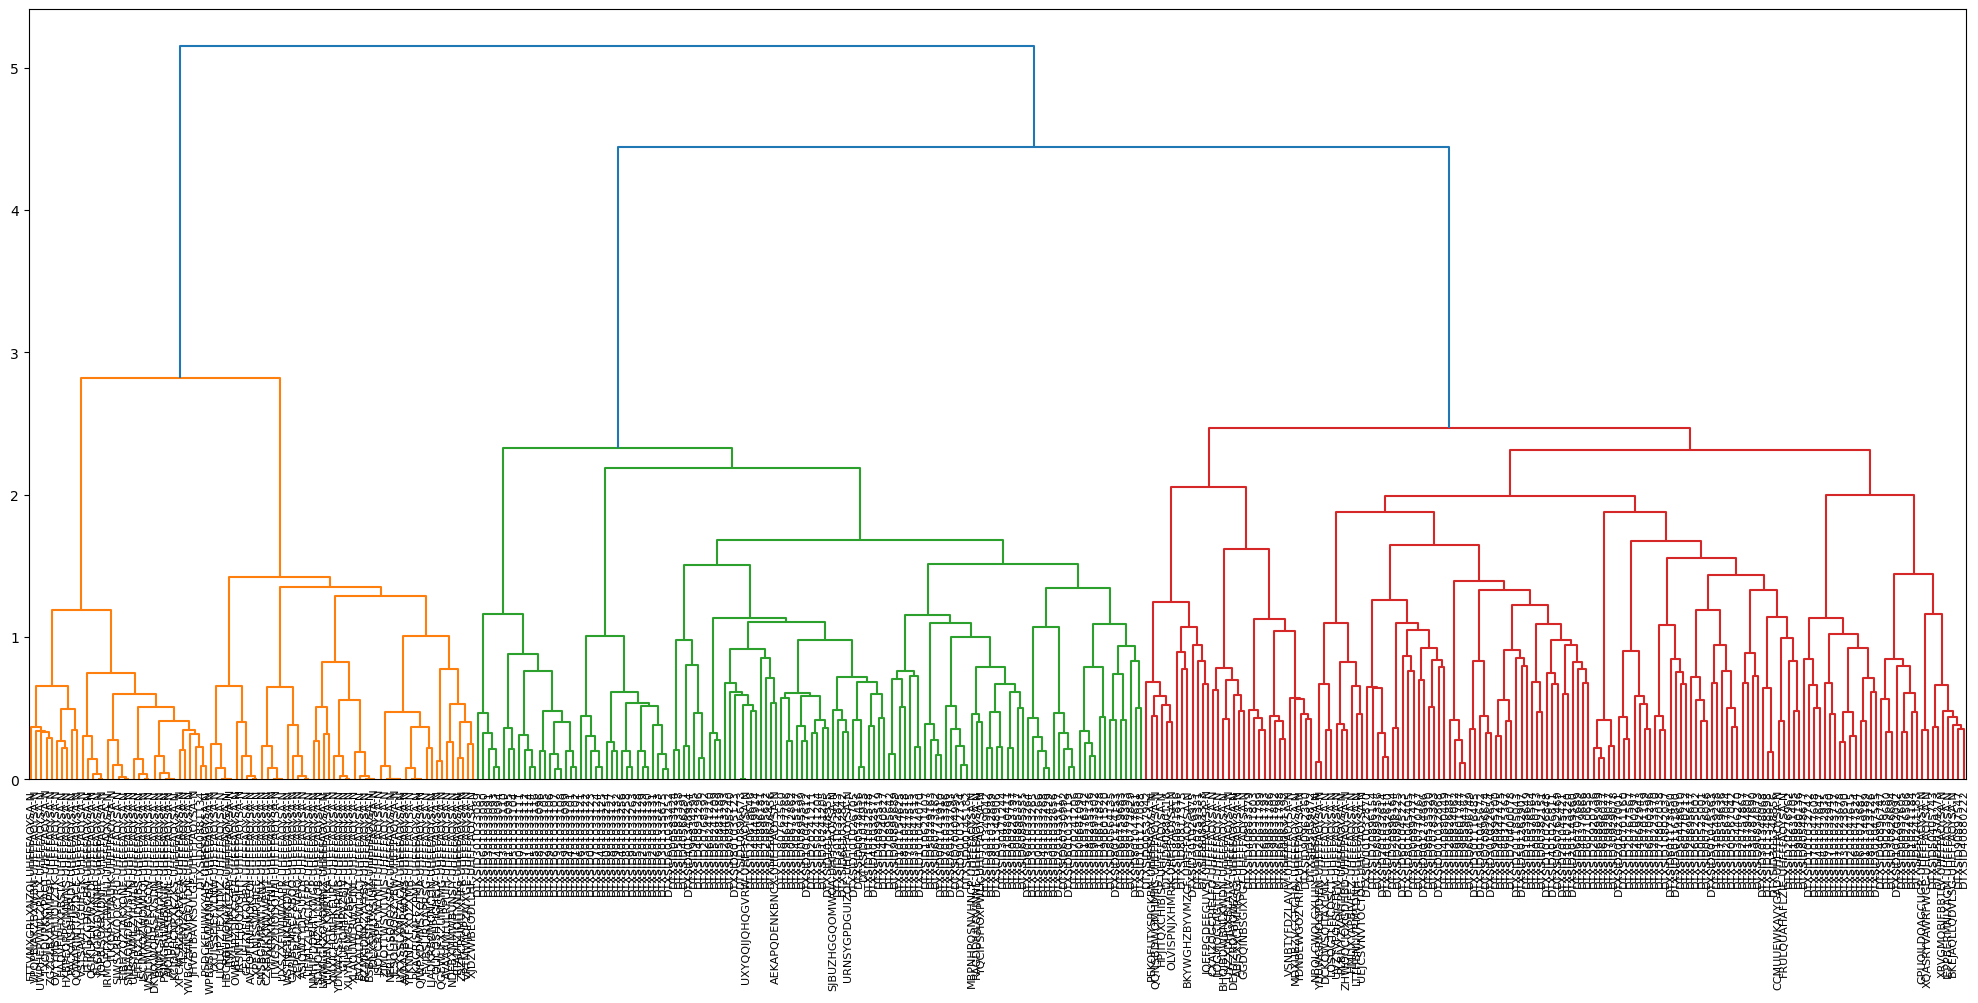

In [148]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries[16]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('Silicon PFASs', 'lt7')].index# font size for the x axis labels
)
plt.show()

In [149]:
max_d = 3
clusters_dist9 = fcluster(summaries[16]['Z'], max_d, criterion='maxclust')
clusters_dist9
dist_clusters9 = pd.DataFrame(list(zip(results[('Silicon PFASs', 'lt7')].index, clusters_dist9)), columns = ['dtxsid', 'cluster_d'])
dist_clusters9['category'] = 'Silicon PFASs'
dist_clusters9['subcategory'] = 'lt7'
dist_clusters9 = dist_clusters9[['dtxsid', 'cluster_d',  'category','subcategory']]


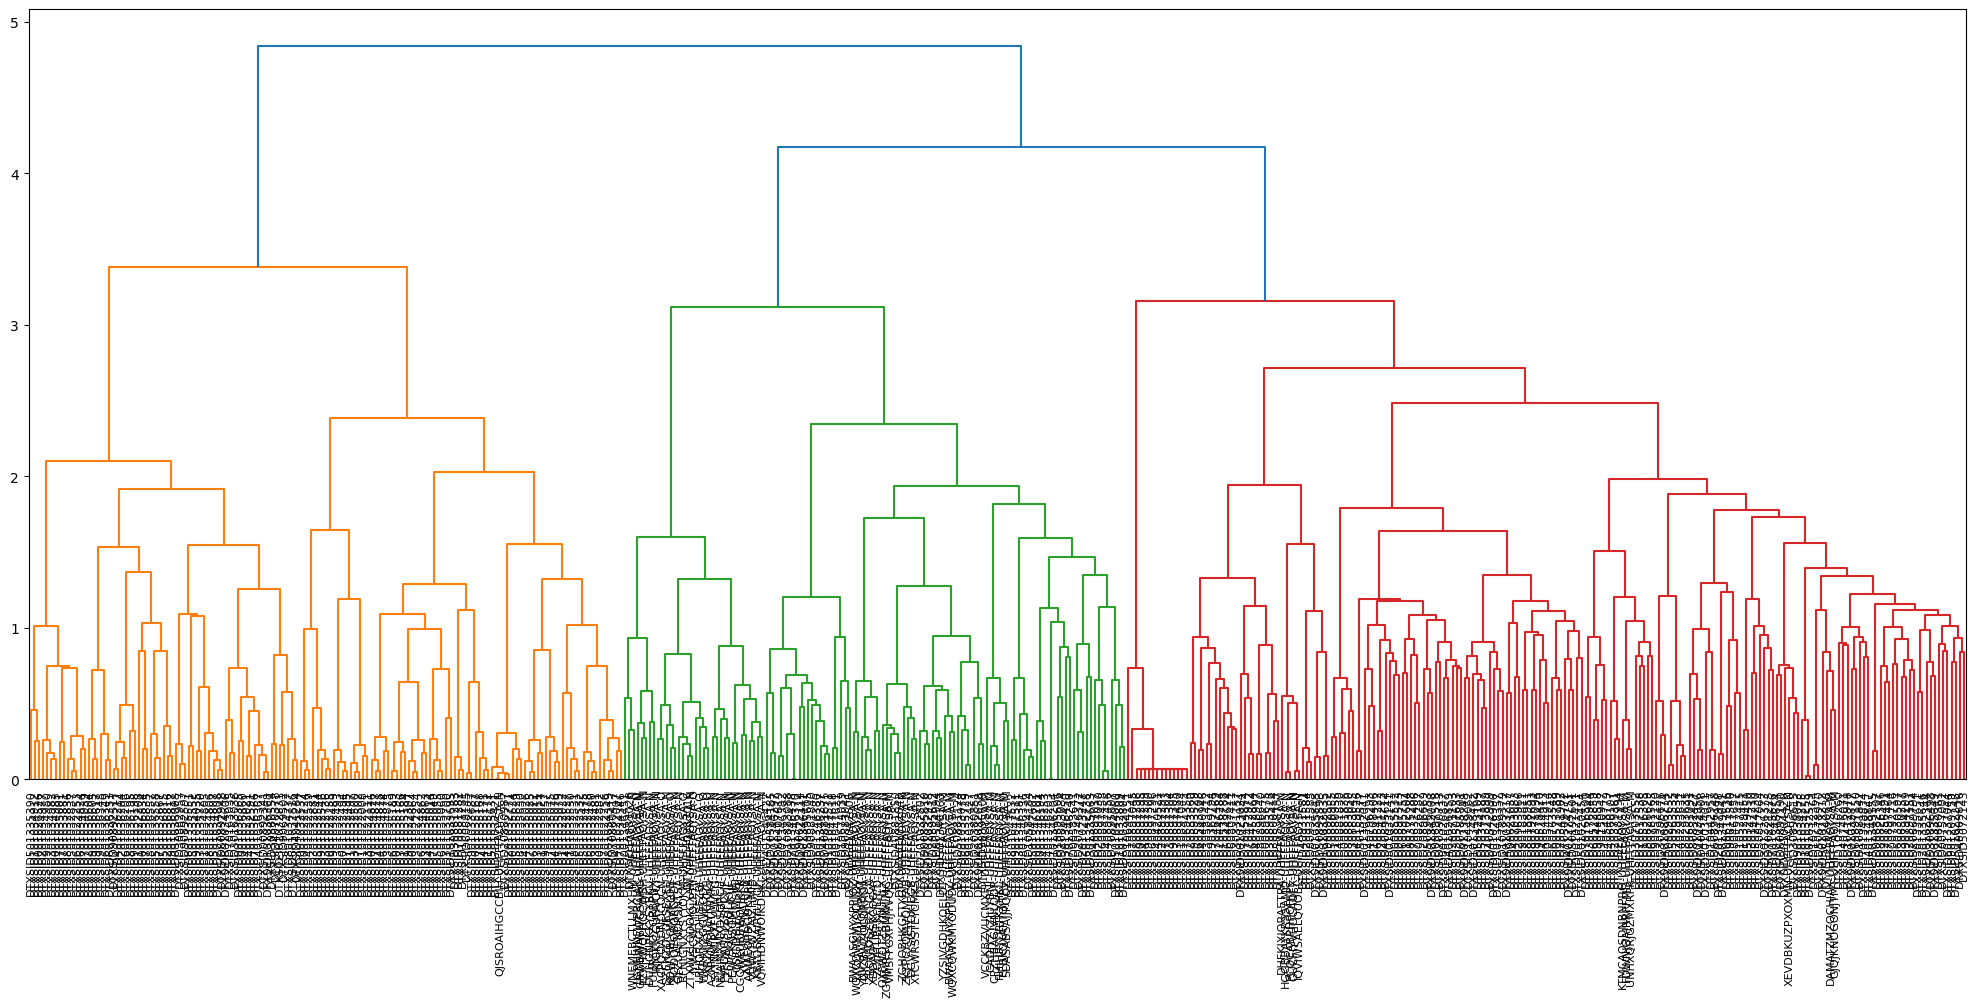

In [150]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries[19]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('unclassified', 'lt7')].index# font size for the x axis labels
)
plt.show()


In [151]:
max_d = 3
clusters_dist10 = fcluster(summaries[19]['Z'], max_d, criterion='maxclust')
clusters_dist10
dist_clusters10 = pd.DataFrame(list(zip(results[('unclassified', 'lt7')].index, clusters_dist10)), columns = ['dtxsid', 'cluster_d'])
dist_clusters10['category'] = 'unclassified'
dist_clusters10['subcategory'] = 'lt7'
dist_clusters10 = dist_clusters10[['dtxsid', 'cluster_d',  'category','subcategory']]

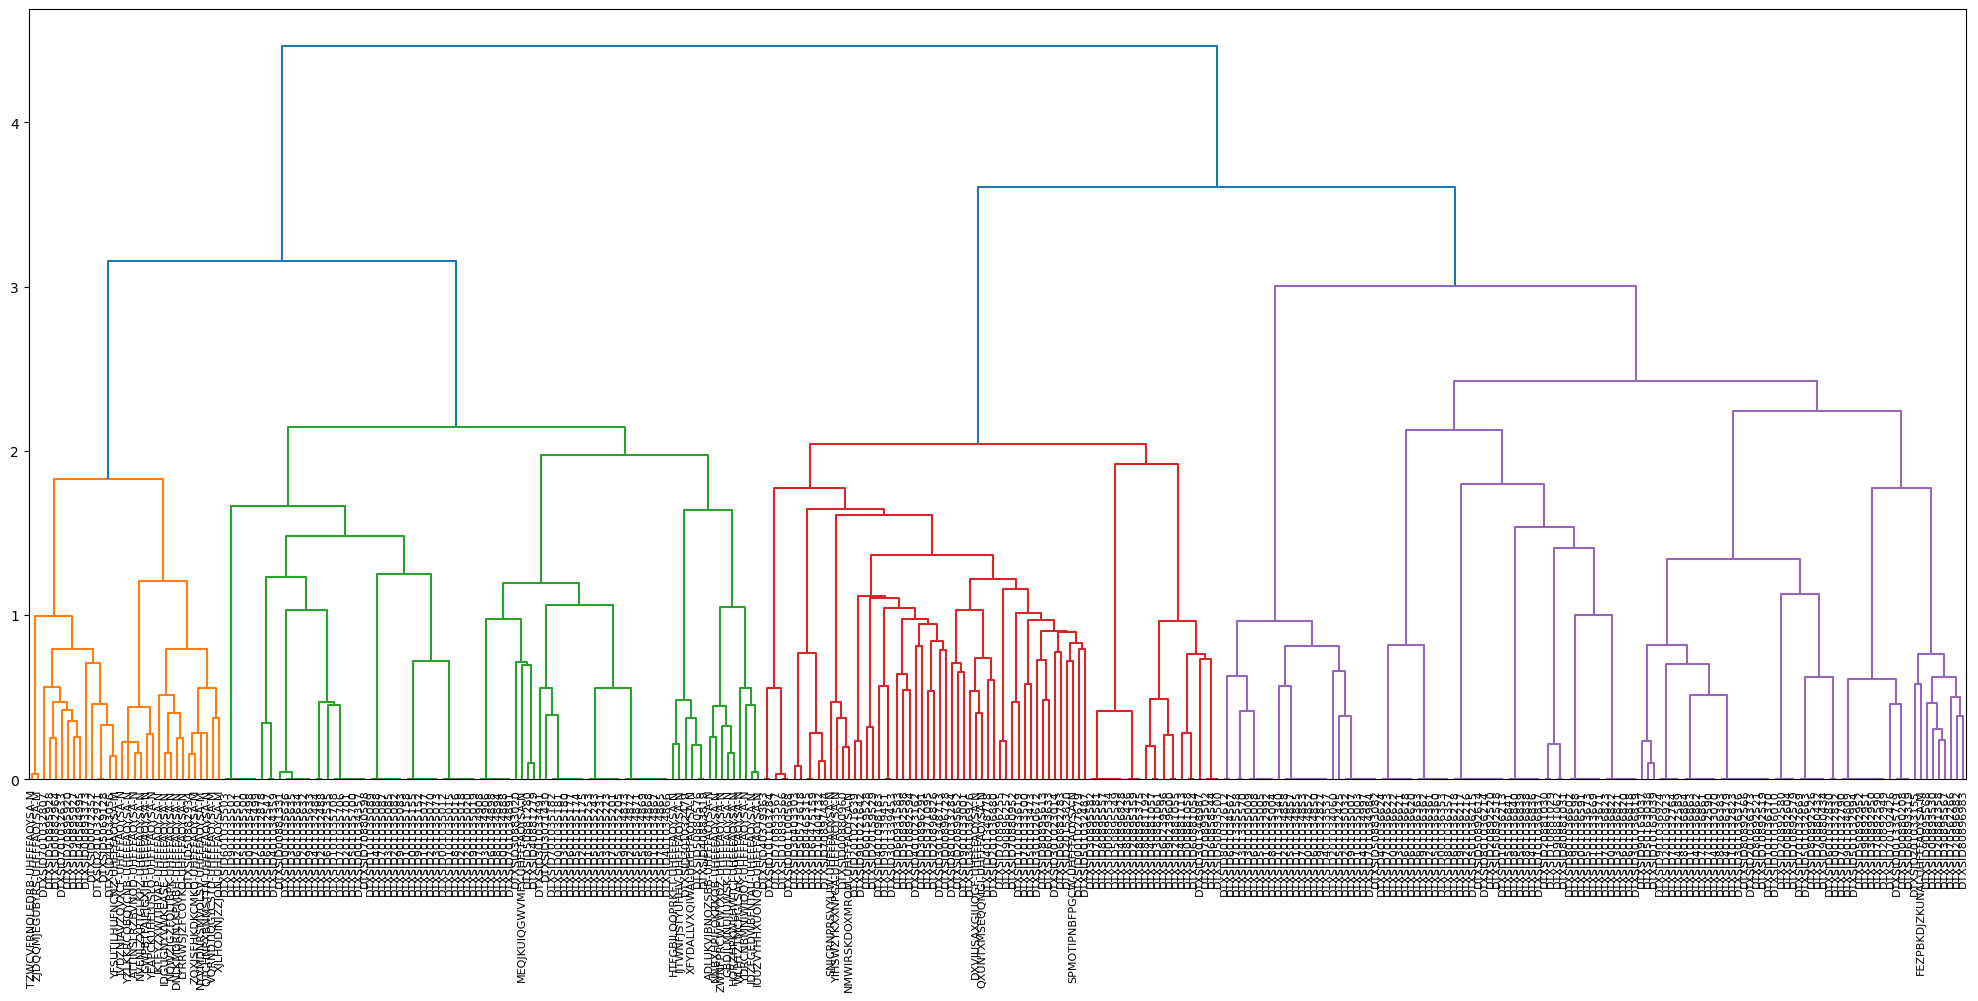

In [152]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries[18]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = results[('unclassified', 'gte7')].index# font size for the x axis labels
)
plt.show()

In [153]:
max_d = 4
clusters_dist11 = fcluster(summaries[18]['Z'], max_d, criterion='maxclust')
clusters_dist11
dist_clusters11 = pd.DataFrame(list(zip(results[('unclassified', 'gte7')].index, clusters_dist11)), columns = ['dtxsid', 'cluster_d'])
dist_clusters11['category'] = 'unclassified'
dist_clusters11['subcategory'] = 'gte7'
dist_clusters11 = dist_clusters11[['dtxsid', 'cluster_d',  'category','subcategory']]


Concatenate all the cluster sets together in one df and then merge with the main PFAS Landscape dataset

In [154]:
subcategory_df = pd.concat([dist_clusters, dist_clusters1,dist_clusters2,dist_clusters3,dist_clusters4,dist_clusters5,dist_clusters6, \
                            dist_clusters7, dist_clusters8,dist_clusters9,dist_clusters10,dist_clusters11])

In [155]:
subcategory_df.shape

(14503, 4)

In [156]:
subcategory_df.groupby(['category', 'subcategory', 'cluster_d']).size().reset_index().shape

(38, 4)

In [158]:
#manual check
3+2+3+3+3+4+4+3+3+3+3+4

38

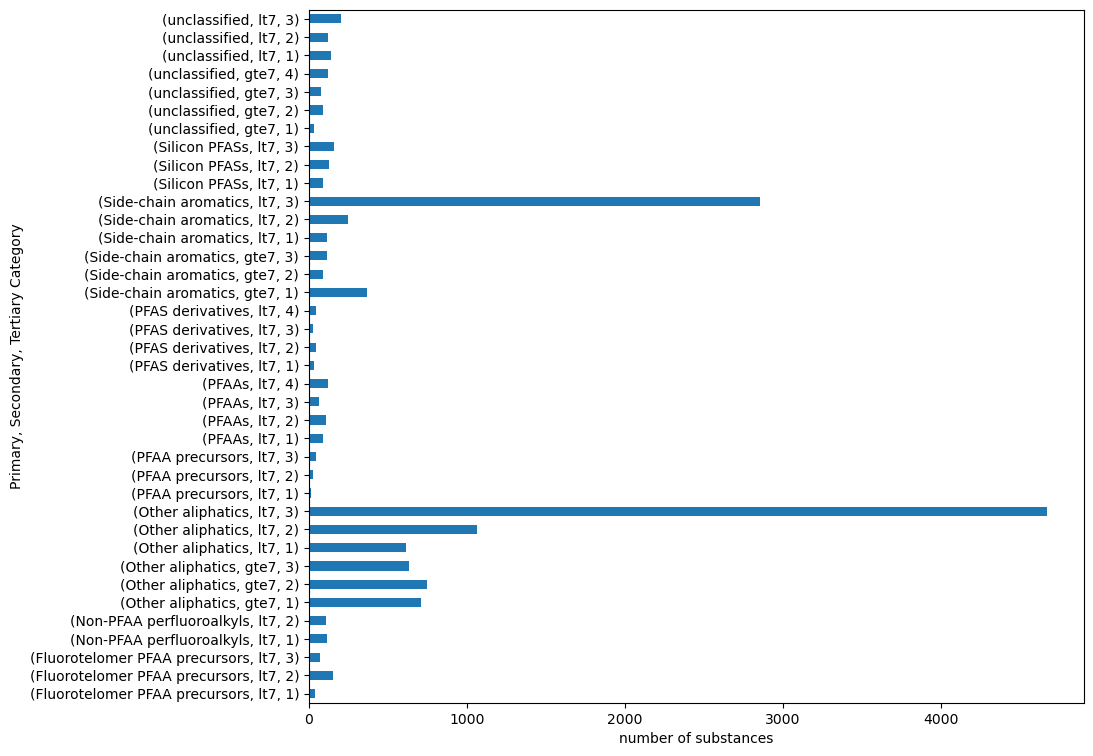

In [160]:
plt.figure(figsize = (10,9))
subcategory_df.groupby(['category', 'subcategory', 'cluster_d']).size().plot.barh()
plt.ylabel('Primary, Secondary, Tertiary Category')
plt.xlabel('number of substances')
plt.savefig(figures_dir+'Figure4_061123.png', dpi = 300, bbox_inches='tight');

In [161]:
final_wcluster = pd.merge(final_df, subcategory_df[['dtxsid', 'cluster_d']], on = 'dtxsid', how = 'left')
final_wcluster.head()

dtxsid DSSTox_QC-Level  \
0    DTXSID6071908     DSSTox_High   
1    DTXSID8071358     DSSTox_High   
2    DTXSID1071907     DSSTox_High   
3  DTXSID001026645      DSSTox_Low   
4  DTXSID301026644      DSSTox_Low   

                                      Substance_Name Substance_CASRN  \
0  N-Ethyl-N-((pentadecafluoroheptyl)sulphonyl)gl...      68957-63-1   
1            N-Methyl-perfluoro-1-heptanesulfonamide      68259-14-3   
2        N-Ethylpentadecafluoro-1-heptanesulfonamide      68957-62-0   
3  1,1,2,2,3,3,4,4,5,5,6,6,7,7,7-Pentadecafluoro-...     167398-54-1   
4        (Perfluoroheptyl)(sulfonylamino)acetic acid    1003194-00-0   

    Substance_Type                                             smiles  \
0  Single Compound  CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...   
1  Single Compound  CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...   
2  Single Compound  CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...   
3  Single Compound  OCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...   
4  Single Compound  OC(=O)CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...   

                                     Structure_InChI  \
0  InChI=1S/C11H8F15NO4S/c1-2-27(3-4(28)29)32(30,...   
1  InChI=1S/C8H4F15NO2S/c1-24-27(25,26)8(22,23)6(...   
2  InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...   
3  InChI=1S/C9H6F15NO3S/c10-3(11,4(12,13)6(16,17)...   
4  InChI=1S/C9H4F15NO4S/c10-3(11,4(12,13)6(16,17)...   

            Structure_InChIKey Structure_Formula  Structure_MolWt  ...  \
0  IOQHTIQMCISFKB-UHFFFAOYSA-N      C11H8F15NO4S           535.22  ...   
1  KDHCALLFPWZTPN-UHFFFAOYSA-N       C8H4F15NO2S           463.16  ...   
2  WMOMXEHEPXLIAV-UHFFFAOYSA-N       C9H6F15NO2S           477.19  ...   
3  LJJUSVBJKZXMCP-UHFFFAOYSA-N       C9H6F15NO3S           493.19  ...   
4  LAAXCIZXZCKWFF-UHFFFAOYSA-N       C9H4F15NO4S           507.17  ...   

  tsca_match subcategory                             cluster  \
0        NaN        gte7  (FASA based PFAA precursors, gte7)   
1        NaN        gte7  (FASA based PFAA precursors, gte7)   
2        NaN        gte7  (FASA based PFAA precursors, gte7)   
3        NaN        gte7  (FASA based PFAA precursors, gte7)   
4        NaN        gte7  (FASA based PFAA precursors, gte7)   

   cluster_centroid     centroid_x      centroid2     centroid_y  \
0          centroid  DTXSID6071908  DTXSID6071908  DTXSID6071908   
1               NaN            NaN  DTXSID6071908  DTXSID6071908   
2               NaN            NaN  DTXSID6071908  DTXSID6071908   
3               NaN            NaN  DTXSID6071908  DTXSID6071908   
4               NaN            NaN  DTXSID6071908  DTXSID6071908   

         analogues      Dist  cluster_d  
0    DTXSID6071908       0.0        NaN  
1    DTXSID8071358      0.64        NaN  
2    DTXSID1071907  0.615385        NaN  
3  DTXSID001026645  0.660714        NaN  
4  DTXSID301026644  0.592593        NaN  

[5 rows x 57 columns]



Re-doing the cluster centroids for the subclusters now identified

Utility functions for the cluster centroid calculations


In [162]:
subcats = final_wcluster[final_wcluster['cluster_d'].notnull()]

In [163]:
results_subcats = {}
for i, group in subcats.groupby(['category', 'subcategory', 'cluster_d']):
    try:
        a = mk_fp(group)
    except Exception as error:
        print(error)
    else:
        results_subcats[i] = a

[08:35:28] WARNING: not removing hydrogen atom without neighbors


In [164]:
distances_subcats = {}
for k,v in results_subcats.items():
    a = distance_matrix(results_subcats[k])
    distances_subcats[k] = a

In [165]:
centres_1 = []
for i,group in subcategory_df.groupby(['category', 'subcategory','cluster_d']):
    try:
        m = medoid_calc(distances_subcats[i])
        centres_1.append(m)
    except Exception as error:
        print(error)


In [166]:
len(centres_1)

38

In [167]:
final_df['level2_cluster_centroid'] = final_df['dtxsid'].apply(lambda x: 'centroid' if x in (centres_1) else np.nan)

In [168]:
df_2 = pd.merge(final_df, subcategory_df[['dtxsid', 'cluster_d']], on = 'dtxsid', how = 'left')

In [169]:
df_3 = df_2.set_index('dtxsid')

In [170]:
members_lvl2 = {}

for i, group in df_3.groupby(['category', 'subcategory', 'cluster_d']):
    subset = group[['cluster_d', 'level2_cluster_centroid']]
    try: 
        for x, y in subset.iterrows():
            a, b = y
            if b == 'centroid':
                #print(x)
                c = [distances_subcats[i][x].index, distances_subcats[i][x].values]
                members_lvl2[x] = c
    except Exception as error:
            print(error)

In [171]:
len(members_lvl2.keys())

38

In [172]:
cluster_members_lvl2 = pd.DataFrame(list(members_lvl2.items()))
cluster_members_lvl2.columns = ['lvl2_centroid', 1]
cluster_members_lvl2[['lvl2_analogues','lvl2_Dist']] = pd.DataFrame(cluster_members_lvl2[1].tolist(), index= cluster_members_lvl2.index)
cluster_members_lvl2.drop([1], axis = 1, inplace = True)
cluster_members_lvl2_1 = cluster_members_lvl2.apply(pd.Series.explode)

In [173]:
df_2 = df_2.sort_values(by = ['category', 'subcategory', 'cluster_d', 'level2_cluster_centroid'], ascending = [True, True,True, False])

In [174]:
df_2['lvl2_centroid'] = df_2.apply(lambda x: x['dtxsid'] if x['level2_cluster_centroid'] == 'centroid' else np.nan, axis = 1)

In [175]:
df_2= df_2.sort_values(by = ['category', 'subcategory', 'cluster_d', 'lvl2_centroid'], ascending = [True, True,True, False])

In [176]:
df_2['lvl2_centroid2'] = df_2.loc[df_2.cluster_d.notnull(), 'lvl2_centroid'].fillna(method = 'ffill')

In [177]:
mydict_lvl2 = {}
for i, group in df_2.groupby('lvl2_centroid2'):
    k = [n for n in group['lvl2_centroid2'] if n != ' '][0]
    v = list(group['dtxsid'])
    mydict_lvl2[k] = v

In [178]:
len(list(mydict_lvl2.values()))

38

In [179]:
dist_lvl2 = []
for i, group in cluster_members_lvl2_1.groupby('lvl2_centroid'):
    a = cluster_members_lvl2_1[(cluster_members_lvl2_1['lvl2_centroid'] == i) & (cluster_members_lvl2_1['lvl2_analogues'].isin(mydict_lvl2[i]))]
    dist_lvl2.append(a)

In [180]:
dist_lvl2_df = pd.concat([e for e in dist_lvl2])

In [181]:
dist_lvl2_df.columns

Index(['lvl2_centroid', 'lvl2_analogues', 'lvl2_Dist'], dtype='object')

In [182]:
df_wlvl2 = pd.merge(df_2, dist_lvl2_df[['lvl2_analogues', 'lvl2_Dist']], left_on = 'dtxsid', right_on = 'lvl2_analogues', how = 'left')

In [183]:
df_wlvl2['final_centroid'] = df_wlvl2[['centroid2', 'lvl2_centroid2']].apply(lambda x : x[1] if pd.notnull((x[1])) else x[0], axis =1)

In [184]:
df_wlvl2['final_dist'] = df_wlvl2[['Dist', 'lvl2_Dist']].apply(lambda x : x[1] if pd.notnull((x[1])) else x[0], axis =1)

In [185]:
df_wlvl2.head()

dtxsid DSSTox_QC-Level  \
0    DTXSID6071908     DSSTox_High   
1    DTXSID8071358     DSSTox_High   
2    DTXSID1071907     DSSTox_High   
3  DTXSID001026645      DSSTox_Low   
4  DTXSID301026644      DSSTox_Low   

                                      Substance_Name Substance_CASRN  \
0  N-Ethyl-N-((pentadecafluoroheptyl)sulphonyl)gl...      68957-63-1   
1            N-Methyl-perfluoro-1-heptanesulfonamide      68259-14-3   
2        N-Ethylpentadecafluoro-1-heptanesulfonamide      68957-62-0   
3  1,1,2,2,3,3,4,4,5,5,6,6,7,7,7-Pentadecafluoro-...     167398-54-1   
4        (Perfluoroheptyl)(sulfonylamino)acetic acid    1003194-00-0   

    Substance_Type                                             smiles  \
0  Single Compound  CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...   
1  Single Compound  CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...   
2  Single Compound  CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...   
3  Single Compound  OCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...   
4  Single Compound  OC(=O)CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...   

                                     Structure_InChI  \
0  InChI=1S/C11H8F15NO4S/c1-2-27(3-4(28)29)32(30,...   
1  InChI=1S/C8H4F15NO2S/c1-24-27(25,26)8(22,23)6(...   
2  InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...   
3  InChI=1S/C9H6F15NO3S/c10-3(11,4(12,13)6(16,17)...   
4  InChI=1S/C9H4F15NO4S/c10-3(11,4(12,13)6(16,17)...   

            Structure_InChIKey Structure_Formula  Structure_MolWt  ...  \
0  IOQHTIQMCISFKB-UHFFFAOYSA-N      C11H8F15NO4S           535.22  ...   
1  KDHCALLFPWZTPN-UHFFFAOYSA-N       C8H4F15NO2S           463.16  ...   
2  WMOMXEHEPXLIAV-UHFFFAOYSA-N       C9H6F15NO2S           477.19  ...   
3  LJJUSVBJKZXMCP-UHFFFAOYSA-N       C9H6F15NO3S           493.19  ...   
4  LAAXCIZXZCKWFF-UHFFFAOYSA-N       C9H4F15NO4S           507.17  ...   

         analogues      Dist level2_cluster_centroid  cluster_d lvl2_centroid  \
0    DTXSID6071908       0.0                     NaN        NaN           NaN   
1    DTXSID8071358      0.64                     NaN        NaN           NaN   
2    DTXSID1071907  0.615385                     NaN        NaN           NaN   
3  DTXSID001026645  0.660714                     NaN        NaN           NaN   
4  DTXSID301026644  0.592593                     NaN        NaN           NaN   

   lvl2_centroid2  lvl2_analogues lvl2_Dist  final_centroid  final_dist  
0             NaN             NaN       NaN   DTXSID6071908    0.000000  
1             NaN             NaN       NaN   DTXSID6071908    0.640000  
2             NaN             NaN       NaN   DTXSID6071908    0.615385  
3             NaN             NaN       NaN   DTXSID6071908    0.660714  
4             NaN             NaN       NaN   DTXSID6071908    0.592593  

[5 rows x 64 columns]

First generation clusters and their sizes

In [186]:
next_gen = df_wlvl2.copy()

In [187]:
next_gen.groupby(['cluster', 'cluster_d']).size()

cluster                               cluster_d
(Fluorotelomer PFAA precursors, lt7)  1.0            40
                                      2.0           153
                                      3.0            73
(Non-PFAA perfluoroalkyls, lt7)       1.0           114
                                      2.0           109
(Other aliphatics, gte7)              1.0           707
                                      2.0           750
                                      3.0           633
(Other aliphatics, lt7)               1.0           616
                                      2.0          1063
                                      3.0          4673
(PFAA precursors, lt7)                1.0            16
                                      2.0            27
                                      3.0            45
(PFAAs, lt7)                          1.0            89
                                      2.0           109
                                      3.0            61


In [188]:
next_gen_FPs ={}
for i, group in next_gen.groupby(['cluster', 'cluster_d']):
    try:
        a = mk_fp(group)
    except Exception as error:
        print(error)
    else:
        next_gen_FPs[i] = a


[08:45:29] WARNING: not removing hydrogen atom without neighbors


In [189]:
distances_nextgen = {}
for k,v in next_gen_FPs.items():
    a = distance_matrix(next_gen_FPs[k])
    distances_nextgen[k] = a

In [190]:
summaries_nextgen = []
for k,v in distances_nextgen.items():
    summaries_nextgen.append(plug_in(distances_nextgen[k], label = k))

In [191]:
nextgen_thresholds = []
for i in range(0, len(summaries_nextgen)):
    a, b  = summaries_nextgen[i]['label'], summaries_nextgen[i]['50PCTILE']
    nextgen_thresholds.append([a,b])

In [192]:
nextgen_thresholds = pd.DataFrame(nextgen_thresholds, columns = ['label', '50PCTILE'])

In [193]:
nextgen_thresholds[nextgen_thresholds['50PCTILE'] >= defined_threshold].shape

(19, 2)

Identifying the next generation of tertiary categories that need to be subcategorised further.

In [194]:
nextgen_thresholds[nextgen_thresholds['50PCTILE'] >= defined_threshold]

label  50PCTILE
1   ((Fluorotelomer PFAA precursors, lt7), 2.0)  0.760870
2   ((Fluorotelomer PFAA precursors, lt7), 3.0)  0.800000
3        ((Non-PFAA perfluoroalkyls, lt7), 1.0)  0.782609
4        ((Non-PFAA perfluoroalkyls, lt7), 2.0)  0.766667
7               ((Other aliphatics, gte7), 3.0)  0.772727
8                ((Other aliphatics, lt7), 1.0)  0.886364
9                ((Other aliphatics, lt7), 2.0)  0.833333
10               ((Other aliphatics, lt7), 3.0)  0.866667
11                ((PFAA precursors, lt7), 1.0)  0.815302
13                ((PFAA precursors, lt7), 3.0)  0.750000
19               ((PFAS derivatives, lt7), 2.0)  0.750000
21               ((PFAS derivatives, lt7), 4.0)  0.777778
22          ((Side-chain aromatics, gte7), 1.0)  0.784091
26           ((Side-chain aromatics, lt7), 2.0)  0.771930
27           ((Side-chain aromatics, lt7), 3.0)  0.880282
30                  ((Silicon PFASs, lt7), 3.0)  0.869565
33                  ((unclassified, gte7), 3.0)  0.797980
36                   ((unclassified, lt7), 2.0)  0.756757
37                   ((unclassified, lt7), 3.0)  0.891304

In [195]:
nextgen_clusters = nextgen_thresholds[nextgen_thresholds['50PCTILE'] >= defined_threshold]['label'].tolist()

In [196]:
len(nextgen_clusters)

19

In [197]:
for i in range(len(summaries_nextgen)):
    if summaries_nextgen[i]['label'] in nextgen_clusters:
        print(i, summaries_nextgen[i]['label'])

1 (('Fluorotelomer PFAA precursors', 'lt7'), 2.0)
2 (('Fluorotelomer PFAA precursors', 'lt7'), 3.0)
3 (('Non-PFAA perfluoroalkyls', 'lt7'), 1.0)
4 (('Non-PFAA perfluoroalkyls', 'lt7'), 2.0)
7 (('Other aliphatics', 'gte7'), 3.0)
8 (('Other aliphatics', 'lt7'), 1.0)
9 (('Other aliphatics', 'lt7'), 2.0)
10 (('Other aliphatics', 'lt7'), 3.0)
11 (('PFAA precursors', 'lt7'), 1.0)
13 (('PFAA precursors', 'lt7'), 3.0)
19 (('PFAS derivatives', 'lt7'), 2.0)
21 (('PFAS derivatives', 'lt7'), 4.0)
22 (('Side-chain aromatics', 'gte7'), 1.0)
26 (('Side-chain aromatics', 'lt7'), 2.0)
27 (('Side-chain aromatics', 'lt7'), 3.0)
30 (('Silicon PFASs', 'lt7'), 3.0)
33 (('unclassified', 'gte7'), 3.0)
36 (('unclassified', 'lt7'), 2.0)
37 (('unclassified', 'lt7'), 3.0)


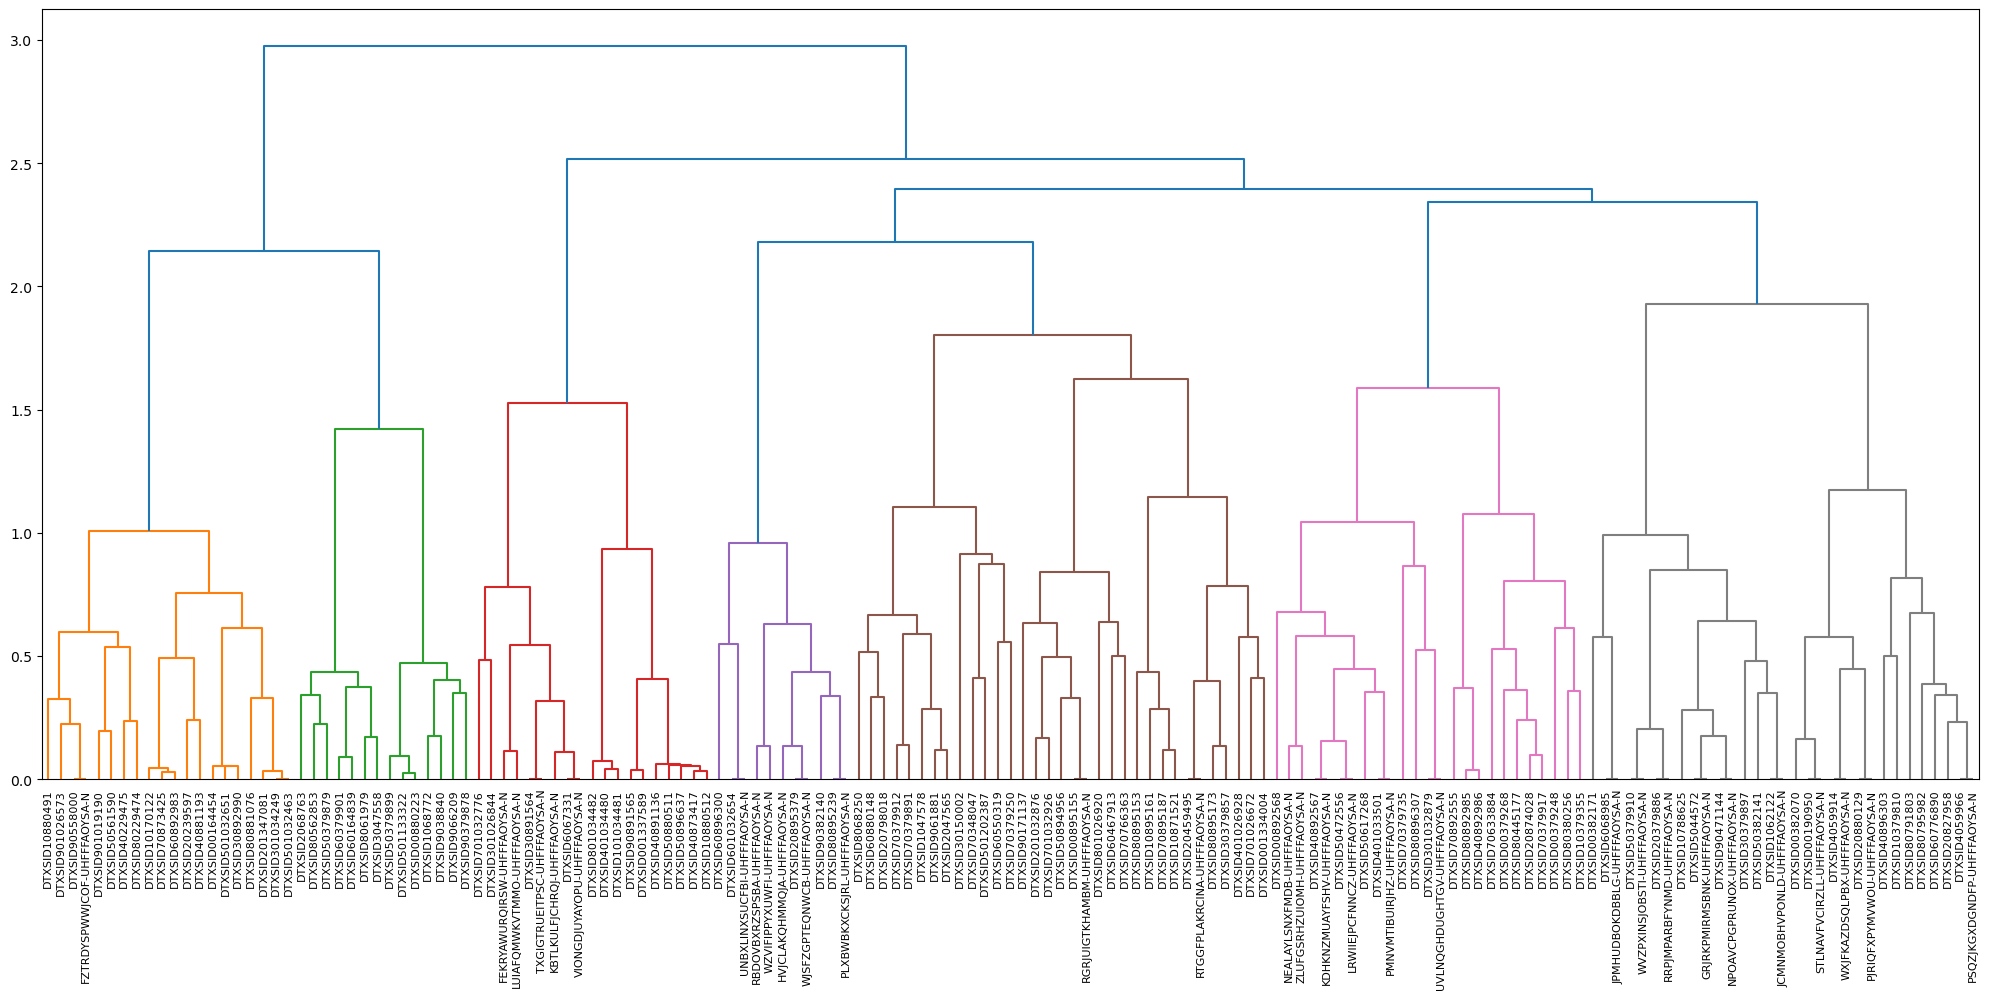

In [198]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[1]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Fluorotelomer PFAA precursors', 'lt7'), 2.0)].index# font size for the x axis labels
)
plt.show()

In [199]:
max_d = 3
nextgen_dist = fcluster(summaries_nextgen[1]['Z'], max_d, criterion='maxclust')
nextgen_dist
dist_nextgen = pd.DataFrame(list(zip(next_gen_FPs[(('Fluorotelomer PFAA precursors', 'lt7'), 2.0)].index, nextgen_dist)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen['category'] = 'Fluorotelomer PFAA precursors'
dist_nextgen['subcategory'] = 'lt7'
dist_nextgen['cluster'] = 2
dist_nextgen = dist_nextgen[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

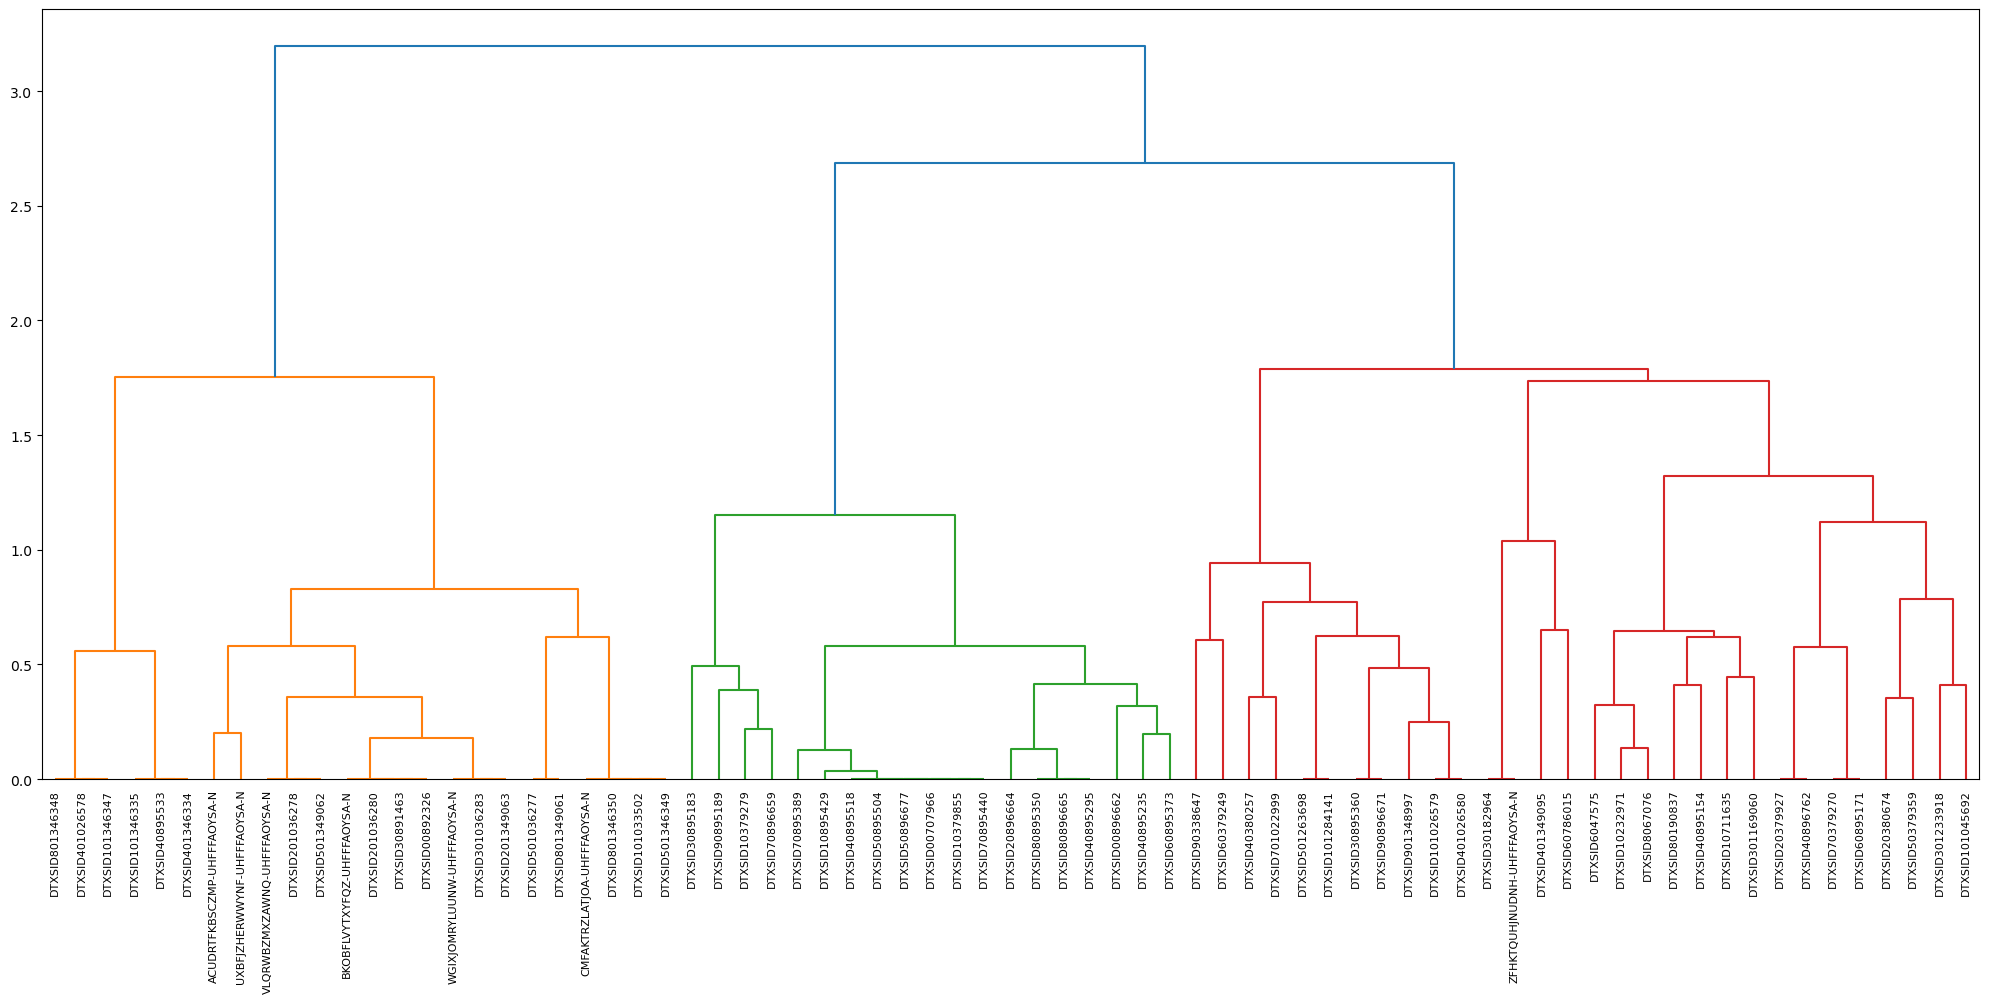

In [200]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[2]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Fluorotelomer PFAA precursors', 'lt7'), 3.0)].index# font size for the x axis labels
)
plt.show()

In [201]:
max_d = 3
nextgen_dist1 = fcluster(summaries_nextgen[2]['Z'], max_d, criterion='maxclust')
nextgen_dist1
dist_nextgen1 = pd.DataFrame(list(zip(next_gen_FPs[(('Fluorotelomer PFAA precursors', 'lt7'), 3.0)].index, nextgen_dist1)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen1['category'] = 'Fluorotelomer PFAA precursors'
dist_nextgen1['subcategory'] = 'lt7'
dist_nextgen1['cluster'] = 3
dist_nextgen1 = dist_nextgen1[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

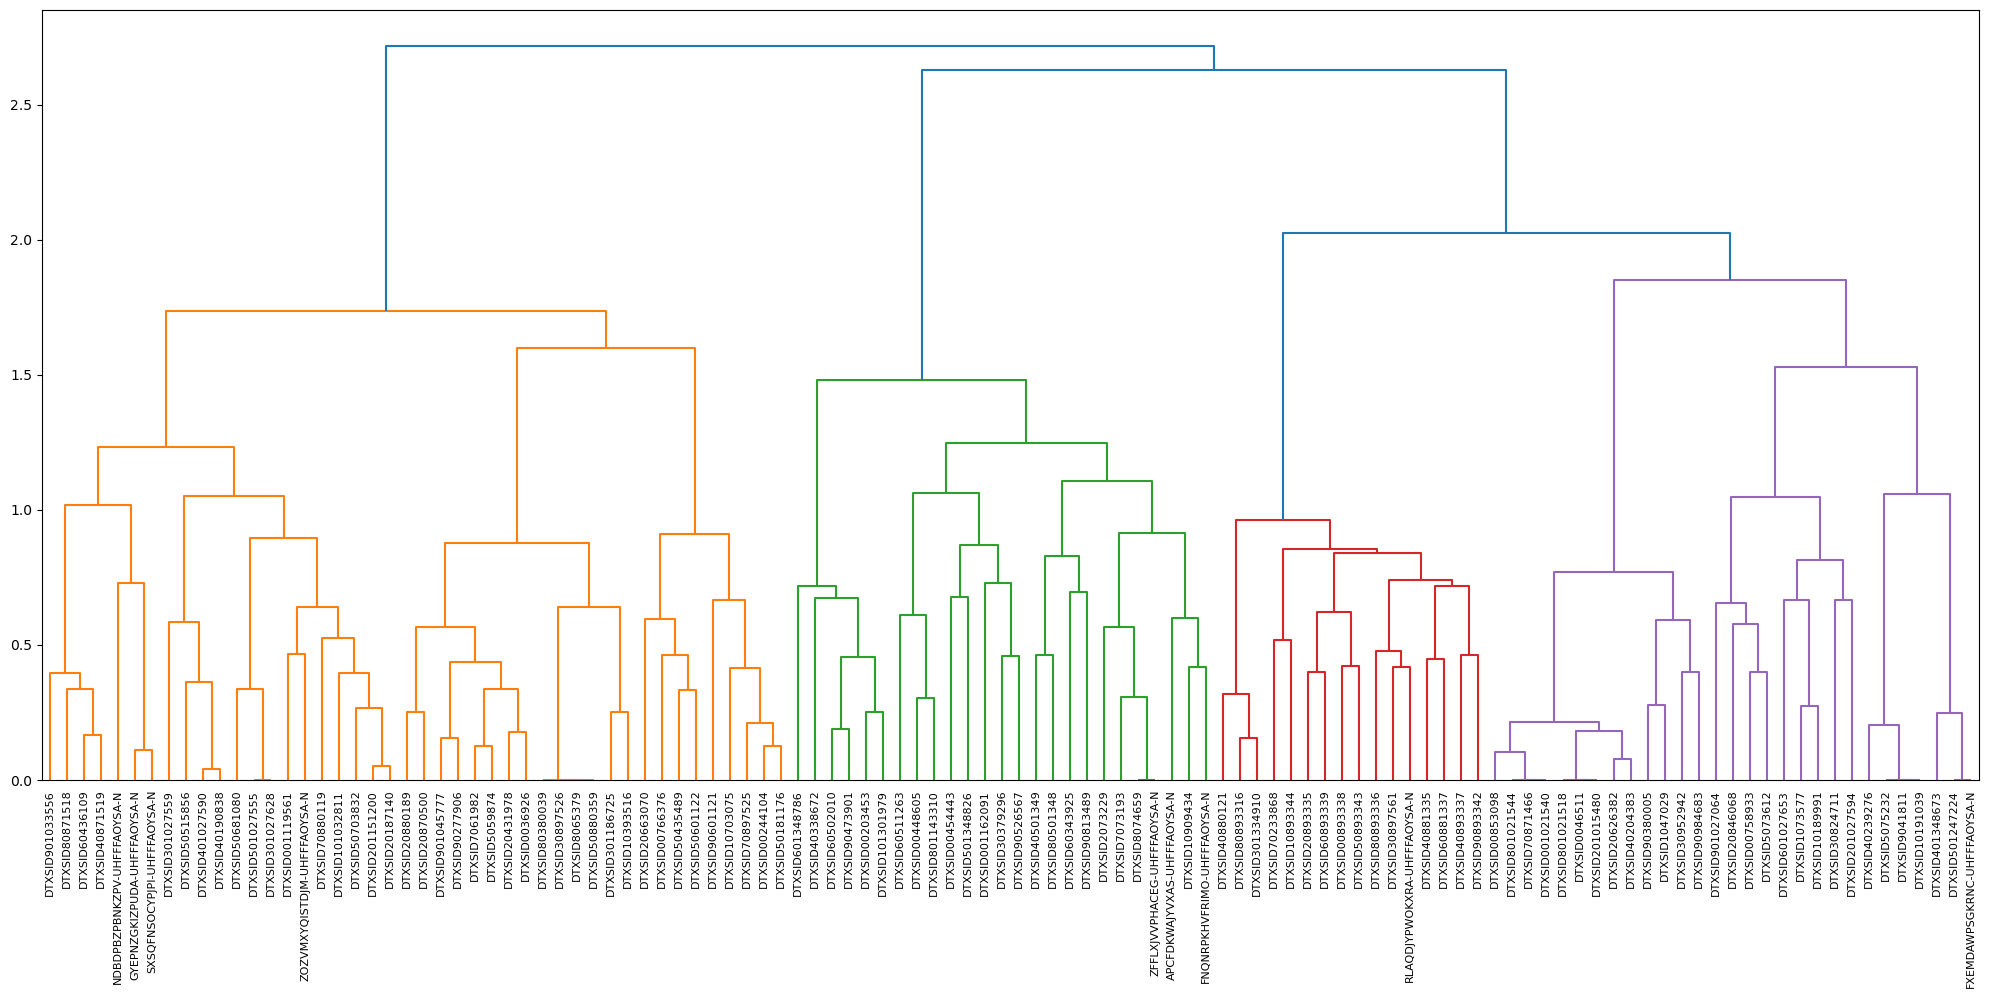

In [202]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[3]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Non-PFAA perfluoroalkyls', 'lt7'), 1.0)].index# font size for the x axis labels
)
plt.show()


In [203]:
max_d = 3
nextgen_dist2 = fcluster(summaries_nextgen[3]['Z'], max_d, criterion='maxclust')
nextgen_dist2
dist_nextgen2 = pd.DataFrame(list(zip(next_gen_FPs[(('Non-PFAA perfluoroalkyls', 'lt7'), 1.0)].index, nextgen_dist2)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen2['category'] = 'Non-PFAA perfluoroalkyls'
dist_nextgen2['subcategory'] = 'lt7'
dist_nextgen2['cluster'] = 1
dist_nextgen2 = dist_nextgen2[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]


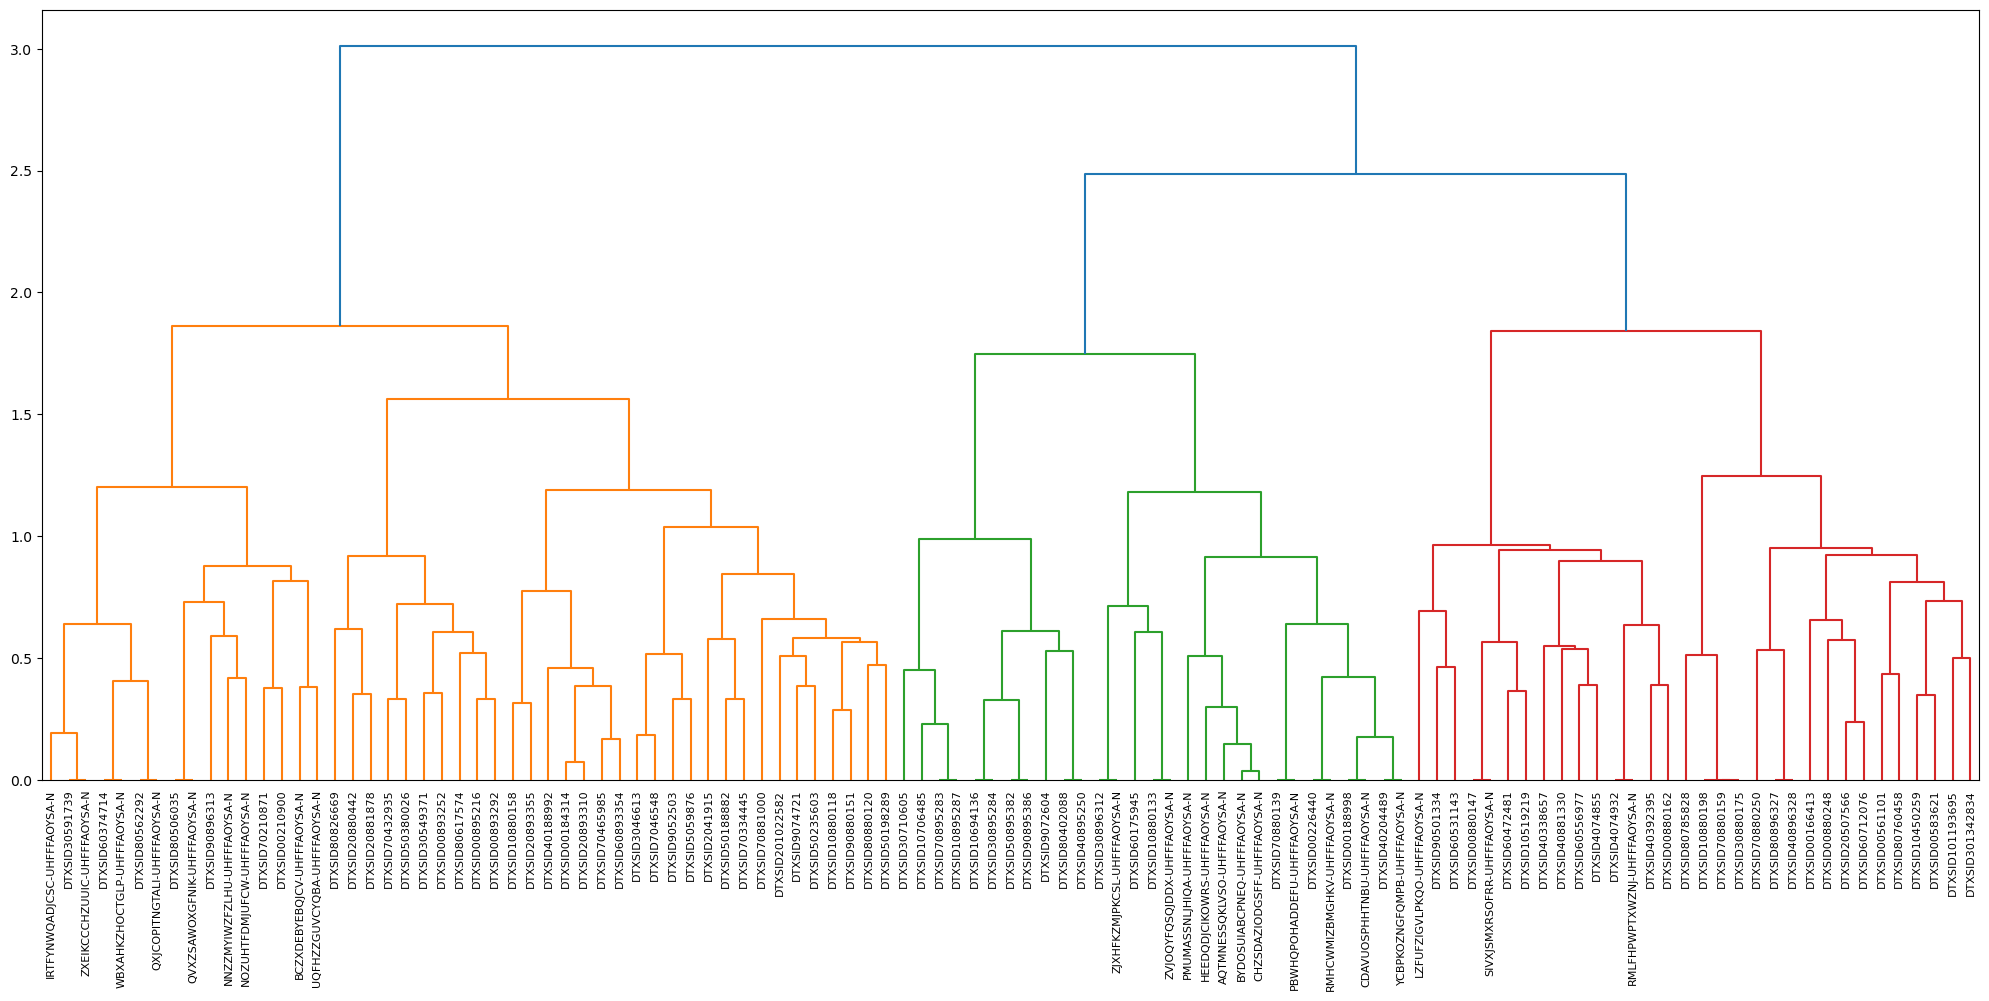

In [204]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[4]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Non-PFAA perfluoroalkyls', 'lt7'), 2.0)].index# font size for the x axis labels
)
plt.show()


In [205]:
max_d = 3
nextgen_dist3 = fcluster(summaries_nextgen[4]['Z'], max_d, criterion='maxclust')
nextgen_dist3
dist_nextgen3 = pd.DataFrame(list(zip(next_gen_FPs[(('Non-PFAA perfluoroalkyls', 'lt7'), 2.0)].index, nextgen_dist3)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen3['category'] = 'Non-PFAA perfluoroalkyls'
dist_nextgen3['subcategory'] = 'lt7'
dist_nextgen3['cluster'] = 2
dist_nextgen3 = dist_nextgen3[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]


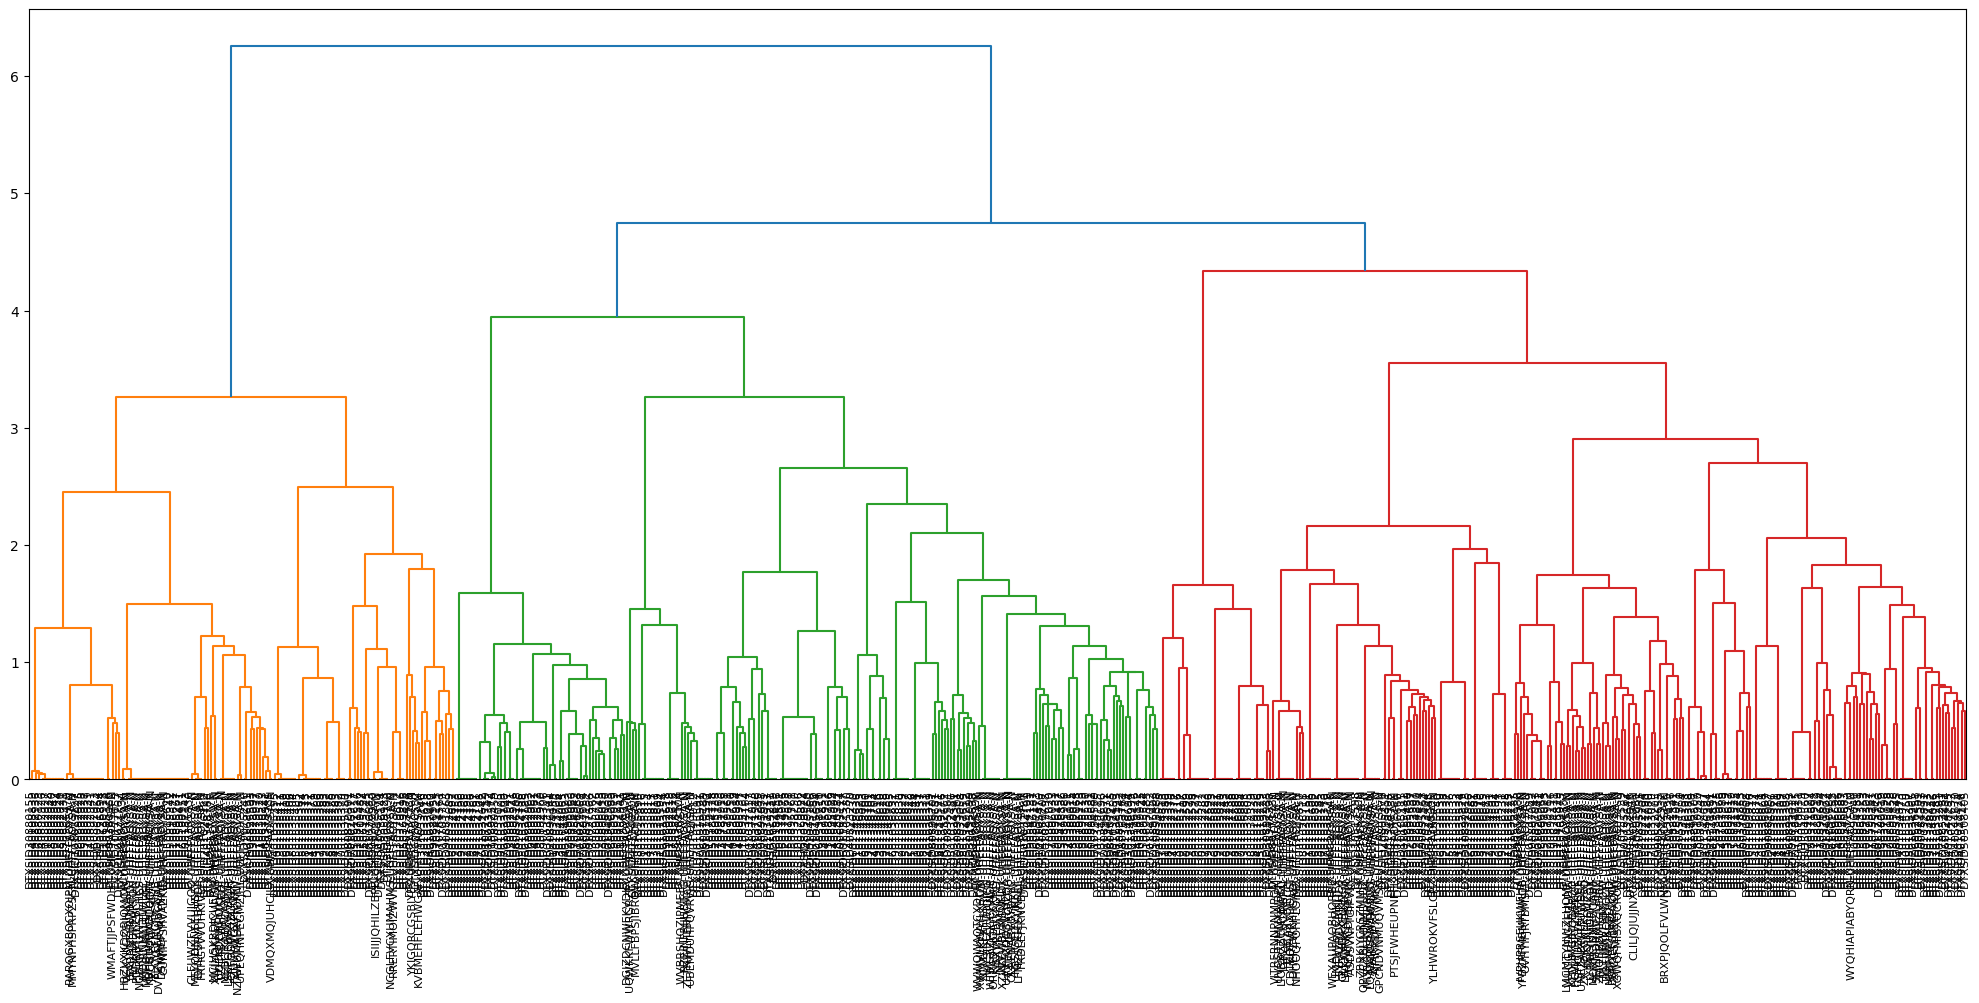

In [206]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[7]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Other aliphatics', 'gte7'), 3.0)].index# font size for the x axis labels
)
plt.show()

In [207]:
max_d = 3
nextgen_dist4 = fcluster(summaries_nextgen[7]['Z'], max_d, criterion='maxclust')
nextgen_dist4
dist_nextgen4 = pd.DataFrame(list(zip(next_gen_FPs[(('Other aliphatics', 'gte7'), 3.0)].index, nextgen_dist4)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen4['category'] = 'Other aliphatics'
dist_nextgen4['subcategory'] = 'gte7'
dist_nextgen4['cluster'] = 3
dist_nextgen4 = dist_nextgen4[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

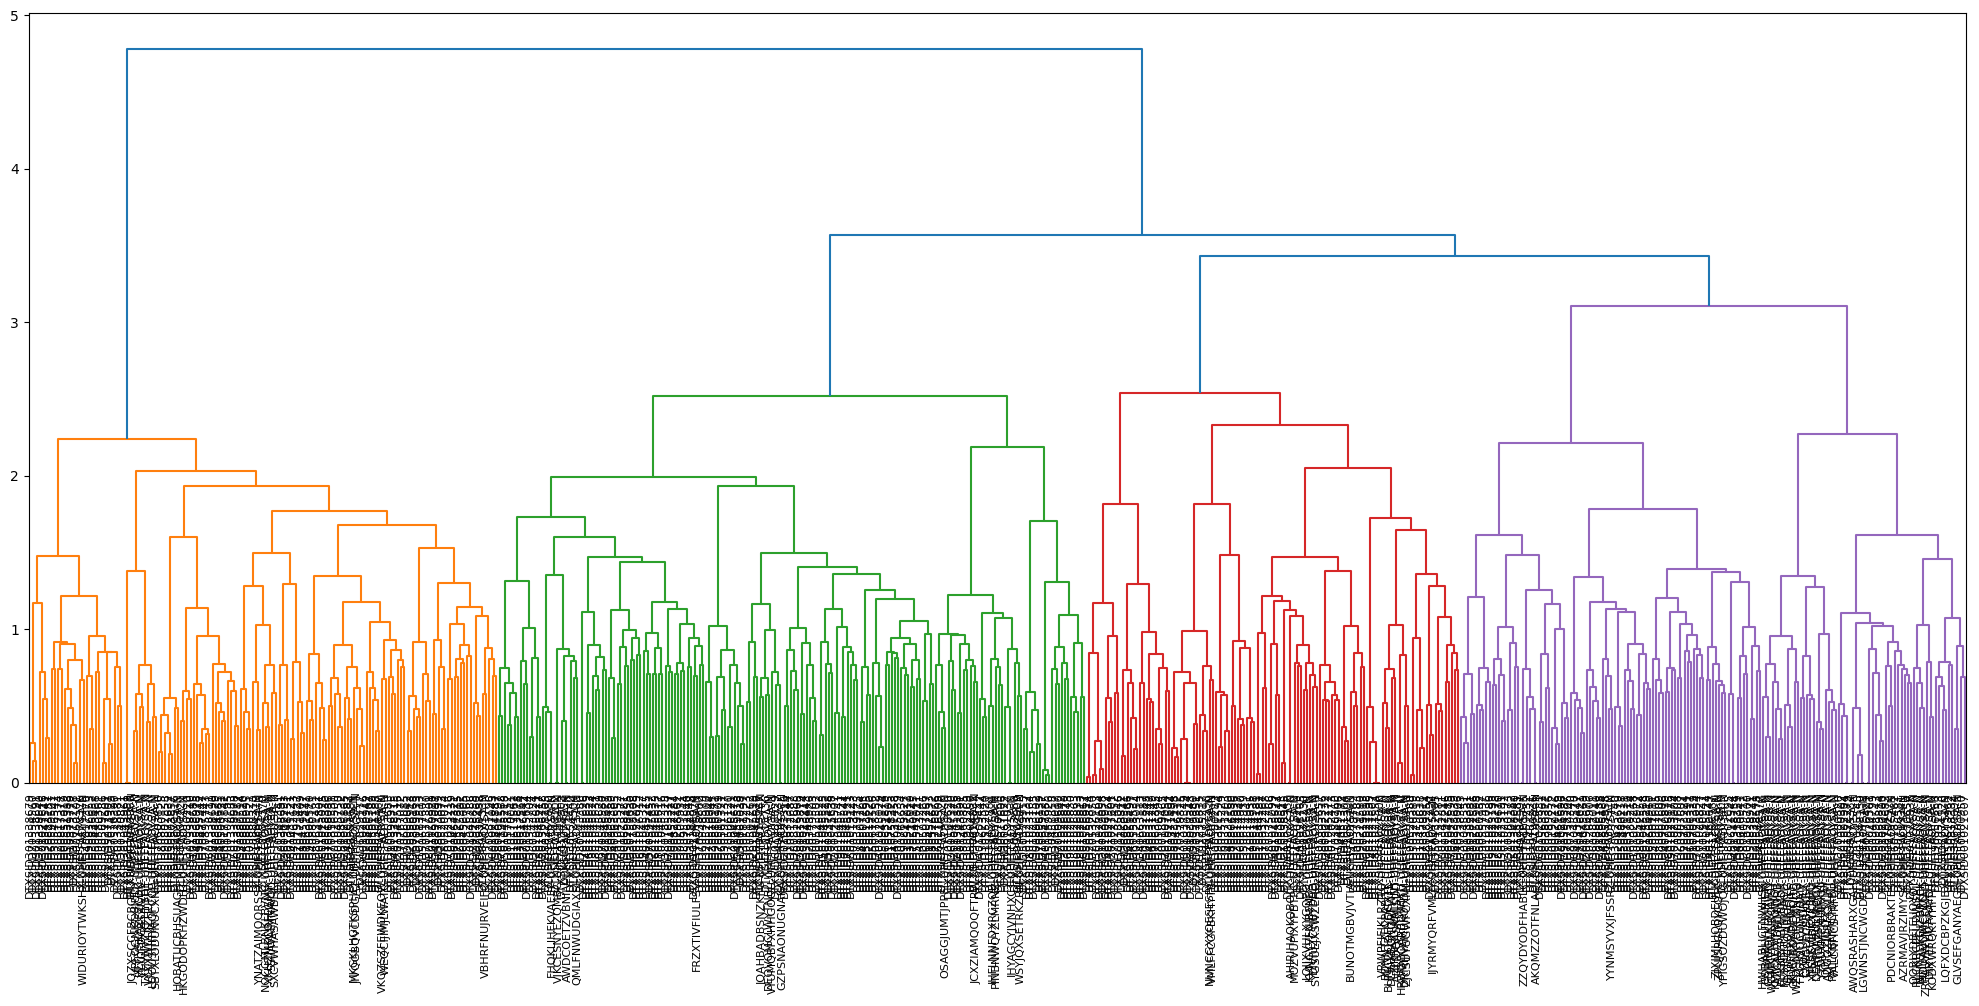

In [208]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[8]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Other aliphatics', 'lt7'), 1.0)].index# font size for the x axis labels
)
plt.show()

In [209]:
max_d = 4
nextgen_dist5 = fcluster(summaries_nextgen[8]['Z'], max_d, criterion='maxclust')
nextgen_dist5
dist_nextgen5 = pd.DataFrame(list(zip(next_gen_FPs[(('Other aliphatics', 'lt7'), 1.0)].index, nextgen_dist5)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen5['category'] = 'Other aliphatics'
dist_nextgen5['subcategory'] = 'lt7'
dist_nextgen5['cluster'] = 1
dist_nextgen5 = dist_nextgen5[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]


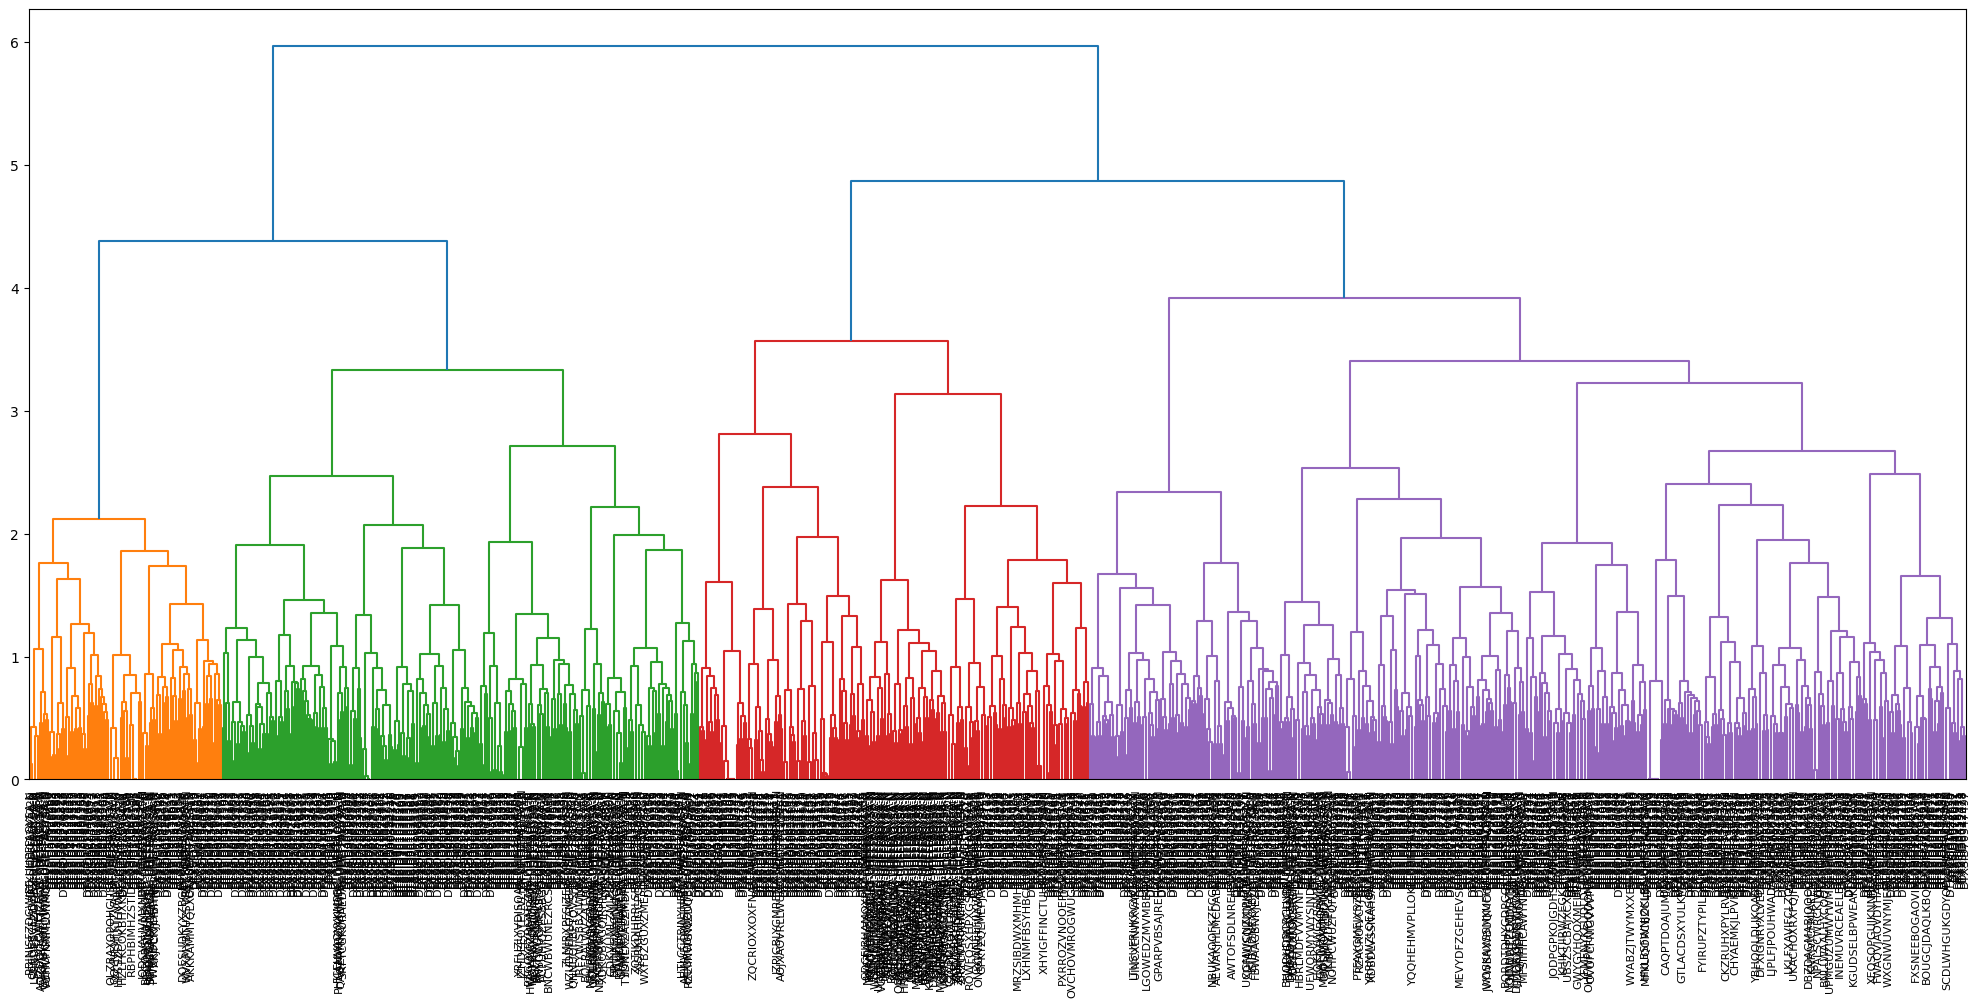

In [210]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[9]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Other aliphatics', 'lt7'), 2.0)].index# font size for the x axis labels
)
plt.show()

In [211]:
max_d = 4
nextgen_dist6 = fcluster(summaries_nextgen[9]['Z'], max_d, criterion='maxclust')
nextgen_dist6
dist_nextgen6 = pd.DataFrame(list(zip(next_gen_FPs[(('Other aliphatics', 'lt7'), 2.0)].index, nextgen_dist6)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen6['category'] = 'Other aliphatics'
dist_nextgen6['subcategory'] = 'lt7'
dist_nextgen6['cluster'] = 2
dist_nextgen6 = dist_nextgen6[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

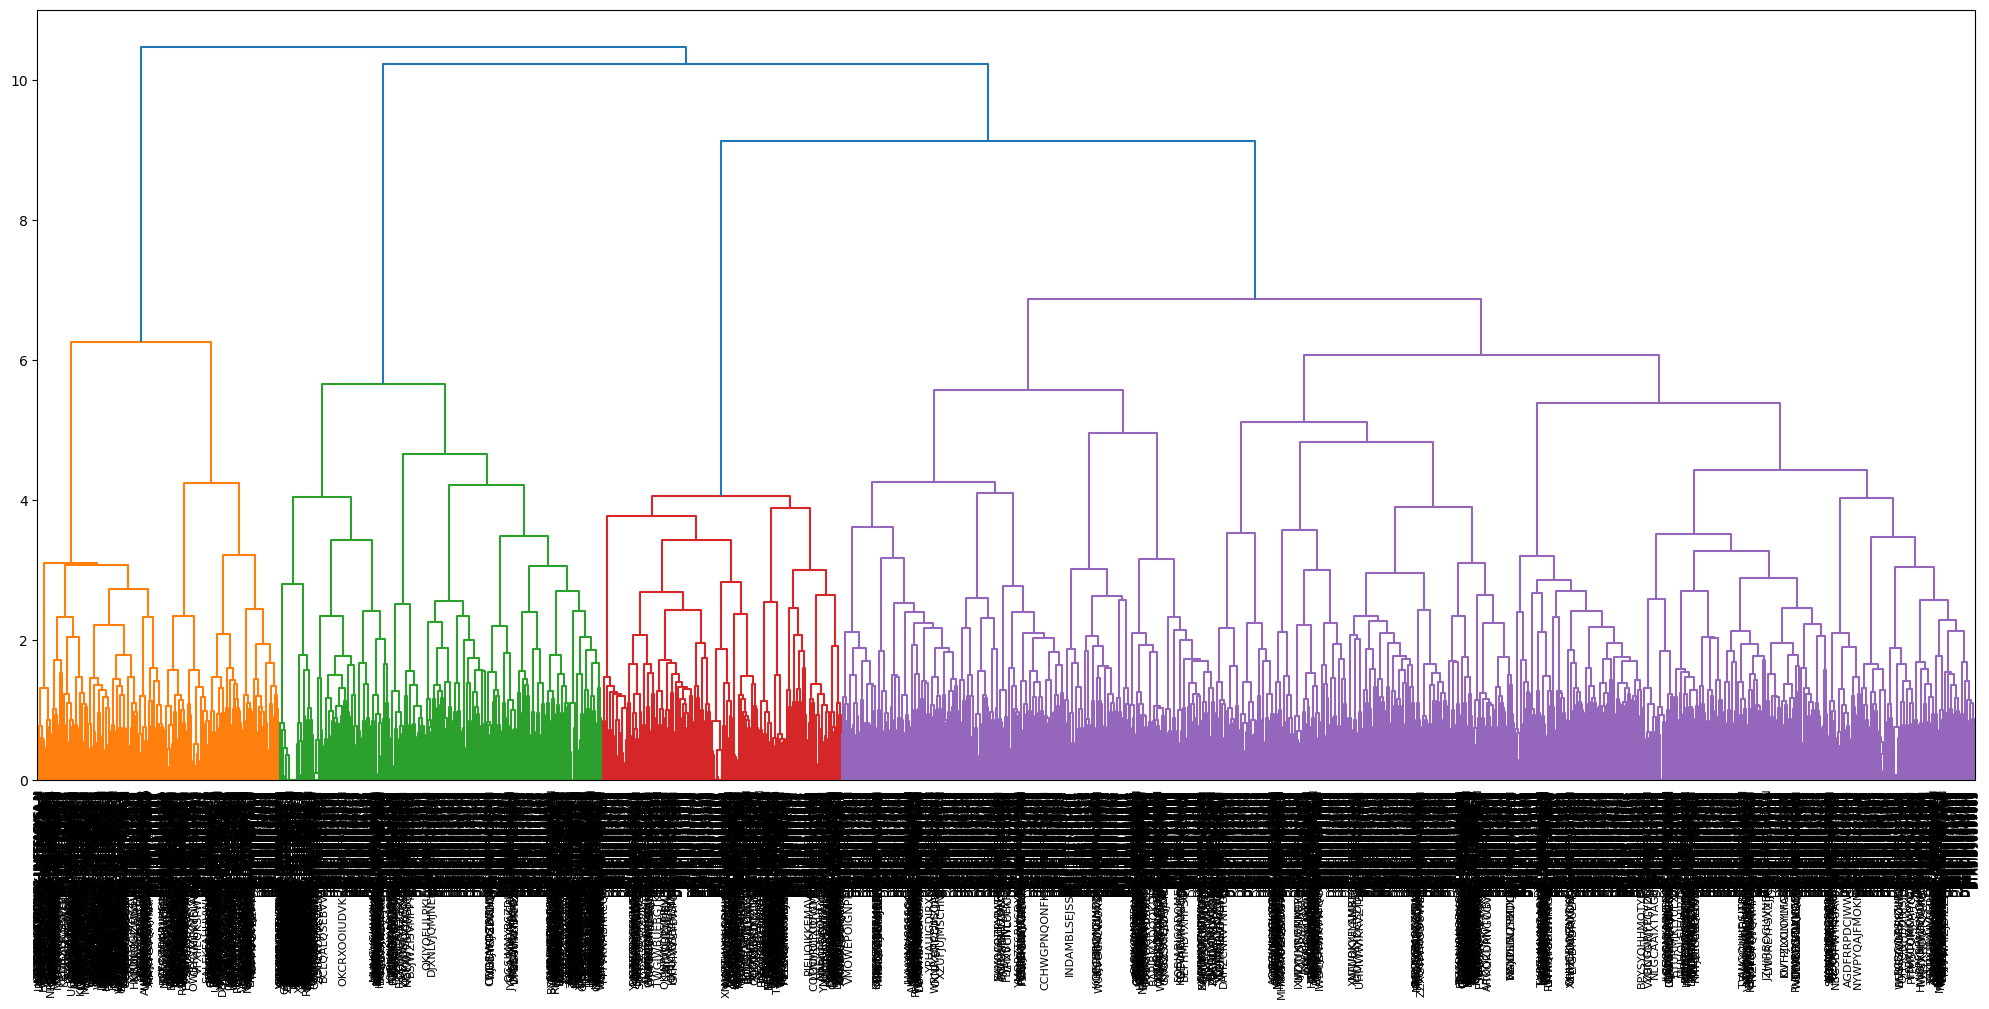

In [212]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[10]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Other aliphatics', 'lt7'), 3.0)].index# font size for the x axis labels
)
plt.show()

In [213]:
max_d = 4
nextgen_dist7 = fcluster(summaries_nextgen[10]['Z'], max_d, criterion='maxclust')
nextgen_dist7
dist_nextgen7 = pd.DataFrame(list(zip(next_gen_FPs[(('Other aliphatics', 'lt7'), 3.0)].index, nextgen_dist7)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen7['category'] = 'Other aliphatics'
dist_nextgen7['subcategory'] = 'lt7'
dist_nextgen7['cluster'] = 3
dist_nextgen7 = dist_nextgen7[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

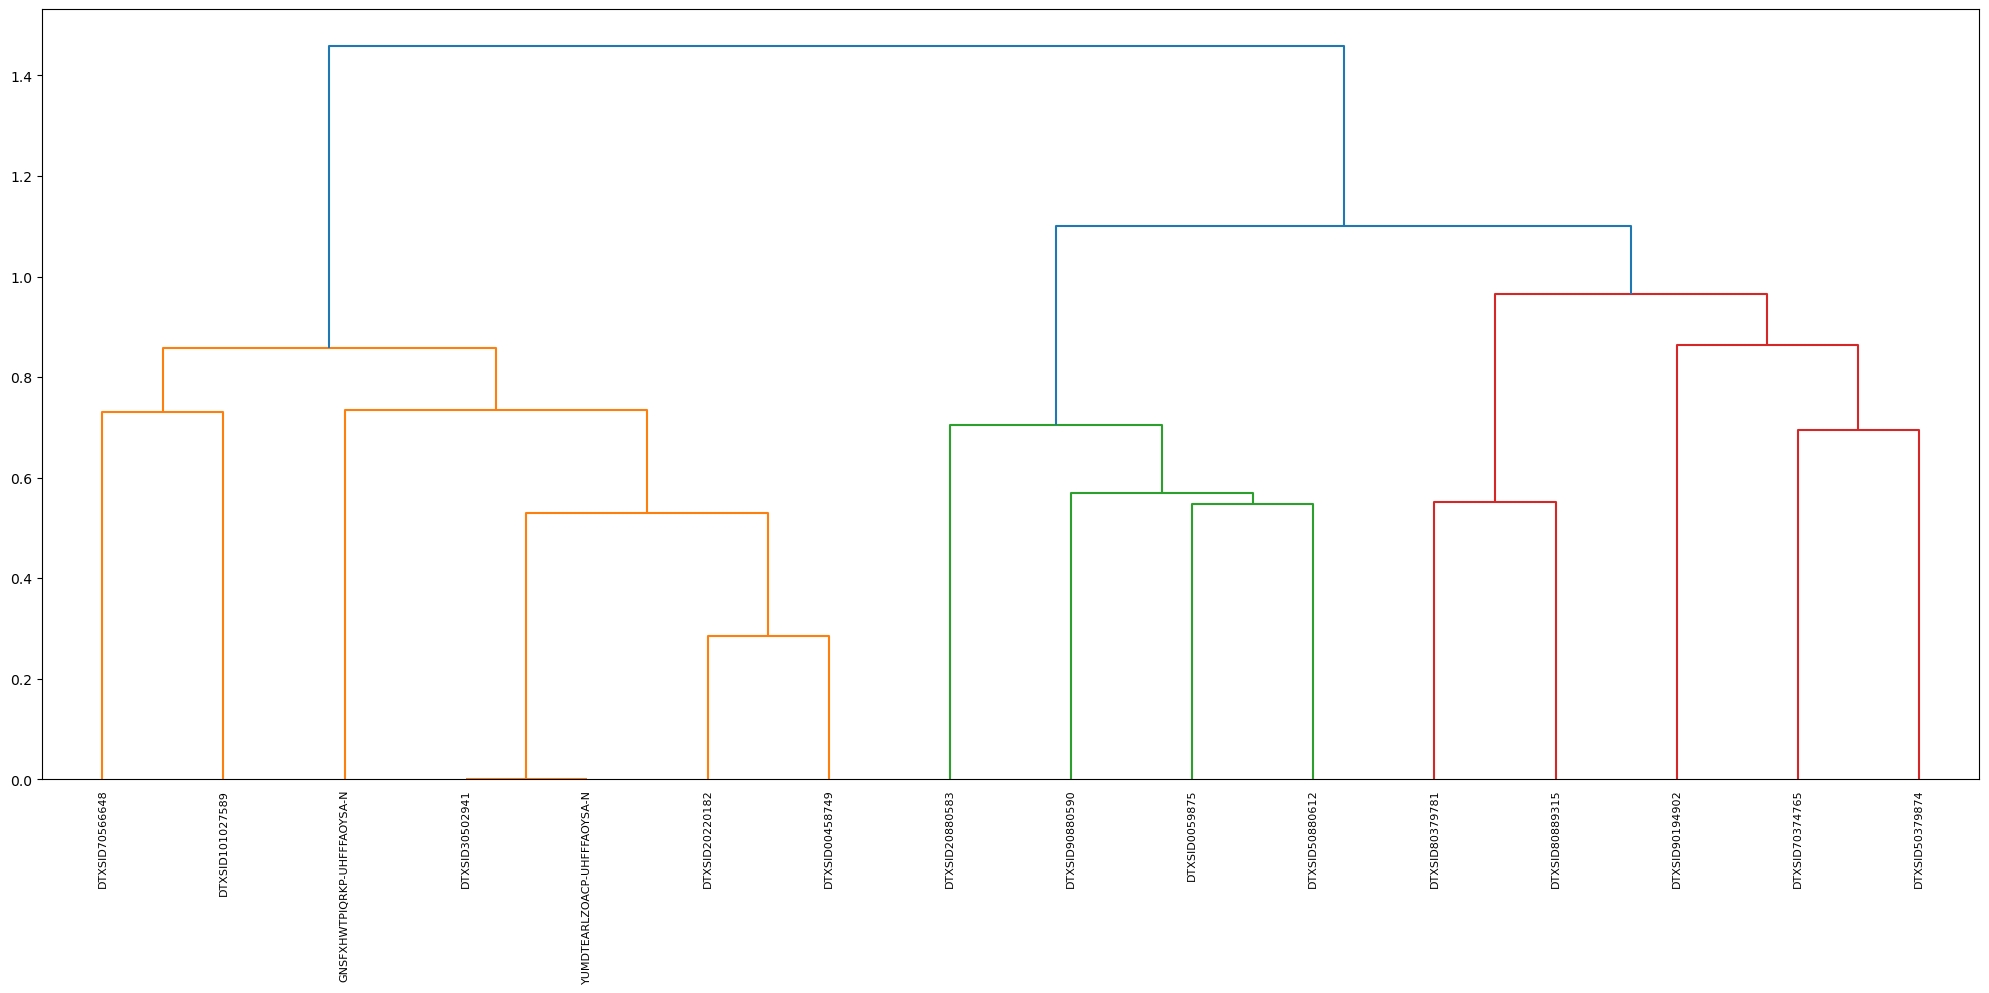

In [214]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[11]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('PFAA precursors', 'lt7'), 1.0)].index# font size for the x axis labels
)
plt.show()


In [215]:
max_d = 3
nextgen_dist8 = fcluster(summaries_nextgen[11]['Z'], max_d, criterion='maxclust')
nextgen_dist8
dist_nextgen8 = pd.DataFrame(list(zip(next_gen_FPs[(('PFAA precursors', 'lt7'), 1.0)].index, nextgen_dist8)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen8['category'] = 'PFAA precursors'
dist_nextgen8['subcategory'] = 'lt7'
dist_nextgen8['cluster'] = 1
dist_nextgen8 = dist_nextgen8[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

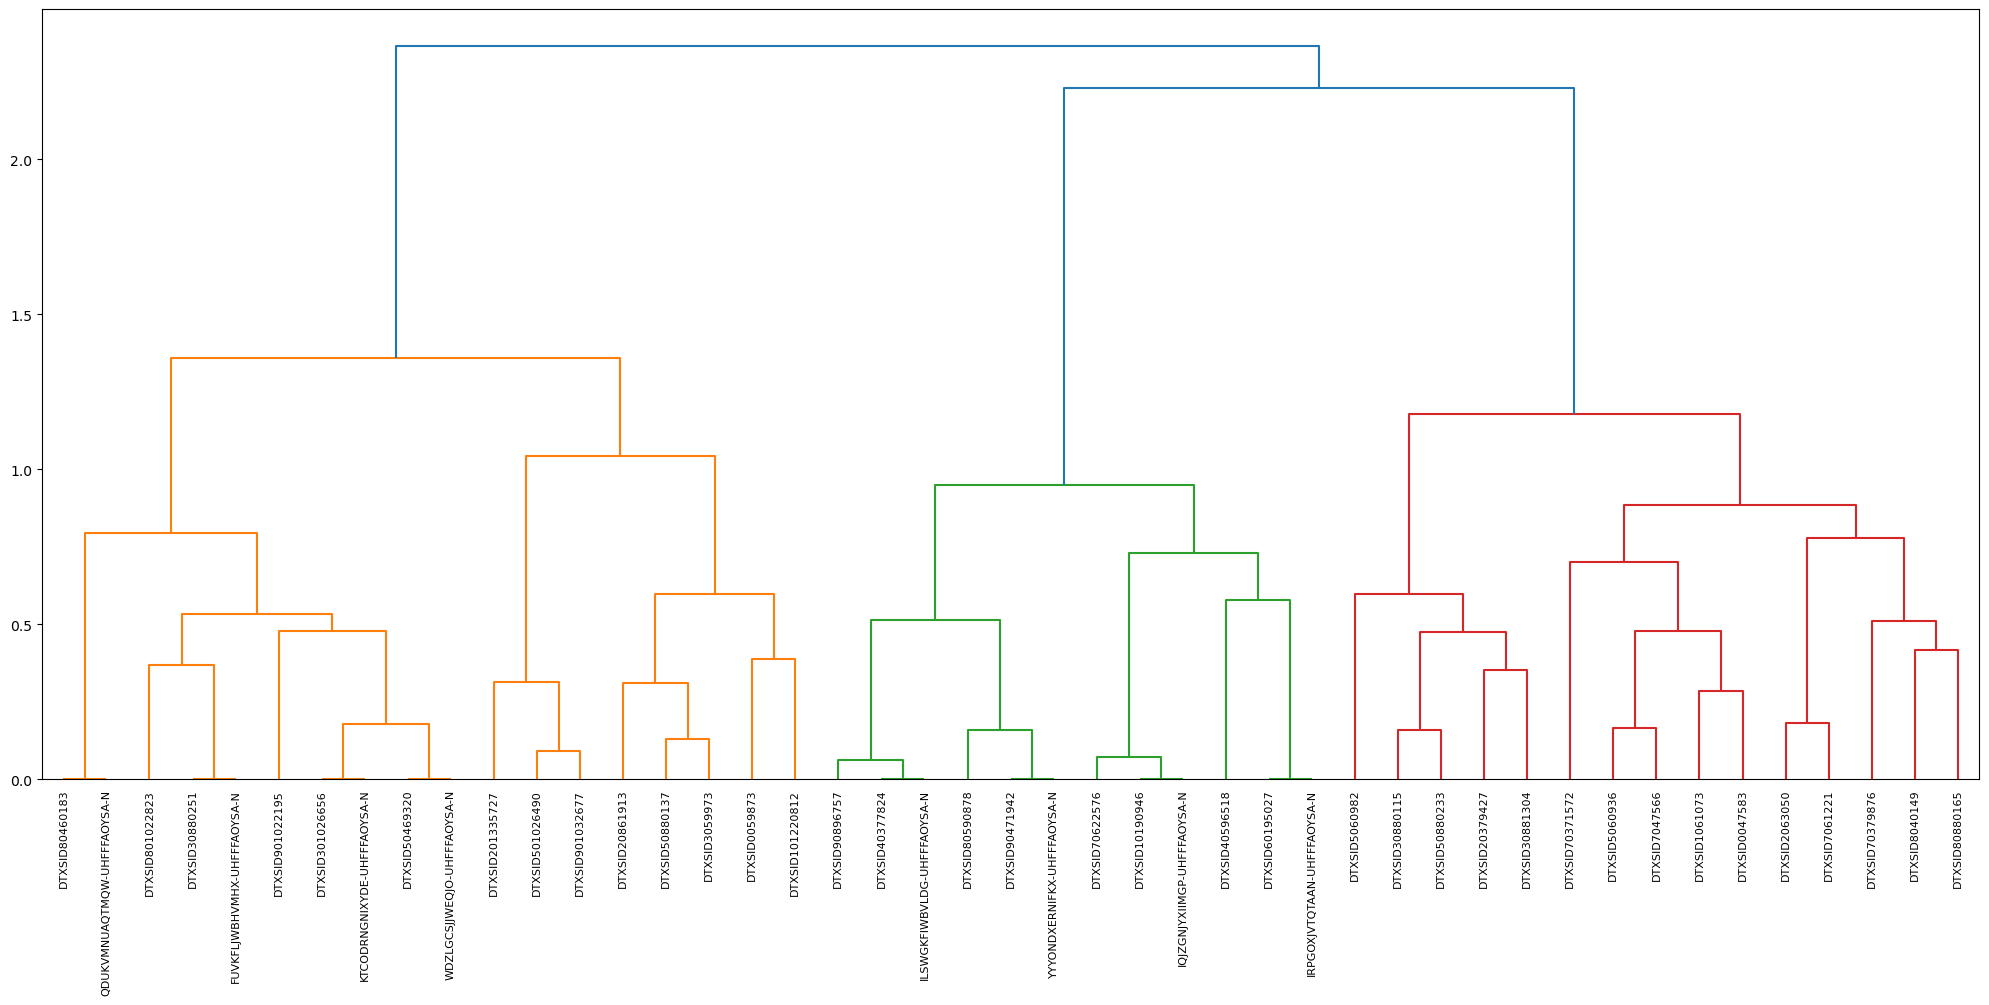

In [216]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[13]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('PFAA precursors', 'lt7'), 3.0)].index# font size for the x axis labels
)
plt.show()

In [217]:
max_d = 3
nextgen_dist9 = fcluster(summaries_nextgen[13]['Z'], max_d, criterion='maxclust')
nextgen_dist9
dist_nextgen9 = pd.DataFrame(list(zip(next_gen_FPs[(('PFAA precursors', 'lt7'), 3.0)].index, nextgen_dist9)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen9['category'] = 'PFAA precursors'
dist_nextgen9['subcategory'] = 'lt7'
dist_nextgen9['cluster'] = 3
dist_nextgen9 = dist_nextgen9[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]


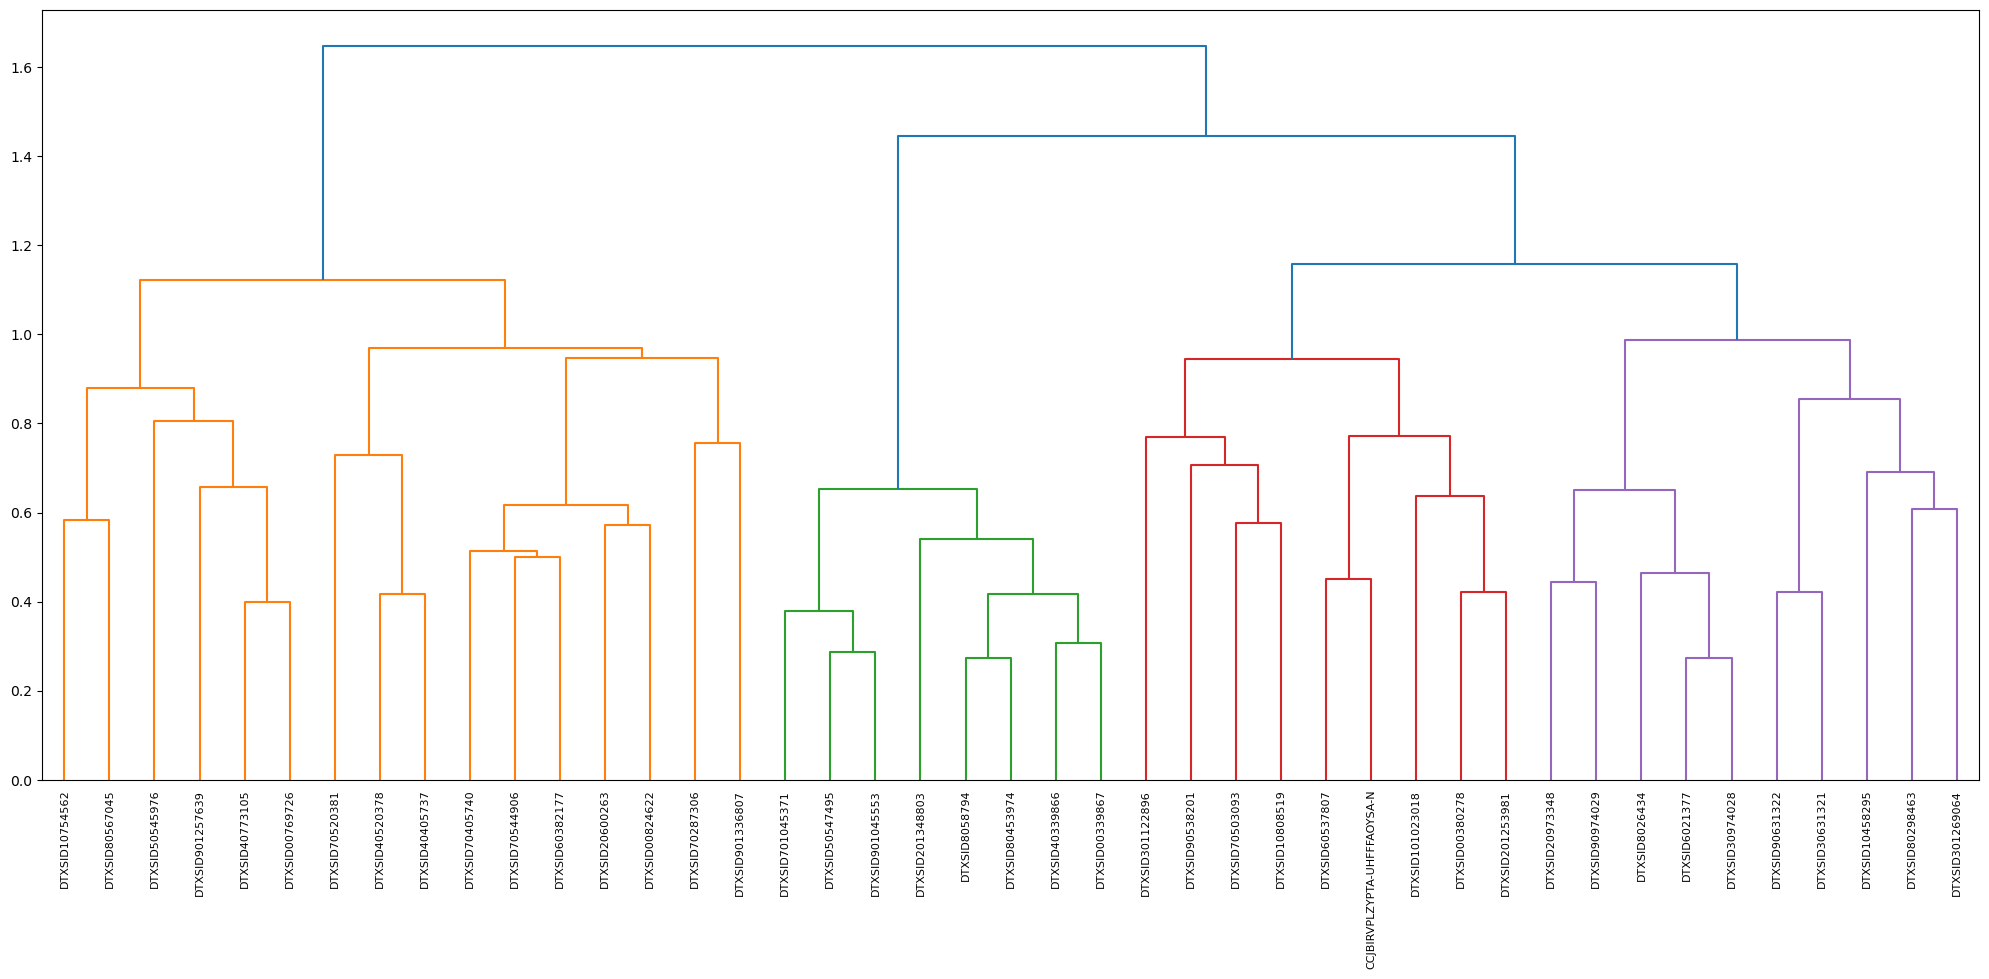

In [218]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[19]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('PFAS derivatives', 'lt7'), 2.0)].index# font size for the x axis labels
)
plt.show()


In [219]:
max_d =3
nextgen_dist10 = fcluster(summaries_nextgen[19]['Z'], max_d, criterion='maxclust')
nextgen_dist10
dist_nextgen10 = pd.DataFrame(list(zip(next_gen_FPs[(('PFAS derivatives', 'lt7'), 2.0)].index, nextgen_dist10)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen10['category'] = 'PFAS derivatives'
dist_nextgen10['subcategory'] = 'lt7'
dist_nextgen10['cluster'] = 2
dist_nextgen10 = dist_nextgen10[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

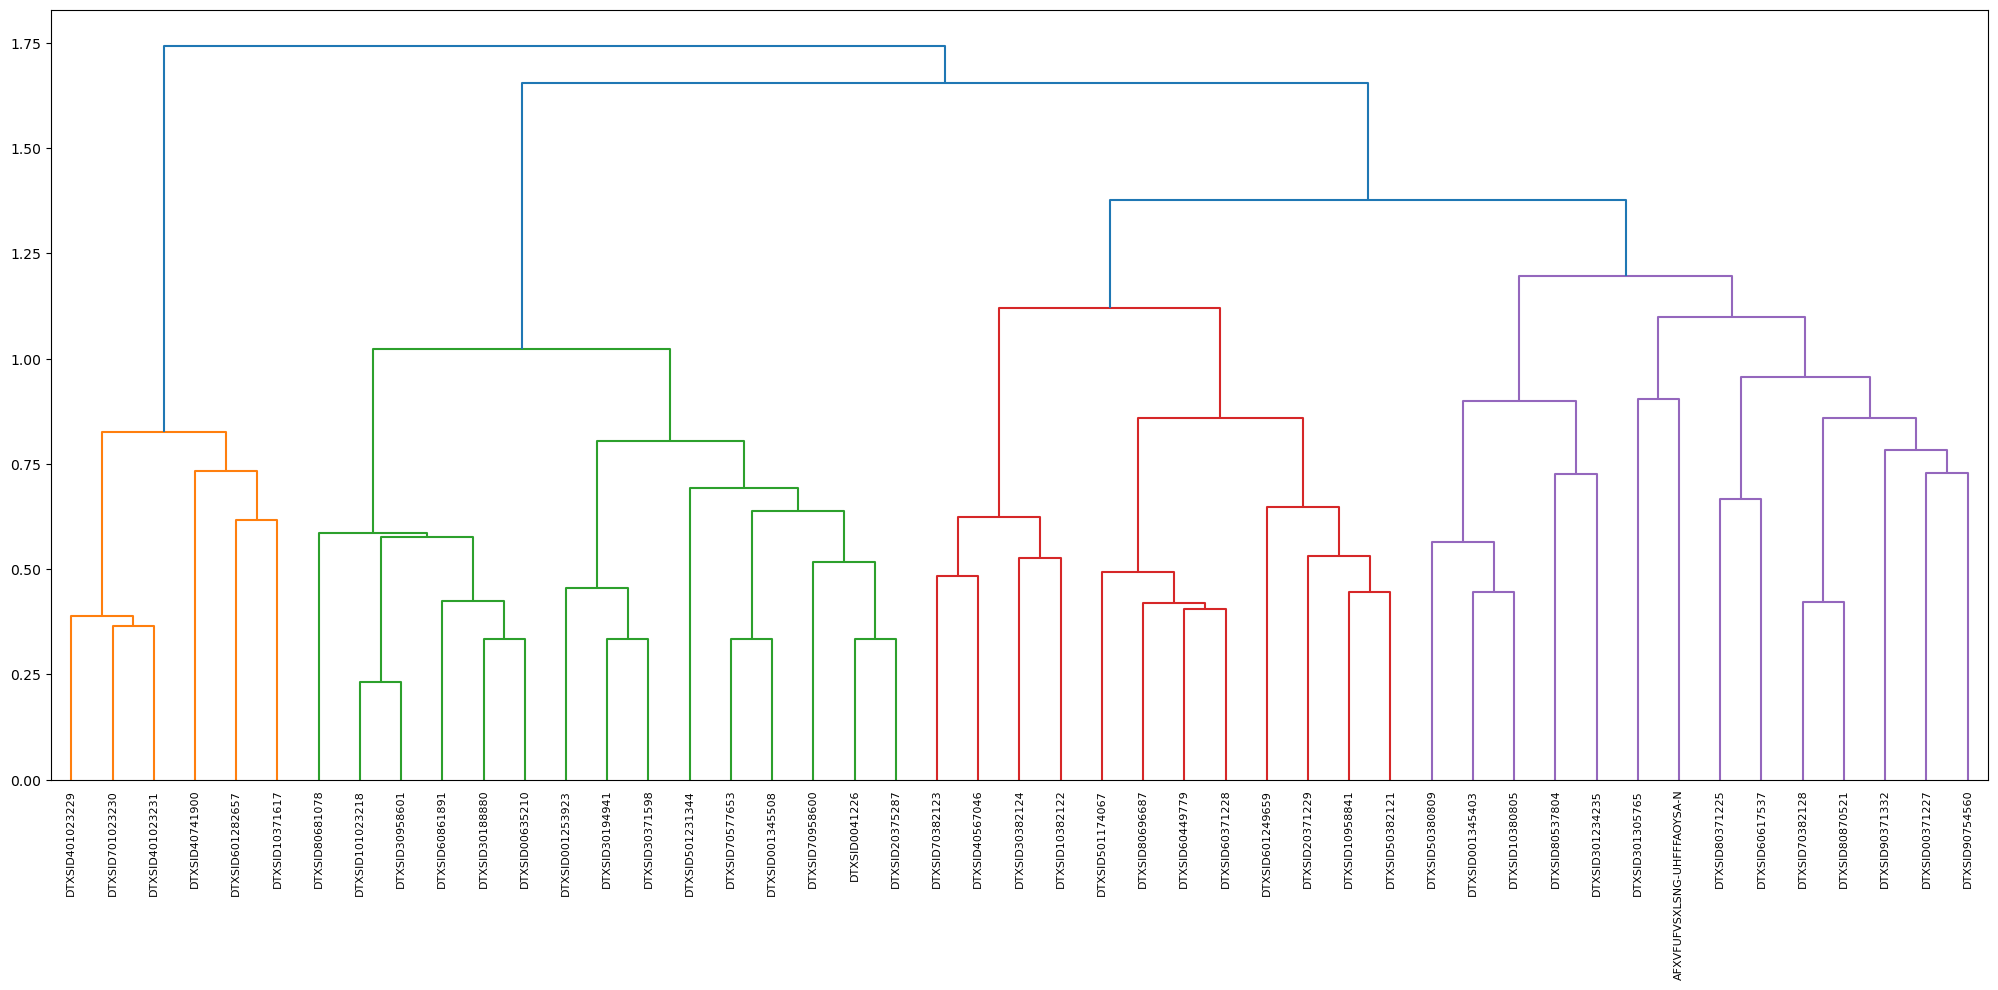

In [220]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[21]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('PFAS derivatives', 'lt7'), 4.0)].index# font size for the x axis labels
)
plt.show()

In [221]:
max_d = 4
nextgen_dist11 = fcluster(summaries_nextgen[21]['Z'], max_d, criterion='maxclust')
nextgen_dist11
dist_nextgen11 = pd.DataFrame(list(zip(next_gen_FPs[(('PFAS derivatives', 'lt7'), 4.0)].index, nextgen_dist11)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen11['category'] = 'PFAS derivatives'
dist_nextgen11['subcategory'] = 'lt7'
dist_nextgen11['cluster'] = 4
dist_nextgen11 = dist_nextgen11[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]


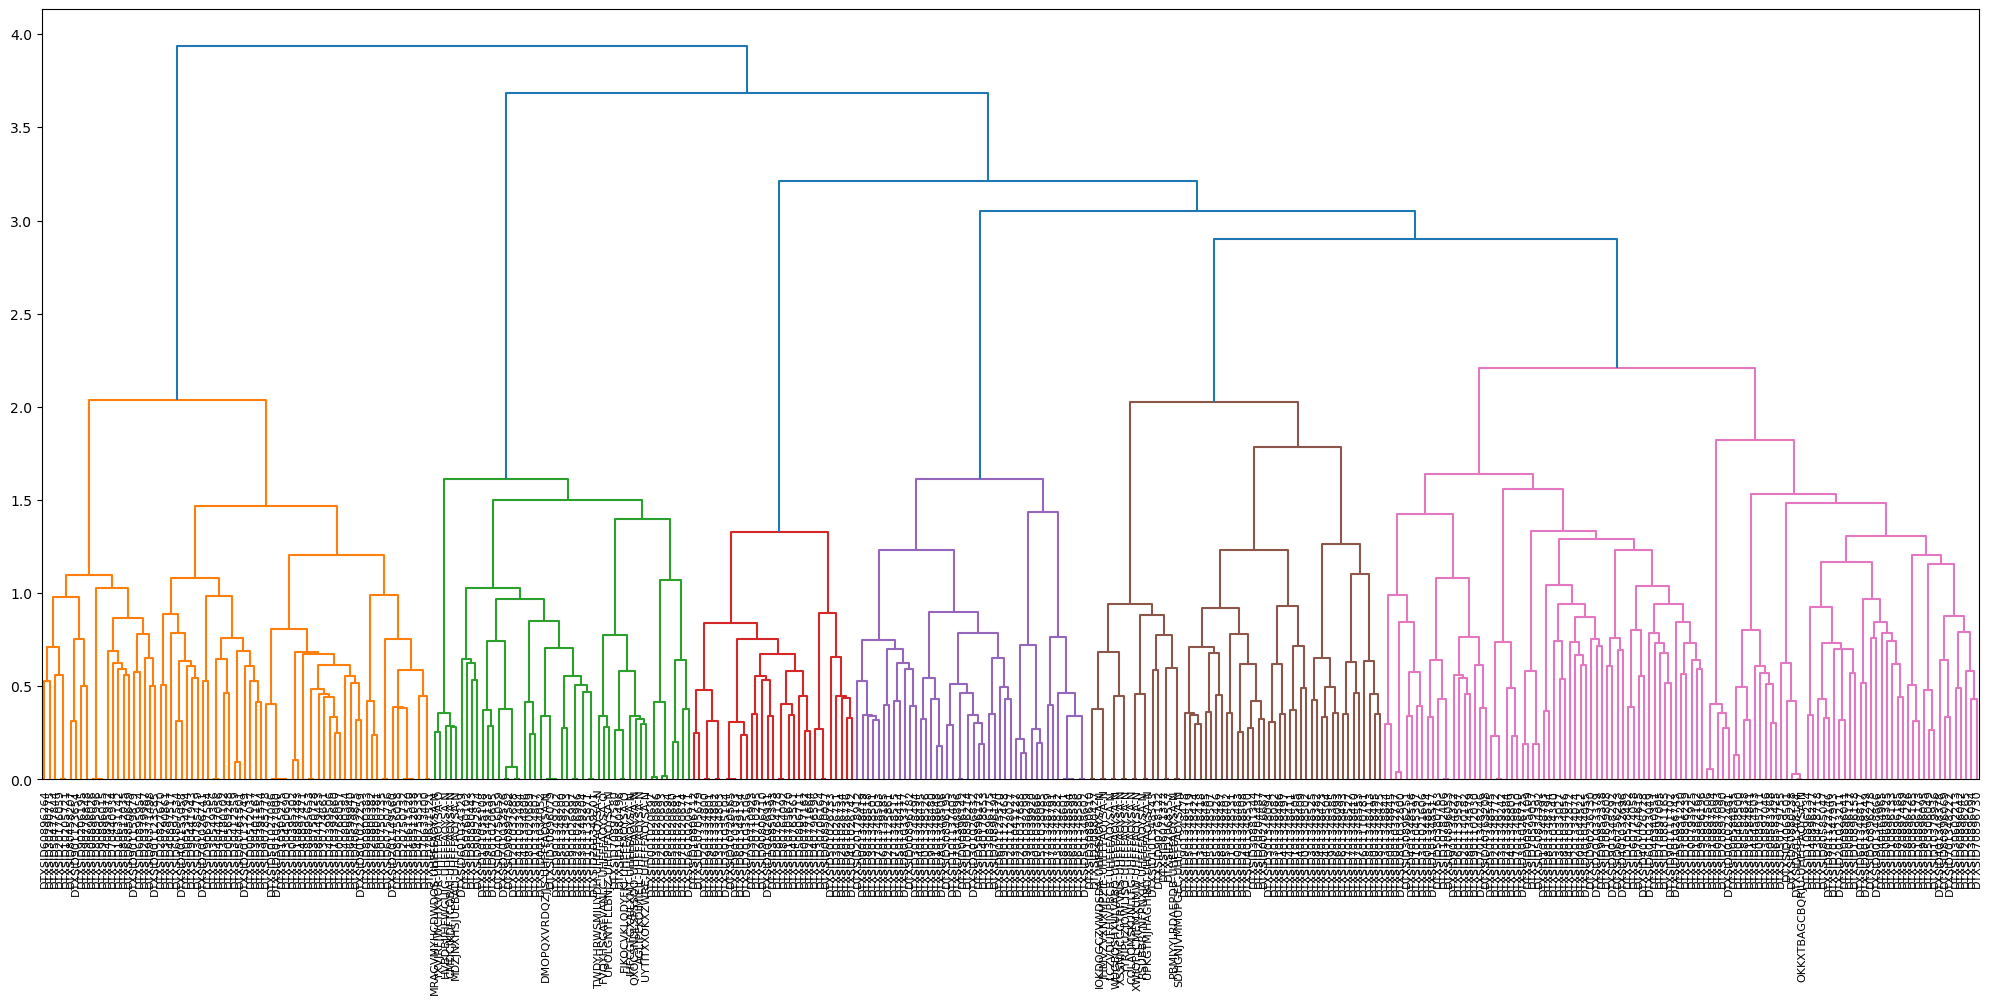

In [222]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[22]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Side-chain aromatics', 'gte7'), 1.0)].index# font size for the x axis labels
)
plt.show()


In [223]:
max_d = 3
nextgen_dist12 = fcluster(summaries_nextgen[22]['Z'], max_d, criterion='maxclust')
nextgen_dist12
dist_nextgen12 = pd.DataFrame(list(zip(next_gen_FPs[(('Side-chain aromatics', 'gte7'), 1.0)].index, nextgen_dist12)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen12['category'] = 'Side-chain aromatics'
dist_nextgen12['subcategory'] = 'gte7'
dist_nextgen12['cluster'] = 1
dist_nextgen12 = dist_nextgen12[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]


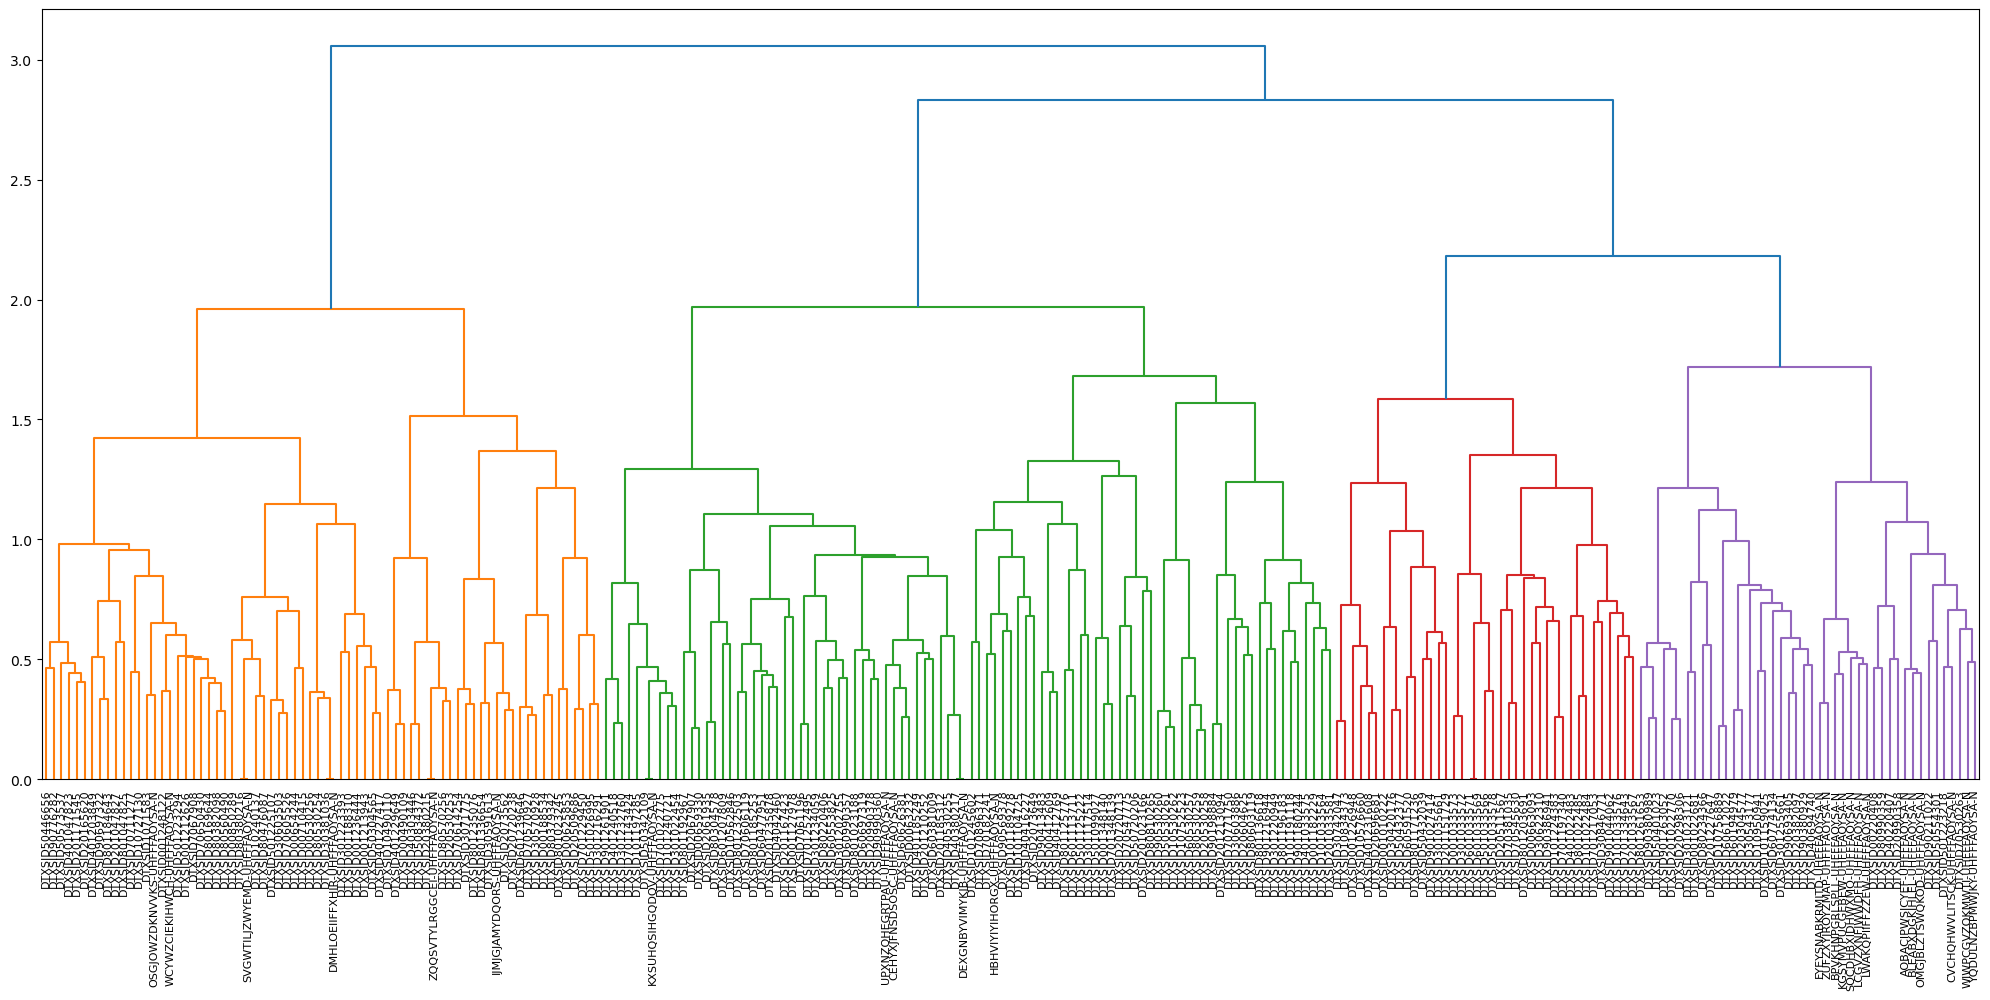

In [224]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[26]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Side-chain aromatics', 'lt7'), 2.0)].index# font size for the x axis labels
)
plt.show()



In [225]:
max_d = 3
nextgen_dist13 = fcluster(summaries_nextgen[26]['Z'], max_d, criterion='maxclust')
nextgen_dist13
dist_nextgen13 = pd.DataFrame(list(zip(next_gen_FPs[(('Side-chain aromatics', 'lt7'), 2.0)].index, nextgen_dist13)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen13['category'] = 'Side-chain aromatics'
dist_nextgen13['subcategory'] = 'lt7'
dist_nextgen13['cluster'] = 2
dist_nextgen13 = dist_nextgen13[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

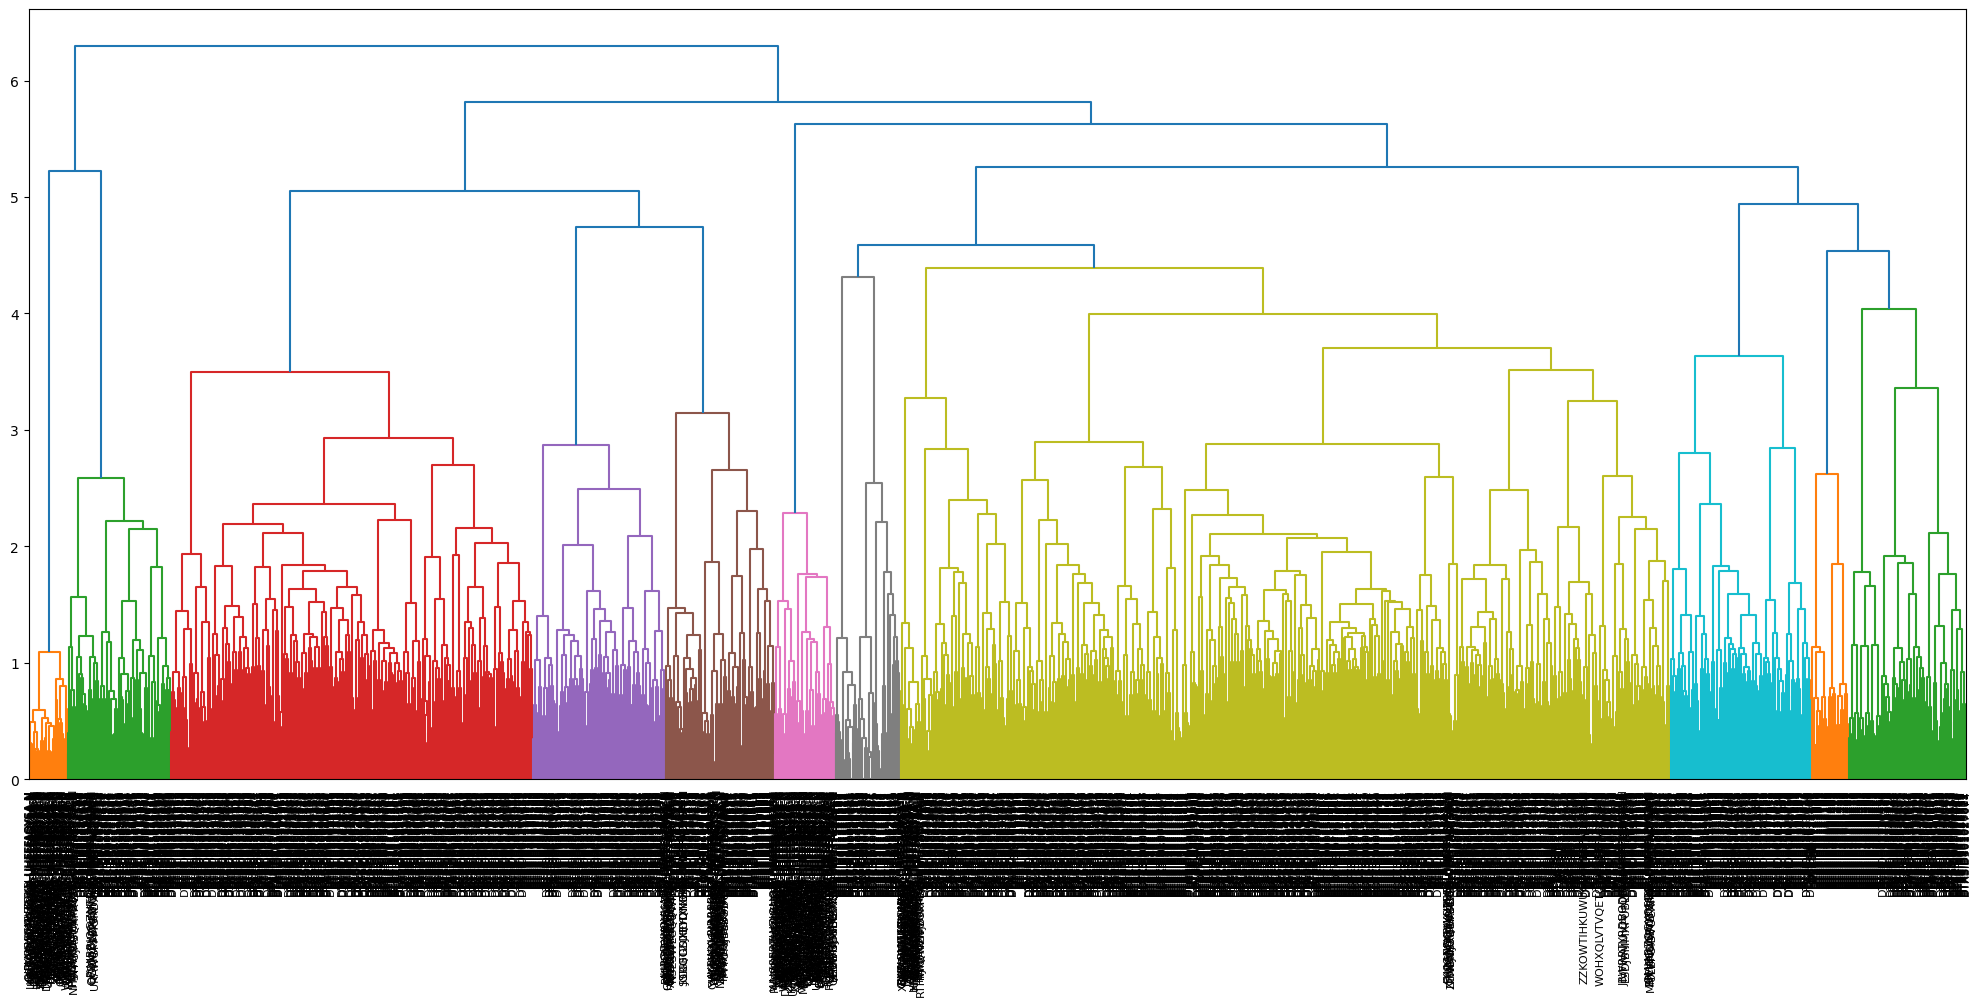

In [226]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[27]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Side-chain aromatics', 'lt7'), 3.0)].index# font size for the x axis labels
)
plt.show()

In [227]:
max_d = 3
nextgen_dist14 = fcluster(summaries_nextgen[27]['Z'], max_d, criterion='maxclust')
nextgen_dist14
dist_nextgen14 = pd.DataFrame(list(zip(next_gen_FPs[(('Side-chain aromatics', 'lt7'), 3.0)].index, nextgen_dist14)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen14['category'] = 'Side-chain aromatics'
dist_nextgen14['subcategory'] = 'lt7'
dist_nextgen14['cluster'] = 3
dist_nextgen14 = dist_nextgen14[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

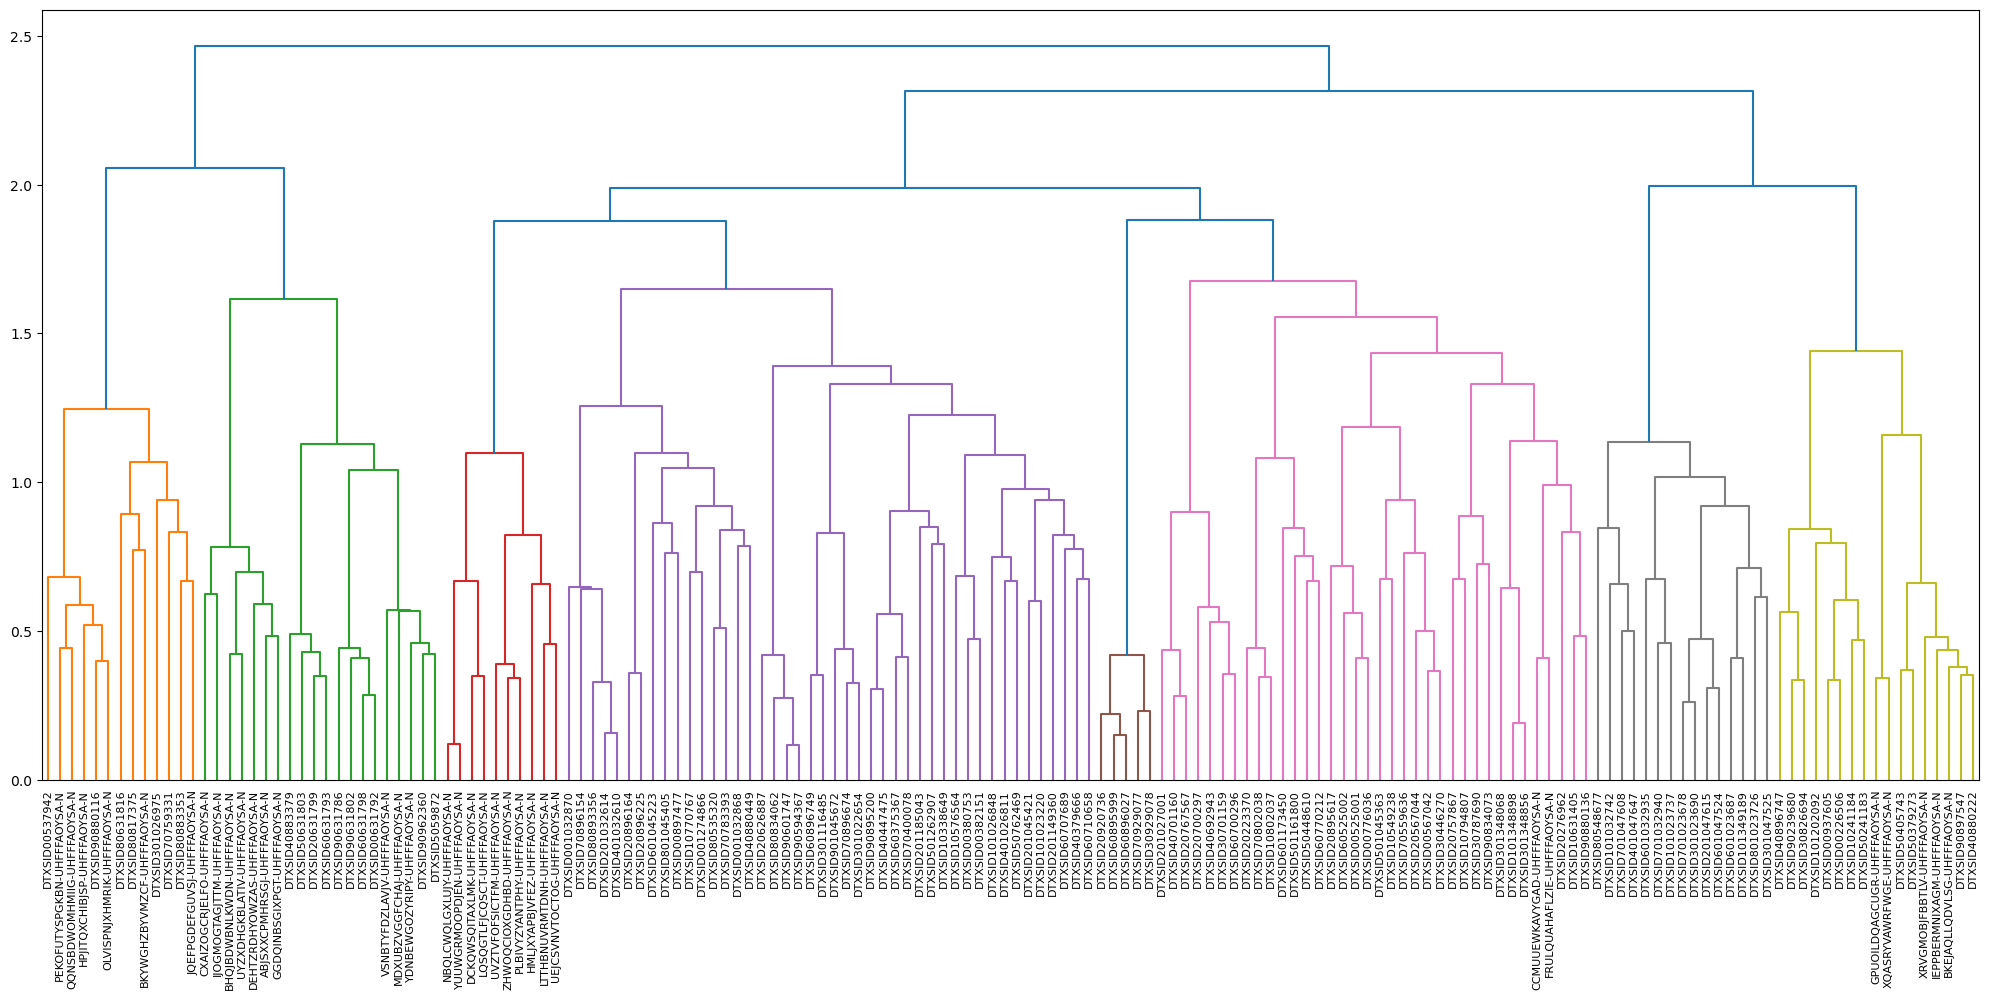

In [228]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[30]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('Silicon PFASs', 'lt7'), 3.0)].index# font size for the x axis labels
)
plt.show()

In [229]:
max_d = 3
nextgen_dist15 = fcluster(summaries_nextgen[30]['Z'], max_d, criterion='maxclust')
nextgen_dist15
dist_nextgen15 = pd.DataFrame(list(zip(next_gen_FPs[(('Silicon PFASs', 'lt7'), 3.0)].index, nextgen_dist15)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen15['category'] = 'Silicon PFASs'
dist_nextgen15['subcategory'] = 'lt7'
dist_nextgen15['cluster'] = 3
dist_nextgen15 = dist_nextgen15[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

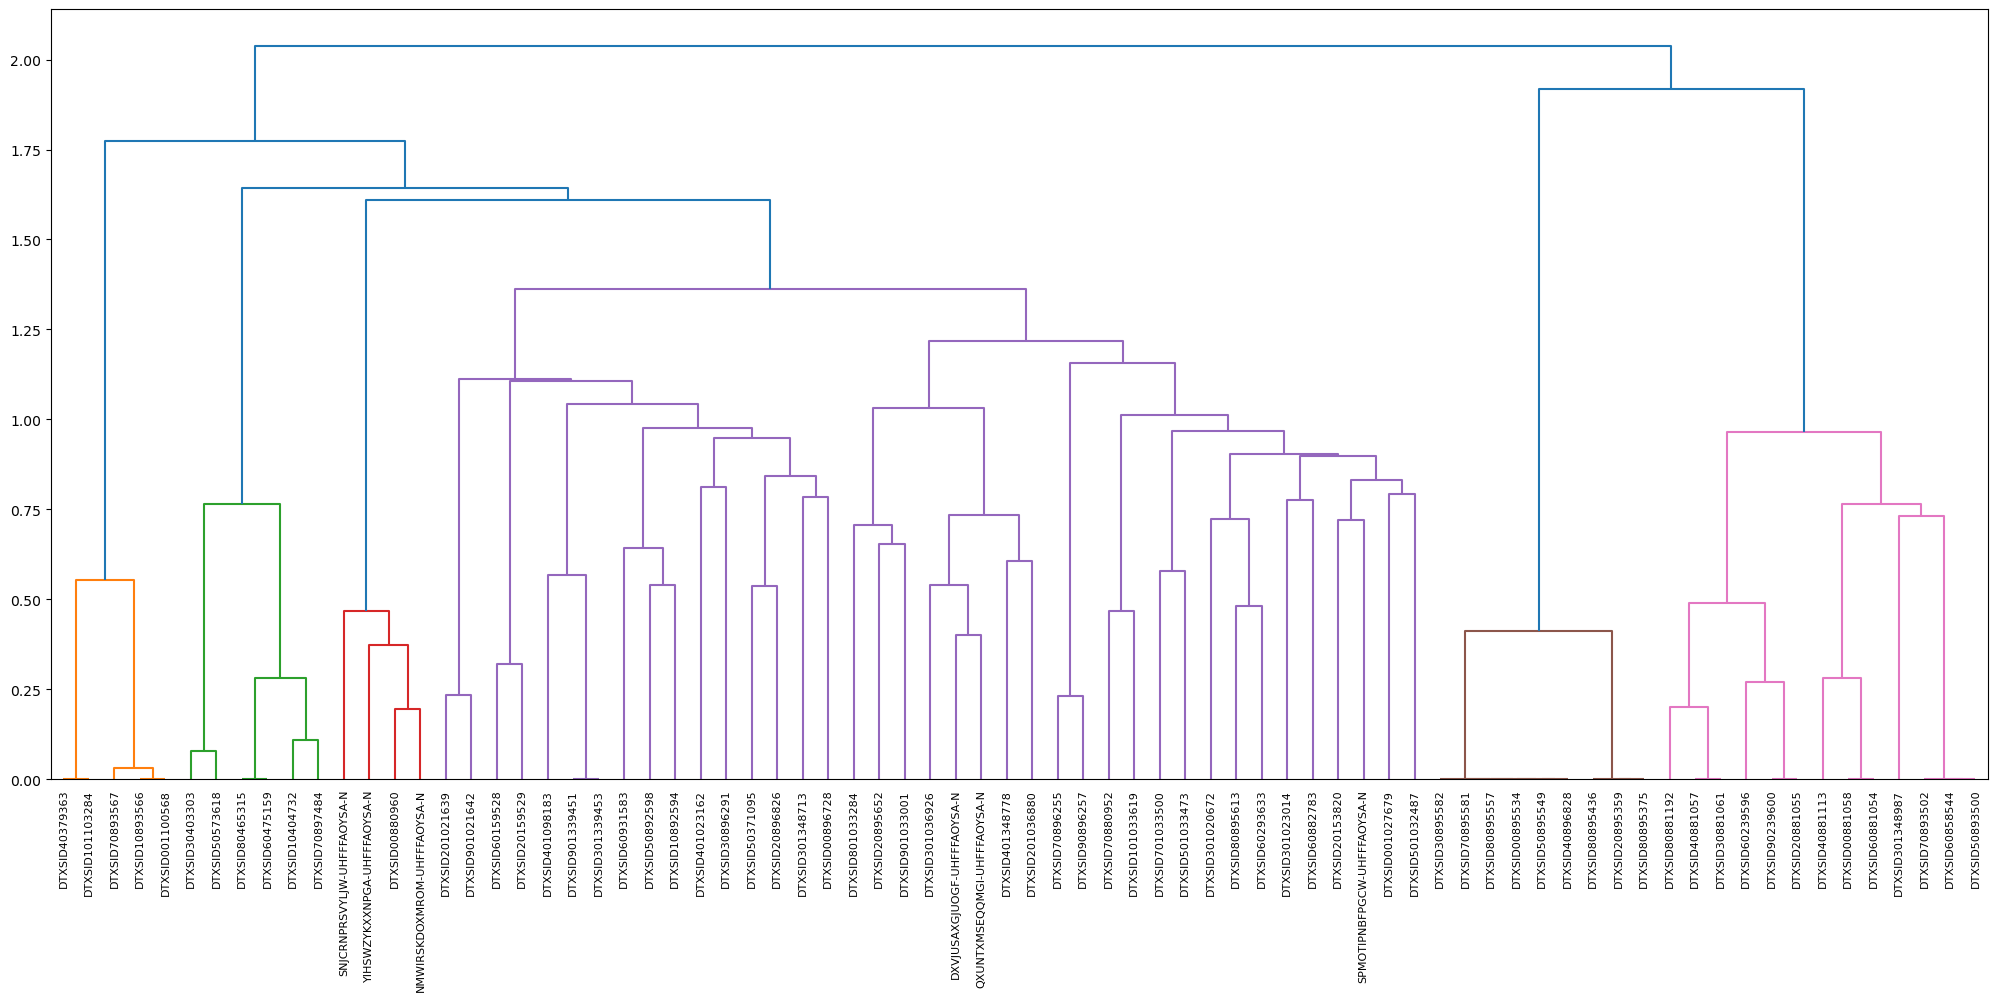

In [230]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[33]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('unclassified', 'gte7'), 3.0)].index# font size for the x axis labels
)
plt.show()


In [231]:
max_d = 4
nextgen_dist16 = fcluster(summaries_nextgen[33]['Z'], max_d, criterion='maxclust')
nextgen_dist16
dist_nextgen16 = pd.DataFrame(list(zip(next_gen_FPs[(('unclassified', 'gte7'), 3.0)].index, nextgen_dist16)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen16['category'] = 'unclassified'
dist_nextgen16['subcategory'] = 'gte7'
dist_nextgen16['cluster'] = 3
dist_nextgen16 = dist_nextgen16[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

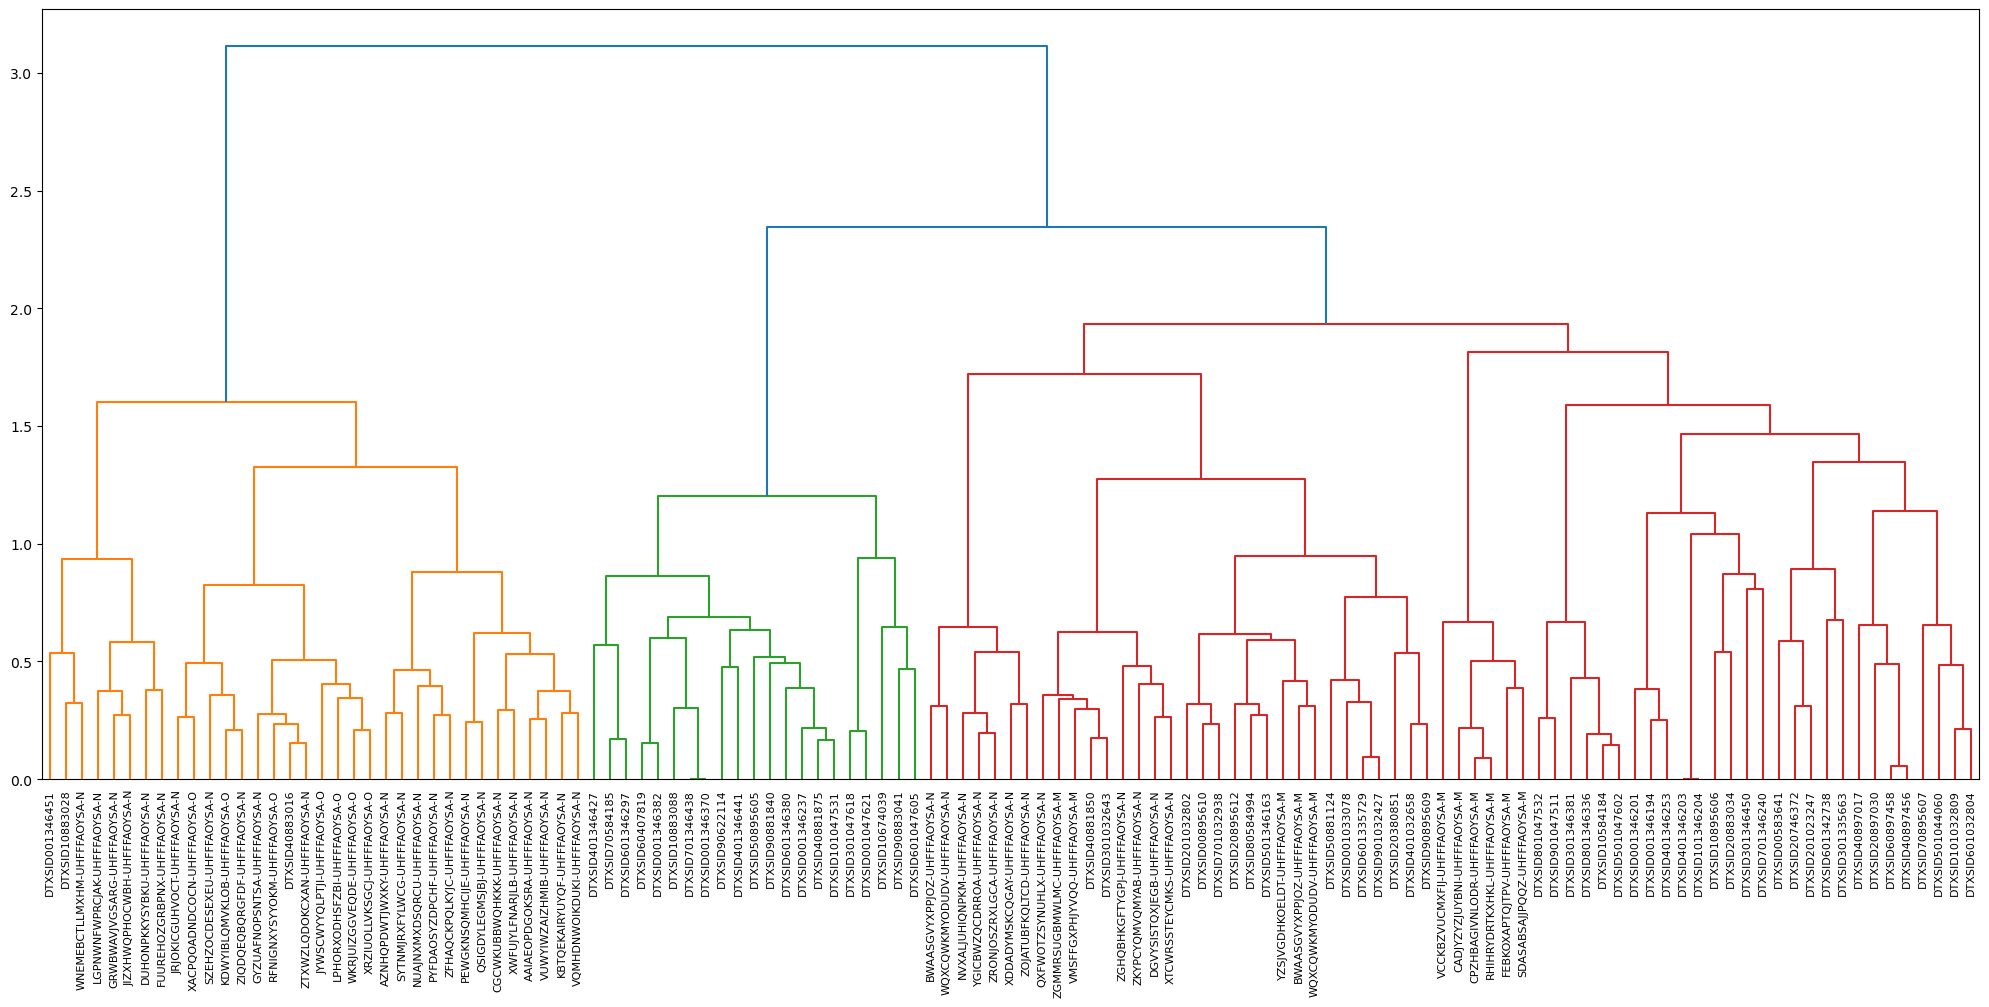

In [232]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[36]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('unclassified', 'lt7'), 2.0)].index# font size for the x axis labels
)
plt.show()

In [233]:
max_d = 3
nextgen_dist17 = fcluster(summaries_nextgen[36]['Z'], max_d, criterion='maxclust')
nextgen_dist17
dist_nextgen17 = pd.DataFrame(list(zip(next_gen_FPs[(('unclassified', 'lt7'), 2.0)].index, nextgen_dist17)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen17['category'] = 'unclassified'
dist_nextgen17['subcategory'] = 'lt7'
dist_nextgen17['cluster'] = 2
dist_nextgen17 = dist_nextgen17[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]


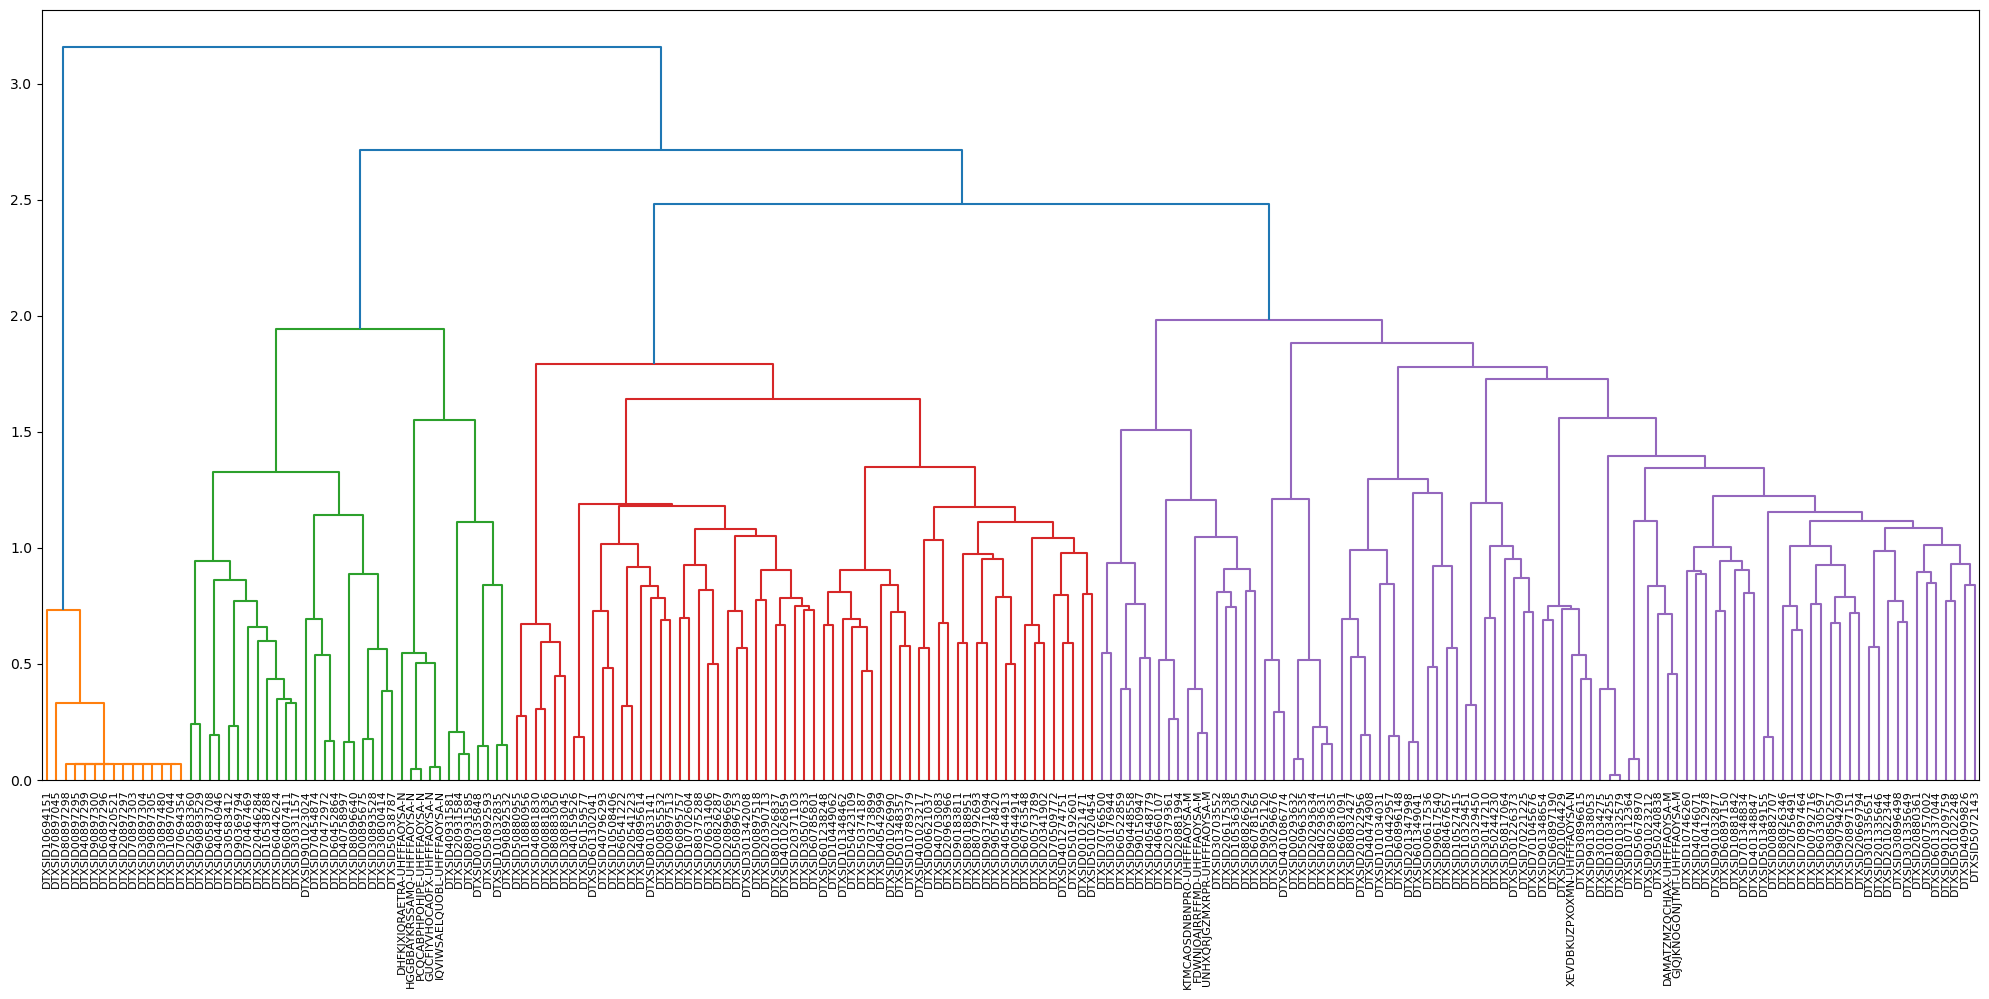

In [234]:
plt.figure(figsize=(25, 10))
dendrogram(
    summaries_nextgen[37]['Z'],
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = next_gen_FPs[(('unclassified', 'lt7'), 3.0)].index# font size for the x axis labels
)
plt.show()

In [235]:
max_d = 4
nextgen_dist18 = fcluster(summaries_nextgen[37]['Z'], max_d, criterion='maxclust')
nextgen_dist18
dist_nextgen18 = pd.DataFrame(list(zip(next_gen_FPs[(('unclassified', 'lt7'), 3.0)].index, nextgen_dist18)), columns = ['dtxsid', 'lvl_cluster_d'])
dist_nextgen18['category'] = 'unclassified'
dist_nextgen18['subcategory'] = 'lt7'
dist_nextgen18['cluster'] = 3
dist_nextgen18 = dist_nextgen18[['dtxsid', 'lvl_cluster_d',  'category','subcategory', 'cluster']]

In [236]:
nextgen_clusters_df = pd.concat([dist_nextgen, dist_nextgen1, dist_nextgen2, dist_nextgen3, dist_nextgen4, dist_nextgen5, \
                                 dist_nextgen6, dist_nextgen7, dist_nextgen8, dist_nextgen9, dist_nextgen10, dist_nextgen11, \
                                 dist_nextgen12, dist_nextgen13, dist_nextgen14, dist_nextgen15, dist_nextgen16, dist_nextgen17,dist_nextgen18 \
                                 ])

In [237]:
3+3+3+3+3+4+4+4+3+3+3+4+3+3+3+3+4+3+4

63

In [238]:
nextgen_clusters_df.groupby(['category', 'subcategory', 'cluster', 'lvl_cluster_d']).size().reset_index().shape

(63, 5)

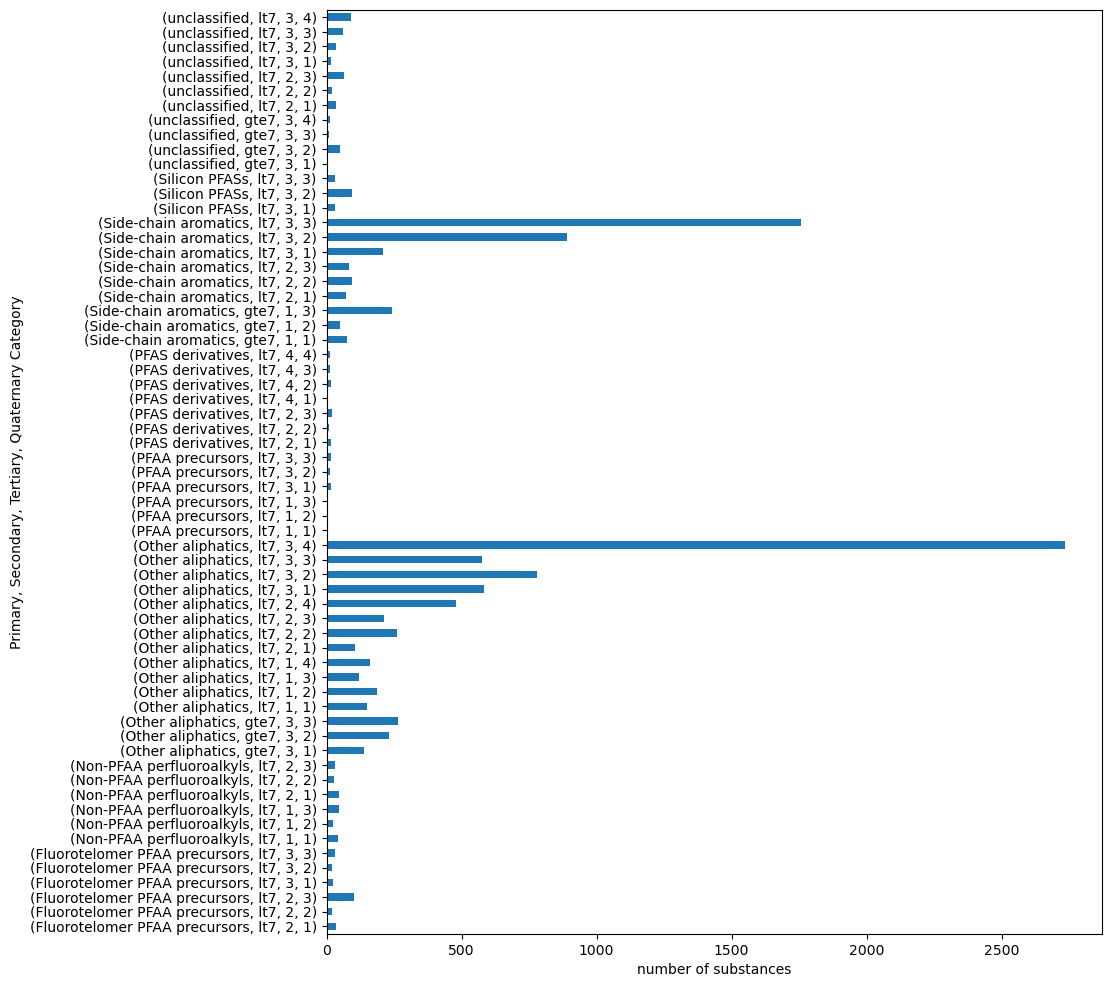

In [239]:
plt.figure(figsize = (10,12))
nextgen_clusters_df.groupby(['category', 'subcategory', 'cluster', 'lvl_cluster_d']).size().plot.barh()
plt.ylabel('Primary, Secondary, Tertiary, Quaternary Category')
plt.xlabel('number of substances')
plt.savefig(figures_dir+'Figure5_061123.png', dpi = 300, bbox_inches='tight');

In [240]:
next_gen_wlvl2_clusters = pd.merge(next_gen, nextgen_clusters_df[['dtxsid', 'lvl_cluster_d']], on = 'dtxsid', how = 'left')

In [241]:
nextgen_cats = pd.merge(next_gen, nextgen_clusters_df[['dtxsid', 'lvl_cluster_d']], on = 'dtxsid', how = 'left')

In [242]:
nextgen_cats = nextgen_cats[nextgen_cats['lvl_cluster_d'].notnull()]

In [243]:
results_nextgencats = {}
for i, group in nextgen_cats.groupby(['category', 'subcategory', 'cluster_d', 'lvl_cluster_d']):
    try:
        a = mk_fp(group)
    except Exception as error:
        print(error)
    else:
        results_nextgencats[i] = a

In [244]:
distances_nextgencats = {}
for k,v in results_nextgencats.items():
    a = distance_matrix(results_nextgencats[k])
    distances_nextgencats[k] = a

In [245]:
centres_2 = []
for i,group in nextgen_cats.groupby(['category', 'subcategory', 'cluster_d', 'lvl_cluster_d']):
    #print(i)
    try:
        m = medoid_calc(distances_nextgencats[i])
        centres_2.append(m)
    except Exception as error:
        print(error)

In [246]:
len(centres_2)

63

In [248]:
next_gen['level3_cluster_centroid'] = next_gen['dtxsid'].apply(lambda x: 'centroid' if x in (centres_2) else np.nan)

In [249]:
new_df = pd.merge(next_gen, nextgen_clusters_df[['dtxsid', 'lvl_cluster_d']], on = 'dtxsid', how = 'left')

In [250]:
new_df.rename(columns = {'final_centroid': 'prelim_final_centroid', 'final_dist': 'prelim_final_dist'}, inplace = True)

In [251]:
new_df1 = new_df.set_index('dtxsid')

In [252]:
members_lvl3 = {}

for i, group in new_df1.groupby(['category', 'subcategory' ,'cluster_d','lvl_cluster_d' ]):
    subset = group[['lvl_cluster_d', 'level3_cluster_centroid']]
    try: 
        for x, y in subset.iterrows():
            a, b = y
            if b == 'centroid':
                #print(x)
                c = [distances_nextgencats[i][x].index, distances_nextgencats[i][x].values]
                members_lvl3[x] = c
    except Exception as error:
            print(error)

In [253]:
len(members_lvl3.keys())

63

In [254]:
cluster_members_lvl3 = pd.DataFrame(list(members_lvl3.items()))
cluster_members_lvl3.columns = ['lvl3_centroid', 1]
cluster_members_lvl3[['lvl3_analogues','lvl3_Dist']] = pd.DataFrame(cluster_members_lvl3[1].tolist(), index= cluster_members_lvl3.index)
cluster_members_lvl3.drop([1], axis = 1, inplace = True)
cluster_members_lvl3_1 = cluster_members_lvl3.apply(pd.Series.explode)

In [255]:
cluster_members_lvl3_1.head()

lvl3_centroid  lvl3_analogues lvl3_Dist
0  DTXSID90558000   DTXSID9066209  0.769231
0  DTXSID90558000   DTXSID2068763  0.773585
0  DTXSID90558000  DTXSID80562853  0.692308
0  DTXSID90558000   DTXSID1068772  0.647059
0  DTXSID90558000   DTXSID8061979  0.653846

In [256]:
new_df[new_df['lvl_cluster_d'].notnull()]

dtxsid DSSTox_QC-Level  \
556                  DTXSID5044572     DSSTox_High   
557                 DTXSID90171137      DSSTox_Low   
558                DTXSID701026672     DSSTox_High   
559                  DTXSID4059966     DSSTox_High   
560                DTXSID601032654      DSSTox_Low   
...                            ...             ...   
15409  IQVIWSAELQUOBL-UHFFFAOYSA-N             NaN   
15410  KTMCAOSDNBNPRO-UHFFFAOYSA-M             NaN   
15411  PCQCABPHPOHJPE-UHFFFAOYSA-N             NaN   
15412  UNHXQRJGZMXRPR-UHFFFAOYSA-M             NaN   
15413  XEVDBKUZPXOXMN-UHFFFAOYSA-N             NaN   

                     Substance_Name Substance_CASRN   Substance_Type  \
556       2-(Perfluorohexyl)ethanol        647-42-7  Single Compound   
557    1,1,1,2,2-Pentafluoropropane       1814-88-6  Single Compound   
558     1,1,1,2,2-Pentafluorobutane      37826-35-0  Single Compound   
559       2:1 Fluorotelomer alcohol        422-05-9  Single Compound   
560    3,3,4,4,4‐Pentafluorobutanal     239437-47-9  Single Compound   
...                             ...             ...              ...   
15409                           NaN             NaN              NaN   
15410                           NaN             NaN              NaN   
15411                           NaN             NaN              NaN   
15412                           NaN             NaN              NaN   
15413                           NaN             NaN              NaN   

                                                  smiles  \
556       OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F   
557                                     CC(F)(F)C(F)(F)F   
558                                    CCC(F)(F)C(F)(F)F   
559                                    OCC(F)(F)C(F)(F)F   
560                                  FC(F)(F)C(F)(F)CC=O   
...                                                  ...   
15409  Cc1ccc(NC(=O)OC(CSCCC(F)(F)C(F)(F)C(F)(F)C(F)(...   
15410       O=S(=O)(C(F)(F)C(F)(F)C(F)(F)C(F)F)[O-].[K+]   
15411  CC1C(O)N1C(=O)Nc1cc(NC(=O)OC(CSCCC(F)(F)C(F)(F...   
15412  O=S(=O)(C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...   
15413  OC(=O)C(F)(C(F)(F)F)OC(F)(F)C(F)(C(F)(F)F)OC(F...   

                                         Structure_InChI  \
556    InChI=1S/C8H5F13O/c9-3(10,1-2-22)4(11,12)5(13,...   
557    InChI=1S/C3H3F5/c1-2(4,5)3(6,7)8/h1H3\nAuxInfo...   
558    InChI=1S/C4H5F5/c1-2-3(5,6)4(7,8)9/h2H2,1H3\nA...   
559    InChI=1S/C3H3F5O/c4-2(5,1-9)3(6,7)8/h9H,1H2\nA...   
560    InChI=1S/C4H3F5O/c5-3(6,1-2-10)4(7,8)9/h2H,1H2...   
...                                                  ...   
15409                                                NaN   
15410                                                NaN   
15411                                                NaN   
15412                                                NaN   
15413                                                NaN   

                Structure_InChIKey Structure_Formula  Structure_MolWt  ...  \
556    GRJRKPMIRMSBNK-UHFFFAOYSA-N          C8H5F13O          364.106  ...   
557    FDOPVENYMZRARC-UHFFFAOYSA-N            C3H3F5          134.049  ...   
558    NVSXSBBVEDNGPY-UHFFFAOYSA-N            C4H5F5          148.076  ...   
559    PSQZJKGXDGNDFP-UHFFFAOYSA-N           C3H3F5O          150.048  ...   
560    UNBXLINXSUCFBI-UHFFFAOYSA-N           C4H3F5O          162.059  ...   
...                            ...               ...              ...  ...   
15409                          NaN               NaN              NaN  ...   
15410                          NaN               NaN              NaN  ...   
15411                          NaN               NaN              NaN  ...   
15412                          NaN               NaN              NaN  ...   
15413                          NaN               NaN              NaN  ...   

      level2_cluster_centroid cluster_d  lvl2_centroid  lvl2_centroid2  \
556                  centroid       2.0  DTXSID5044572   DTXS

In [257]:
new_df = new_df.sort_values(by = ['cluster', 'cluster_d',  'lvl_cluster_d', 'level3_cluster_centroid'], ascending = [True,True, True, False])

In [258]:
new_df['lvl3_centroid'] = new_df.apply(lambda x: x['dtxsid'] if x['level3_cluster_centroid'] == 'centroid' else np.nan, axis = 1)

In [259]:
new_df = new_df.sort_values(by = ['cluster', 'cluster_d',  'lvl_cluster_d', 'lvl3_centroid'], ascending = [True, True,True, False])

In [260]:
new_df['lvl3_centroid2'] = new_df.loc[new_df.lvl_cluster_d.notnull(), 'lvl3_centroid'].fillna(method = 'ffill')

In [261]:
mydict_lvl3 = {}
for i, group in new_df.groupby('lvl3_centroid2'):
    k = [n for n in group['lvl3_centroid2'] if n != ' '][0]
    v = list(group['dtxsid'])
    mydict_lvl3[k] = v

In [262]:
dist_lvl3 = []
for i, group in cluster_members_lvl3_1.groupby('lvl3_centroid'):
    a = cluster_members_lvl3_1[(cluster_members_lvl3_1['lvl3_centroid'] == i) & (cluster_members_lvl3_1['lvl3_analogues'].isin(mydict_lvl3[i]))]
    dist_lvl3.append(a)

In [263]:
dist_lvl3_df = pd.concat([e for e in dist_lvl3])

Final merges so that the final PFAS Landscape retains all the cluster centroids and pairwise distances after each iteration. Final centroid assignment and the analogue pairwise distances is captured in the columns denote final_centroid and final dist. This will dictate the number of terminal categories, what the respective mediod/centroid is for a given terminal categories and what the relative distance to the centroid is for each other member of that terminal category. Write out the final file as an excel file. This will be used as the foundation for subsequent analysis.

In [264]:
new_df2 = pd.merge(new_df, dist_lvl3_df[['lvl3_analogues', 'lvl3_Dist']], left_on = 'dtxsid', right_on = 'lvl3_analogues', how = 'left')

In [265]:
new_df2['final_centroid'] = new_df2[['prelim_final_centroid', 'lvl3_centroid2']].apply(lambda x : x[1] if pd.notnull((x[1])) else x[0], axis =1)

In [266]:
new_df2['final_dist'] = new_df2[['prelim_final_dist', 'lvl3_Dist']].apply(lambda x : x[1] if pd.notnull((x[1])) else x[0], axis =1)

In [267]:
new_df2.final_centroid.nunique()

90

In [268]:
new_df2.shape

(15414, 72)

In [269]:
new_df2['TSCA_STATUS'].value_counts()

unclassified    14756
inactive          337
active            321
Name: TSCA_STATUS, dtype: int64

In [270]:
new_df2.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'smiles', 'Structure_InChI', 'Structure_InChIKey',
       'Structure_Formula', 'Structure_MolWt', 'Structure_SMILES_2D-QSAR',
       'Canonical_QSARr', 'TSCA_STATUS', 'chain_length', 'category',
       'MolWeight', 'LogP_pred', 'LogP_predRange', 'AD_LogP', 'AD_index_LogP',
       'Conf_index_LogP', 'MP_pred', 'MP_predRange', 'AD_MP', 'AD_index_MP',
       'Conf_index_MP', 'BP_pred', 'BP_predRange', 'AD_BP', 'AD_index_BP',
       'Conf_index_BP', 'LogVP_pred', 'VP_predRange', 'AD_VP', 'AD_index_VP',
       'Conf_index_VP', 'LogWS_pred', 'WS_predRange', 'AD_WS', 'AD_index_WS',
       'Conf_index_WS', 'LogHL_pred', 'HL_predRange', 'AD_HL', 'AD_index_HL',
       'Conf_index_HL', 'ID', 'tsca_match', 'subcategory', 'cluster',
       'cluster_centroid', 'centroid_x', 'centroid2', 'centroid_y',
       'analogues', 'Dist', 'level2_cluster_centroid', 'cluster_d',
       'lvl2_centroid', 'lvl2_centro

In [271]:
writer = pd.ExcelWriter(interim_dir+'mediod_new_universe_061123.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

new_df2.to_excel(writer)

writer.close()

In [272]:
12456+2959

15415